In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import json
%matplotlib inline

In [2]:
# prepare dataset from json file
fx = open("C:\\Users\\hahoa\\Downloads\\VSL\\wetransfer_dataset_2023-05-05_0750\\SimulatedImages1PolX.json", "r")
fy = open("C:\\Users\\hahoa\\Downloads\\VSL\\wetransfer_dataset_2023-05-05_0750\\SimulatedImages1PolY.json", "r")
polx_json = json.load(fx)
poly_json = json.load(fy)
train_polx = []
train_poly = []
for img in polx_json.values():
    train_polx.append(np.array(img))
    train_poly.append(np.array(img)*100) # scale up images to avoid vanishing gradient in NN
# show first images
train_polx[0], train_poly[0]

(array([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.10727217, 0.01929128, 0.10727217, 0.        ],
        [0.        , 0.05959813, 0.        , 0.05959813, 0.        ],
        [0.        , 0.10727217, 0.01929128, 0.10727217, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]]),
 array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , 10.72721666,  1.92912772, 10.72721666,  0.        ],
        [ 0.        ,  5.95981337,  0.        ,  5.95981337,  0.        ],
        [ 0.        , 10.72721666,  1.92912772, 10.72721666,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]))

In [3]:
# preapre 1200 vectors of the parameter
pr = open("C:\\Users\\hahoa\\Downloads\\VSL\\ParameterValues1.json", "r")
param_train = json.load(pr)
p1200 = list(param_train.values())[0][:1200]
param_train = pd.DataFrame([[p]*25 for p in p1200])

In [4]:
# prepare training image set
train_imgx, train_imgy = [], []
for i in range(1200):
    imgx = train_polx[i]
    train_imgx.append(imgx)
    imgy = train_poly[i]
    train_imgy.append(imgy)

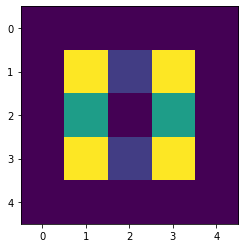

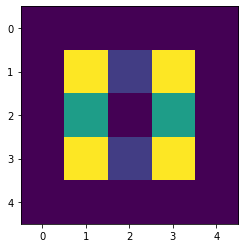

In [5]:
# show first image
plt.imshow(train_imgx[0])
plt.show()
plt.imshow(train_poly[0])
plt.show()

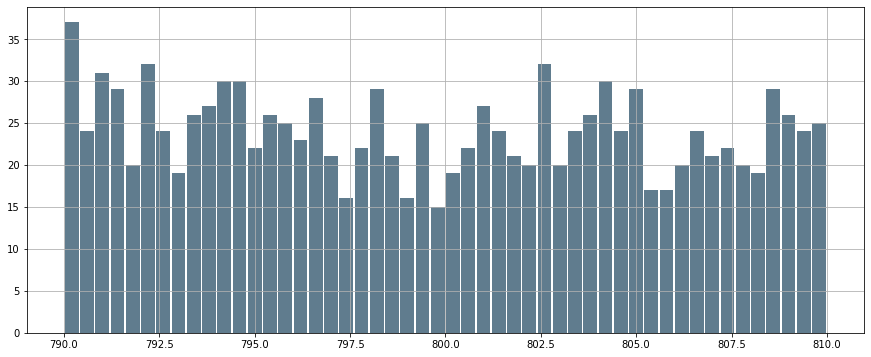

In [6]:
# plot the distribution of the parameter (uniform)
plt.rcParams["figure.figsize"] = (15,6)
param_train[0].hist(grid=True, bins=50, rwidth=0.9, color='#607c8e')
plt.show()

In [7]:
# train-test sets with original images (use this will lead to vanishing gradient)
test_split = 200
batch_size = 1
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(np.array(train_imgx[test_split:]), dtype=torch.float), 
                                   torch.tensor(np.array(param_train[test_split:]), dtype=torch.float)),
    batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(np.array(train_imgx[:test_split]), dtype=torch.float), 
                                   torch.tensor(np.array(param_train[:test_split]), dtype=torch.float)),
    batch_size=batch_size, shuffle=True, drop_last=True)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x259922c3d00>,
 <torch.utils.data.dataloader.DataLoader at 0x259eeb78fa0>)

In [8]:
# train-test sets with upscaled images (use this to avoid the vanishing gradient)
test_split = 200
batch_size = 1
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(np.array(train_imgy[test_split:]), dtype=torch.float), 
                                   torch.tensor(np.array(param_train[test_split:]), dtype=torch.float)),
    batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(np.array(train_imgy[:test_split]), dtype=torch.float), 
                                   torch.tensor(np.array(param_train[:test_split]), dtype=torch.float)),
    batch_size=batch_size, shuffle=True, drop_last=True)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x25992166670>,
 <torch.utils.data.dataloader.DataLoader at 0x25992166f40>)

In [9]:
# show the firs batch of training set
[x for x in train_loader][0]

[tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 9.1807, 2.0228, 9.1807, 0.0000],
          [0.0000, 6.1946, 0.0000, 6.1946, 0.0000],
          [0.0000, 9.1807, 2.0228, 9.1807, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]),
 tensor([[806.7466, 806.7466, 806.7466, 806.7466, 806.7466, 806.7466, 806.7466,
          806.7466, 806.7466, 806.7466, 806.7466, 806.7466, 806.7466, 806.7466,
          806.7466, 806.7466, 806.7466, 806.7466, 806.7466, 806.7466, 806.7466,
          806.7466, 806.7466, 806.7466, 806.7466]])]

In [10]:
# surrogate NN model
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Linear(25, 25),
            torch.nn.ReLU(),        # using Sigmoid is vulnerable to vanishing gradient, so use ReLu instead
            torch.nn.Linear(25, 25)
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [11]:
# SGD optimizer
cnn = CNN()
opt = optim.SGD(cnn.parameters(), lr=0.001)
epochs = 50

In [12]:
res = []
for i in range(epochs):
    for x, y in train_loader:
        opt.zero_grad()
        pred = cnn(y)
        criterion = nn.MSELoss()
        loss = criterion(pred.flatten(), x.flatten())
        loss.backward()
        print(loss)
        res.append(pred)
        opt.step() # Updating weights.

tensor(16274.0283, grad_fn=<MseLossBackward0>)
tensor(4.5082e+09, grad_fn=<MseLossBackward0>)
tensor(58.8325, grad_fn=<MseLossBackward0>)
tensor(67.4175, grad_fn=<MseLossBackward0>)
tensor(56.3303, grad_fn=<MseLossBackward0>)
tensor(53.9148, grad_fn=<MseLossBackward0>)
tensor(59.6010, grad_fn=<MseLossBackward0>)
tensor(60.1375, grad_fn=<MseLossBackward0>)
tensor(60.5508, grad_fn=<MseLossBackward0>)
tensor(67.2667, grad_fn=<MseLossBackward0>)
tensor(60.2091, grad_fn=<MseLossBackward0>)
tensor(63.0834, grad_fn=<MseLossBackward0>)
tensor(67.5396, grad_fn=<MseLossBackward0>)
tensor(54.1508, grad_fn=<MseLossBackward0>)
tensor(66.3269, grad_fn=<MseLossBackward0>)
tensor(60.6354, grad_fn=<MseLossBackward0>)
tensor(58.7167, grad_fn=<MseLossBackward0>)
tensor(56.0438, grad_fn=<MseLossBackward0>)
tensor(56.8739, grad_fn=<MseLossBackward0>)
tensor(62.3353, grad_fn=<MseLossBackward0>)
tensor(53.9889, grad_fn=<MseLossBackward0>)
tensor(62.5355, grad_fn=<MseLossBackward0>)
tensor(67.1201, grad_fn=<M

tensor(52.0051, grad_fn=<MseLossBackward0>)
tensor(53.1442, grad_fn=<MseLossBackward0>)
tensor(60.5056, grad_fn=<MseLossBackward0>)
tensor(51.7083, grad_fn=<MseLossBackward0>)
tensor(57.0878, grad_fn=<MseLossBackward0>)
tensor(54.2634, grad_fn=<MseLossBackward0>)
tensor(54.5860, grad_fn=<MseLossBackward0>)
tensor(58.5986, grad_fn=<MseLossBackward0>)
tensor(64.5970, grad_fn=<MseLossBackward0>)
tensor(57.3432, grad_fn=<MseLossBackward0>)
tensor(63.6293, grad_fn=<MseLossBackward0>)
tensor(53.6906, grad_fn=<MseLossBackward0>)
tensor(59.6958, grad_fn=<MseLossBackward0>)
tensor(54.8919, grad_fn=<MseLossBackward0>)
tensor(61.1687, grad_fn=<MseLossBackward0>)
tensor(53.4714, grad_fn=<MseLossBackward0>)
tensor(54.7548, grad_fn=<MseLossBackward0>)
tensor(54.2897, grad_fn=<MseLossBackward0>)
tensor(59.1901, grad_fn=<MseLossBackward0>)
tensor(57.8426, grad_fn=<MseLossBackward0>)
tensor(53.9642, grad_fn=<MseLossBackward0>)
tensor(51.9980, grad_fn=<MseLossBackward0>)
tensor(52.9901, grad_fn=<MseLoss

tensor(52.3159, grad_fn=<MseLossBackward0>)
tensor(55.4634, grad_fn=<MseLossBackward0>)
tensor(48.6162, grad_fn=<MseLossBackward0>)
tensor(59.4626, grad_fn=<MseLossBackward0>)
tensor(57.4161, grad_fn=<MseLossBackward0>)
tensor(48.9142, grad_fn=<MseLossBackward0>)
tensor(55.6382, grad_fn=<MseLossBackward0>)
tensor(60.5127, grad_fn=<MseLossBackward0>)
tensor(56.4413, grad_fn=<MseLossBackward0>)
tensor(61.0346, grad_fn=<MseLossBackward0>)
tensor(47.9750, grad_fn=<MseLossBackward0>)
tensor(59.3453, grad_fn=<MseLossBackward0>)
tensor(51.1907, grad_fn=<MseLossBackward0>)
tensor(56.3138, grad_fn=<MseLossBackward0>)
tensor(54.9833, grad_fn=<MseLossBackward0>)
tensor(51.0645, grad_fn=<MseLossBackward0>)
tensor(58.9957, grad_fn=<MseLossBackward0>)
tensor(57.2831, grad_fn=<MseLossBackward0>)
tensor(55.8333, grad_fn=<MseLossBackward0>)
tensor(53.0282, grad_fn=<MseLossBackward0>)
tensor(50.0986, grad_fn=<MseLossBackward0>)
tensor(55.3347, grad_fn=<MseLossBackward0>)
tensor(50.9976, grad_fn=<MseLoss

tensor(56.1215, grad_fn=<MseLossBackward0>)
tensor(55.1877, grad_fn=<MseLossBackward0>)
tensor(50.1816, grad_fn=<MseLossBackward0>)
tensor(49.8239, grad_fn=<MseLossBackward0>)
tensor(48.7935, grad_fn=<MseLossBackward0>)
tensor(55.4544, grad_fn=<MseLossBackward0>)
tensor(47.4010, grad_fn=<MseLossBackward0>)
tensor(56.8397, grad_fn=<MseLossBackward0>)
tensor(52.5741, grad_fn=<MseLossBackward0>)
tensor(46.7845, grad_fn=<MseLossBackward0>)
tensor(51.9646, grad_fn=<MseLossBackward0>)
tensor(52.4773, grad_fn=<MseLossBackward0>)
tensor(46.0977, grad_fn=<MseLossBackward0>)
tensor(48.9366, grad_fn=<MseLossBackward0>)
tensor(51.4838, grad_fn=<MseLossBackward0>)
tensor(52.4068, grad_fn=<MseLossBackward0>)
tensor(46.2626, grad_fn=<MseLossBackward0>)
tensor(46.3543, grad_fn=<MseLossBackward0>)
tensor(53.6988, grad_fn=<MseLossBackward0>)
tensor(45.9413, grad_fn=<MseLossBackward0>)
tensor(48.0783, grad_fn=<MseLossBackward0>)
tensor(45.4821, grad_fn=<MseLossBackward0>)
tensor(56.0995, grad_fn=<MseLoss

tensor(51.6442, grad_fn=<MseLossBackward0>)
tensor(52.9213, grad_fn=<MseLossBackward0>)
tensor(53.7155, grad_fn=<MseLossBackward0>)
tensor(52.0363, grad_fn=<MseLossBackward0>)
tensor(47.1177, grad_fn=<MseLossBackward0>)
tensor(50.9106, grad_fn=<MseLossBackward0>)
tensor(44.3934, grad_fn=<MseLossBackward0>)
tensor(45.5753, grad_fn=<MseLossBackward0>)
tensor(53.1114, grad_fn=<MseLossBackward0>)
tensor(54.3591, grad_fn=<MseLossBackward0>)
tensor(47.8366, grad_fn=<MseLossBackward0>)
tensor(45.0643, grad_fn=<MseLossBackward0>)
tensor(51.5898, grad_fn=<MseLossBackward0>)
tensor(47.6690, grad_fn=<MseLossBackward0>)
tensor(48.8265, grad_fn=<MseLossBackward0>)
tensor(55.2609, grad_fn=<MseLossBackward0>)
tensor(43.6908, grad_fn=<MseLossBackward0>)
tensor(54.7590, grad_fn=<MseLossBackward0>)
tensor(48.0176, grad_fn=<MseLossBackward0>)
tensor(55.1874, grad_fn=<MseLossBackward0>)
tensor(45.2764, grad_fn=<MseLossBackward0>)
tensor(53.3312, grad_fn=<MseLossBackward0>)
tensor(47.0457, grad_fn=<MseLoss

tensor(46.8076, grad_fn=<MseLossBackward0>)
tensor(53.2202, grad_fn=<MseLossBackward0>)
tensor(52.0566, grad_fn=<MseLossBackward0>)
tensor(45.7632, grad_fn=<MseLossBackward0>)
tensor(45.3120, grad_fn=<MseLossBackward0>)
tensor(43.0150, grad_fn=<MseLossBackward0>)
tensor(49.8392, grad_fn=<MseLossBackward0>)
tensor(44.4006, grad_fn=<MseLossBackward0>)
tensor(49.9977, grad_fn=<MseLossBackward0>)
tensor(40.7174, grad_fn=<MseLossBackward0>)
tensor(45.2822, grad_fn=<MseLossBackward0>)
tensor(49.4883, grad_fn=<MseLossBackward0>)
tensor(44.2434, grad_fn=<MseLossBackward0>)
tensor(43.1573, grad_fn=<MseLossBackward0>)
tensor(47.8731, grad_fn=<MseLossBackward0>)
tensor(50.5798, grad_fn=<MseLossBackward0>)
tensor(43.8854, grad_fn=<MseLossBackward0>)
tensor(52.7773, grad_fn=<MseLossBackward0>)
tensor(44.0146, grad_fn=<MseLossBackward0>)
tensor(50.2206, grad_fn=<MseLossBackward0>)
tensor(42.6900, grad_fn=<MseLossBackward0>)
tensor(47.2417, grad_fn=<MseLossBackward0>)
tensor(44.5204, grad_fn=<MseLoss

tensor(49.5566, grad_fn=<MseLossBackward0>)
tensor(39.2724, grad_fn=<MseLossBackward0>)
tensor(46.4705, grad_fn=<MseLossBackward0>)
tensor(41.6647, grad_fn=<MseLossBackward0>)
tensor(45.0475, grad_fn=<MseLossBackward0>)
tensor(42.4822, grad_fn=<MseLossBackward0>)
tensor(43.5714, grad_fn=<MseLossBackward0>)
tensor(49.4725, grad_fn=<MseLossBackward0>)
tensor(38.7968, grad_fn=<MseLossBackward0>)
tensor(40.6842, grad_fn=<MseLossBackward0>)
tensor(46.3258, grad_fn=<MseLossBackward0>)
tensor(44.0500, grad_fn=<MseLossBackward0>)
tensor(45.1256, grad_fn=<MseLossBackward0>)
tensor(49.2095, grad_fn=<MseLossBackward0>)
tensor(49.9176, grad_fn=<MseLossBackward0>)
tensor(47.2594, grad_fn=<MseLossBackward0>)
tensor(46.5887, grad_fn=<MseLossBackward0>)
tensor(39.7508, grad_fn=<MseLossBackward0>)
tensor(49.5647, grad_fn=<MseLossBackward0>)
tensor(39.1712, grad_fn=<MseLossBackward0>)
tensor(39.4252, grad_fn=<MseLossBackward0>)
tensor(44.8512, grad_fn=<MseLossBackward0>)
tensor(41.7222, grad_fn=<MseLoss

tensor(43.5005, grad_fn=<MseLossBackward0>)
tensor(44.9874, grad_fn=<MseLossBackward0>)
tensor(45.0084, grad_fn=<MseLossBackward0>)
tensor(36.5232, grad_fn=<MseLossBackward0>)
tensor(39.3966, grad_fn=<MseLossBackward0>)
tensor(47.9496, grad_fn=<MseLossBackward0>)
tensor(44.5248, grad_fn=<MseLossBackward0>)
tensor(40.8982, grad_fn=<MseLossBackward0>)
tensor(41.2612, grad_fn=<MseLossBackward0>)
tensor(36.6638, grad_fn=<MseLossBackward0>)
tensor(41.1546, grad_fn=<MseLossBackward0>)
tensor(39.5934, grad_fn=<MseLossBackward0>)
tensor(41.3355, grad_fn=<MseLossBackward0>)
tensor(46.8154, grad_fn=<MseLossBackward0>)
tensor(41.6020, grad_fn=<MseLossBackward0>)
tensor(47.8800, grad_fn=<MseLossBackward0>)
tensor(36.2496, grad_fn=<MseLossBackward0>)
tensor(38.6948, grad_fn=<MseLossBackward0>)
tensor(42.1158, grad_fn=<MseLossBackward0>)
tensor(43.7867, grad_fn=<MseLossBackward0>)
tensor(37.4252, grad_fn=<MseLossBackward0>)
tensor(38.8420, grad_fn=<MseLossBackward0>)
tensor(46.9953, grad_fn=<MseLoss

tensor(39.4482, grad_fn=<MseLossBackward0>)
tensor(38.1132, grad_fn=<MseLossBackward0>)
tensor(34.7968, grad_fn=<MseLossBackward0>)
tensor(34.7200, grad_fn=<MseLossBackward0>)
tensor(44.8135, grad_fn=<MseLossBackward0>)
tensor(37.4581, grad_fn=<MseLossBackward0>)
tensor(37.6503, grad_fn=<MseLossBackward0>)
tensor(36.3058, grad_fn=<MseLossBackward0>)
tensor(44.1847, grad_fn=<MseLossBackward0>)
tensor(38.0836, grad_fn=<MseLossBackward0>)
tensor(41.5867, grad_fn=<MseLossBackward0>)
tensor(39.9357, grad_fn=<MseLossBackward0>)
tensor(43.2331, grad_fn=<MseLossBackward0>)
tensor(36.4809, grad_fn=<MseLossBackward0>)
tensor(35.6333, grad_fn=<MseLossBackward0>)
tensor(35.0780, grad_fn=<MseLossBackward0>)
tensor(45.5071, grad_fn=<MseLossBackward0>)
tensor(34.6890, grad_fn=<MseLossBackward0>)
tensor(44.3665, grad_fn=<MseLossBackward0>)
tensor(42.7405, grad_fn=<MseLossBackward0>)
tensor(37.6932, grad_fn=<MseLossBackward0>)
tensor(40.0460, grad_fn=<MseLossBackward0>)
tensor(42.2689, grad_fn=<MseLoss

tensor(43.2899, grad_fn=<MseLossBackward0>)
tensor(42.6980, grad_fn=<MseLossBackward0>)
tensor(34.6968, grad_fn=<MseLossBackward0>)
tensor(38.2356, grad_fn=<MseLossBackward0>)
tensor(37.5945, grad_fn=<MseLossBackward0>)
tensor(33.1055, grad_fn=<MseLossBackward0>)
tensor(38.5063, grad_fn=<MseLossBackward0>)
tensor(33.7213, grad_fn=<MseLossBackward0>)
tensor(35.1457, grad_fn=<MseLossBackward0>)
tensor(37.0653, grad_fn=<MseLossBackward0>)
tensor(41.5349, grad_fn=<MseLossBackward0>)
tensor(41.0131, grad_fn=<MseLossBackward0>)
tensor(35.8270, grad_fn=<MseLossBackward0>)
tensor(35.4668, grad_fn=<MseLossBackward0>)
tensor(41.2410, grad_fn=<MseLossBackward0>)
tensor(43.3963, grad_fn=<MseLossBackward0>)
tensor(35.7082, grad_fn=<MseLossBackward0>)
tensor(41.9122, grad_fn=<MseLossBackward0>)
tensor(34.6624, grad_fn=<MseLossBackward0>)
tensor(42.6616, grad_fn=<MseLossBackward0>)
tensor(32.8688, grad_fn=<MseLossBackward0>)
tensor(36.4481, grad_fn=<MseLossBackward0>)
tensor(37.5028, grad_fn=<MseLoss

tensor(31.0872, grad_fn=<MseLossBackward0>)
tensor(30.5682, grad_fn=<MseLossBackward0>)
tensor(33.6838, grad_fn=<MseLossBackward0>)
tensor(34.4996, grad_fn=<MseLossBackward0>)
tensor(37.0413, grad_fn=<MseLossBackward0>)
tensor(34.7027, grad_fn=<MseLossBackward0>)
tensor(39.7677, grad_fn=<MseLossBackward0>)
tensor(31.2088, grad_fn=<MseLossBackward0>)
tensor(33.7114, grad_fn=<MseLossBackward0>)
tensor(35.0033, grad_fn=<MseLossBackward0>)
tensor(37.9395, grad_fn=<MseLossBackward0>)
tensor(37.0426, grad_fn=<MseLossBackward0>)
tensor(35.9412, grad_fn=<MseLossBackward0>)
tensor(34.4761, grad_fn=<MseLossBackward0>)
tensor(35.9619, grad_fn=<MseLossBackward0>)
tensor(37.0514, grad_fn=<MseLossBackward0>)
tensor(31.9681, grad_fn=<MseLossBackward0>)
tensor(32.5037, grad_fn=<MseLossBackward0>)
tensor(31.4236, grad_fn=<MseLossBackward0>)
tensor(36.9698, grad_fn=<MseLossBackward0>)
tensor(36.4092, grad_fn=<MseLossBackward0>)
tensor(34.4320, grad_fn=<MseLossBackward0>)
tensor(37.7604, grad_fn=<MseLoss

tensor(34.3981, grad_fn=<MseLossBackward0>)
tensor(28.9785, grad_fn=<MseLossBackward0>)
tensor(29.6961, grad_fn=<MseLossBackward0>)
tensor(33.5447, grad_fn=<MseLossBackward0>)
tensor(36.6713, grad_fn=<MseLossBackward0>)
tensor(30.4418, grad_fn=<MseLossBackward0>)
tensor(30.8266, grad_fn=<MseLossBackward0>)
tensor(30.4671, grad_fn=<MseLossBackward0>)
tensor(37.2028, grad_fn=<MseLossBackward0>)
tensor(33.6291, grad_fn=<MseLossBackward0>)
tensor(31.8912, grad_fn=<MseLossBackward0>)
tensor(31.8814, grad_fn=<MseLossBackward0>)
tensor(37.0488, grad_fn=<MseLossBackward0>)
tensor(35.9411, grad_fn=<MseLossBackward0>)
tensor(34.4323, grad_fn=<MseLossBackward0>)
tensor(29.7171, grad_fn=<MseLossBackward0>)
tensor(39.1602, grad_fn=<MseLossBackward0>)
tensor(32.7658, grad_fn=<MseLossBackward0>)
tensor(29.5553, grad_fn=<MseLossBackward0>)
tensor(34.2366, grad_fn=<MseLossBackward0>)
tensor(30.9790, grad_fn=<MseLossBackward0>)
tensor(35.7152, grad_fn=<MseLossBackward0>)
tensor(33.0267, grad_fn=<MseLoss

tensor(28.2471, grad_fn=<MseLossBackward0>)
tensor(35.7891, grad_fn=<MseLossBackward0>)
tensor(31.3958, grad_fn=<MseLossBackward0>)
tensor(37.1726, grad_fn=<MseLossBackward0>)
tensor(28.4211, grad_fn=<MseLossBackward0>)
tensor(28.2931, grad_fn=<MseLossBackward0>)
tensor(29.9823, grad_fn=<MseLossBackward0>)
tensor(34.4100, grad_fn=<MseLossBackward0>)
tensor(33.5003, grad_fn=<MseLossBackward0>)
tensor(32.4567, grad_fn=<MseLossBackward0>)
tensor(27.6810, grad_fn=<MseLossBackward0>)
tensor(34.1791, grad_fn=<MseLossBackward0>)
tensor(27.5931, grad_fn=<MseLossBackward0>)
tensor(36.0104, grad_fn=<MseLossBackward0>)
tensor(30.9075, grad_fn=<MseLossBackward0>)
tensor(27.6637, grad_fn=<MseLossBackward0>)
tensor(31.6311, grad_fn=<MseLossBackward0>)
tensor(30.0869, grad_fn=<MseLossBackward0>)
tensor(33.7953, grad_fn=<MseLossBackward0>)
tensor(34.3373, grad_fn=<MseLossBackward0>)
tensor(36.2724, grad_fn=<MseLossBackward0>)
tensor(34.7730, grad_fn=<MseLossBackward0>)
tensor(36.7309, grad_fn=<MseLoss

tensor(35.3600, grad_fn=<MseLossBackward0>)
tensor(25.8190, grad_fn=<MseLossBackward0>)
tensor(33.4688, grad_fn=<MseLossBackward0>)
tensor(32.0501, grad_fn=<MseLossBackward0>)
tensor(29.1682, grad_fn=<MseLossBackward0>)
tensor(28.9055, grad_fn=<MseLossBackward0>)
tensor(28.1202, grad_fn=<MseLossBackward0>)
tensor(26.7292, grad_fn=<MseLossBackward0>)
tensor(27.0105, grad_fn=<MseLossBackward0>)
tensor(28.9828, grad_fn=<MseLossBackward0>)
tensor(32.9505, grad_fn=<MseLossBackward0>)
tensor(31.3408, grad_fn=<MseLossBackward0>)
tensor(30.6436, grad_fn=<MseLossBackward0>)
tensor(29.2059, grad_fn=<MseLossBackward0>)
tensor(34.0325, grad_fn=<MseLossBackward0>)
tensor(25.8769, grad_fn=<MseLossBackward0>)
tensor(28.1031, grad_fn=<MseLossBackward0>)
tensor(33.6807, grad_fn=<MseLossBackward0>)
tensor(33.4921, grad_fn=<MseLossBackward0>)
tensor(31.0736, grad_fn=<MseLossBackward0>)
tensor(35.4407, grad_fn=<MseLossBackward0>)
tensor(32.8547, grad_fn=<MseLossBackward0>)
tensor(30.1401, grad_fn=<MseLoss

tensor(25.7254, grad_fn=<MseLossBackward0>)
tensor(26.1333, grad_fn=<MseLossBackward0>)
tensor(28.7170, grad_fn=<MseLossBackward0>)
tensor(25.4434, grad_fn=<MseLossBackward0>)
tensor(26.6007, grad_fn=<MseLossBackward0>)
tensor(26.3427, grad_fn=<MseLossBackward0>)
tensor(30.6686, grad_fn=<MseLossBackward0>)
tensor(27.9791, grad_fn=<MseLossBackward0>)
tensor(25.3054, grad_fn=<MseLossBackward0>)
tensor(31.7367, grad_fn=<MseLossBackward0>)
tensor(26.7210, grad_fn=<MseLossBackward0>)
tensor(26.2404, grad_fn=<MseLossBackward0>)
tensor(30.3103, grad_fn=<MseLossBackward0>)
tensor(26.2151, grad_fn=<MseLossBackward0>)
tensor(30.0155, grad_fn=<MseLossBackward0>)
tensor(26.9477, grad_fn=<MseLossBackward0>)
tensor(24.7066, grad_fn=<MseLossBackward0>)
tensor(26.8932, grad_fn=<MseLossBackward0>)
tensor(30.3860, grad_fn=<MseLossBackward0>)
tensor(24.8624, grad_fn=<MseLossBackward0>)
tensor(25.3610, grad_fn=<MseLossBackward0>)
tensor(33.0650, grad_fn=<MseLossBackward0>)
tensor(30.8986, grad_fn=<MseLoss

tensor(26.6911, grad_fn=<MseLossBackward0>)
tensor(32.1733, grad_fn=<MseLossBackward0>)
tensor(25.9646, grad_fn=<MseLossBackward0>)
tensor(29.5534, grad_fn=<MseLossBackward0>)
tensor(23.3877, grad_fn=<MseLossBackward0>)
tensor(23.5231, grad_fn=<MseLossBackward0>)
tensor(27.8130, grad_fn=<MseLossBackward0>)
tensor(28.4714, grad_fn=<MseLossBackward0>)
tensor(30.8684, grad_fn=<MseLossBackward0>)
tensor(31.1291, grad_fn=<MseLossBackward0>)
tensor(31.1176, grad_fn=<MseLossBackward0>)
tensor(24.3494, grad_fn=<MseLossBackward0>)
tensor(27.4446, grad_fn=<MseLossBackward0>)
tensor(31.4359, grad_fn=<MseLossBackward0>)
tensor(30.2029, grad_fn=<MseLossBackward0>)
tensor(27.6174, grad_fn=<MseLossBackward0>)
tensor(29.5439, grad_fn=<MseLossBackward0>)
tensor(28.8833, grad_fn=<MseLossBackward0>)
tensor(28.7782, grad_fn=<MseLossBackward0>)
tensor(32.8158, grad_fn=<MseLossBackward0>)
tensor(31.3201, grad_fn=<MseLossBackward0>)
tensor(23.3571, grad_fn=<MseLossBackward0>)
tensor(30.6043, grad_fn=<MseLoss

tensor(31.4182, grad_fn=<MseLossBackward0>)
tensor(24.4917, grad_fn=<MseLossBackward0>)
tensor(26.3732, grad_fn=<MseLossBackward0>)
tensor(28.3074, grad_fn=<MseLossBackward0>)
tensor(24.0251, grad_fn=<MseLossBackward0>)
tensor(26.3226, grad_fn=<MseLossBackward0>)
tensor(29.2048, grad_fn=<MseLossBackward0>)
tensor(25.2659, grad_fn=<MseLossBackward0>)
tensor(24.2339, grad_fn=<MseLossBackward0>)
tensor(25.6681, grad_fn=<MseLossBackward0>)
tensor(26.5233, grad_fn=<MseLossBackward0>)
tensor(24.0411, grad_fn=<MseLossBackward0>)
tensor(30.4723, grad_fn=<MseLossBackward0>)
tensor(22.2427, grad_fn=<MseLossBackward0>)
tensor(23.8102, grad_fn=<MseLossBackward0>)
tensor(22.9347, grad_fn=<MseLossBackward0>)
tensor(25.5934, grad_fn=<MseLossBackward0>)
tensor(29.0589, grad_fn=<MseLossBackward0>)
tensor(28.9411, grad_fn=<MseLossBackward0>)
tensor(22.7679, grad_fn=<MseLossBackward0>)
tensor(21.9953, grad_fn=<MseLossBackward0>)
tensor(27.4044, grad_fn=<MseLossBackward0>)
tensor(30.0593, grad_fn=<MseLoss

tensor(22.7758, grad_fn=<MseLossBackward0>)
tensor(27.8259, grad_fn=<MseLossBackward0>)
tensor(26.3716, grad_fn=<MseLossBackward0>)
tensor(30.0384, grad_fn=<MseLossBackward0>)
tensor(21.3267, grad_fn=<MseLossBackward0>)
tensor(27.8033, grad_fn=<MseLossBackward0>)
tensor(25.4332, grad_fn=<MseLossBackward0>)
tensor(23.7110, grad_fn=<MseLossBackward0>)
tensor(22.1899, grad_fn=<MseLossBackward0>)
tensor(21.0436, grad_fn=<MseLossBackward0>)
tensor(28.1603, grad_fn=<MseLossBackward0>)
tensor(21.7574, grad_fn=<MseLossBackward0>)
tensor(21.6570, grad_fn=<MseLossBackward0>)
tensor(22.7807, grad_fn=<MseLossBackward0>)
tensor(22.1783, grad_fn=<MseLossBackward0>)
tensor(25.2293, grad_fn=<MseLossBackward0>)
tensor(23.0011, grad_fn=<MseLossBackward0>)
tensor(24.1507, grad_fn=<MseLossBackward0>)
tensor(27.3845, grad_fn=<MseLossBackward0>)
tensor(21.5225, grad_fn=<MseLossBackward0>)
tensor(23.3901, grad_fn=<MseLossBackward0>)
tensor(26.0569, grad_fn=<MseLossBackward0>)
tensor(24.0814, grad_fn=<MseLoss

tensor(22.1263, grad_fn=<MseLossBackward0>)
tensor(23.1312, grad_fn=<MseLossBackward0>)
tensor(24.7898, grad_fn=<MseLossBackward0>)
tensor(21.8892, grad_fn=<MseLossBackward0>)
tensor(26.8610, grad_fn=<MseLossBackward0>)
tensor(26.2309, grad_fn=<MseLossBackward0>)
tensor(22.2763, grad_fn=<MseLossBackward0>)
tensor(20.4720, grad_fn=<MseLossBackward0>)
tensor(28.8796, grad_fn=<MseLossBackward0>)
tensor(23.3976, grad_fn=<MseLossBackward0>)
tensor(26.5497, grad_fn=<MseLossBackward0>)
tensor(20.0720, grad_fn=<MseLossBackward0>)
tensor(23.8750, grad_fn=<MseLossBackward0>)
tensor(24.7535, grad_fn=<MseLossBackward0>)
tensor(24.7198, grad_fn=<MseLossBackward0>)
tensor(25.3491, grad_fn=<MseLossBackward0>)
tensor(22.3228, grad_fn=<MseLossBackward0>)
tensor(24.0865, grad_fn=<MseLossBackward0>)
tensor(22.8182, grad_fn=<MseLossBackward0>)
tensor(23.4349, grad_fn=<MseLossBackward0>)
tensor(25.5470, grad_fn=<MseLossBackward0>)
tensor(28.9132, grad_fn=<MseLossBackward0>)
tensor(25.6770, grad_fn=<MseLoss

tensor(21.9793, grad_fn=<MseLossBackward0>)
tensor(27.8691, grad_fn=<MseLossBackward0>)
tensor(25.1177, grad_fn=<MseLossBackward0>)
tensor(23.9743, grad_fn=<MseLossBackward0>)
tensor(19.4628, grad_fn=<MseLossBackward0>)
tensor(26.2223, grad_fn=<MseLossBackward0>)
tensor(21.5772, grad_fn=<MseLossBackward0>)
tensor(23.0317, grad_fn=<MseLossBackward0>)
tensor(25.8988, grad_fn=<MseLossBackward0>)
tensor(25.7392, grad_fn=<MseLossBackward0>)
tensor(19.3938, grad_fn=<MseLossBackward0>)
tensor(27.7824, grad_fn=<MseLossBackward0>)
tensor(19.8416, grad_fn=<MseLossBackward0>)
tensor(21.3465, grad_fn=<MseLossBackward0>)
tensor(19.1782, grad_fn=<MseLossBackward0>)
tensor(21.6379, grad_fn=<MseLossBackward0>)
tensor(23.6617, grad_fn=<MseLossBackward0>)
tensor(26.4054, grad_fn=<MseLossBackward0>)
tensor(26.3345, grad_fn=<MseLossBackward0>)
tensor(23.4364, grad_fn=<MseLossBackward0>)
tensor(27.0883, grad_fn=<MseLossBackward0>)
tensor(27.7047, grad_fn=<MseLossBackward0>)
tensor(20.9128, grad_fn=<MseLoss

tensor(22.9196, grad_fn=<MseLossBackward0>)
tensor(26.0528, grad_fn=<MseLossBackward0>)
tensor(21.7672, grad_fn=<MseLossBackward0>)
tensor(22.0141, grad_fn=<MseLossBackward0>)
tensor(21.0669, grad_fn=<MseLossBackward0>)
tensor(22.5437, grad_fn=<MseLossBackward0>)
tensor(21.2646, grad_fn=<MseLossBackward0>)
tensor(24.5794, grad_fn=<MseLossBackward0>)
tensor(21.5436, grad_fn=<MseLossBackward0>)
tensor(25.4986, grad_fn=<MseLossBackward0>)
tensor(24.8749, grad_fn=<MseLossBackward0>)
tensor(19.9475, grad_fn=<MseLossBackward0>)
tensor(25.1709, grad_fn=<MseLossBackward0>)
tensor(21.4055, grad_fn=<MseLossBackward0>)
tensor(23.2079, grad_fn=<MseLossBackward0>)
tensor(26.6786, grad_fn=<MseLossBackward0>)
tensor(21.8671, grad_fn=<MseLossBackward0>)
tensor(23.7421, grad_fn=<MseLossBackward0>)
tensor(18.9187, grad_fn=<MseLossBackward0>)
tensor(25.1684, grad_fn=<MseLossBackward0>)
tensor(18.2404, grad_fn=<MseLossBackward0>)
tensor(22.2675, grad_fn=<MseLossBackward0>)
tensor(25.9775, grad_fn=<MseLoss

tensor(22.3916, grad_fn=<MseLossBackward0>)
tensor(20.6964, grad_fn=<MseLossBackward0>)
tensor(22.8074, grad_fn=<MseLossBackward0>)
tensor(25.5708, grad_fn=<MseLossBackward0>)
tensor(20.6557, grad_fn=<MseLossBackward0>)
tensor(23.1342, grad_fn=<MseLossBackward0>)
tensor(19.0634, grad_fn=<MseLossBackward0>)
tensor(18.2225, grad_fn=<MseLossBackward0>)
tensor(18.9599, grad_fn=<MseLossBackward0>)
tensor(23.4601, grad_fn=<MseLossBackward0>)
tensor(18.6183, grad_fn=<MseLossBackward0>)
tensor(18.9788, grad_fn=<MseLossBackward0>)
tensor(21.8029, grad_fn=<MseLossBackward0>)
tensor(21.8732, grad_fn=<MseLossBackward0>)
tensor(17.9721, grad_fn=<MseLossBackward0>)
tensor(19.7334, grad_fn=<MseLossBackward0>)
tensor(23.1094, grad_fn=<MseLossBackward0>)
tensor(17.3533, grad_fn=<MseLossBackward0>)
tensor(17.6166, grad_fn=<MseLossBackward0>)
tensor(21.2759, grad_fn=<MseLossBackward0>)
tensor(25.0490, grad_fn=<MseLossBackward0>)
tensor(25.2220, grad_fn=<MseLossBackward0>)
tensor(18.1450, grad_fn=<MseLoss

tensor(24.0980, grad_fn=<MseLossBackward0>)
tensor(18.6603, grad_fn=<MseLossBackward0>)
tensor(17.1451, grad_fn=<MseLossBackward0>)
tensor(18.9685, grad_fn=<MseLossBackward0>)
tensor(19.3159, grad_fn=<MseLossBackward0>)
tensor(17.9898, grad_fn=<MseLossBackward0>)
tensor(22.0873, grad_fn=<MseLossBackward0>)
tensor(24.2384, grad_fn=<MseLossBackward0>)
tensor(21.4146, grad_fn=<MseLossBackward0>)
tensor(18.1789, grad_fn=<MseLossBackward0>)
tensor(22.7453, grad_fn=<MseLossBackward0>)
tensor(18.9361, grad_fn=<MseLossBackward0>)
tensor(24.2378, grad_fn=<MseLossBackward0>)
tensor(20.9112, grad_fn=<MseLossBackward0>)
tensor(17.9545, grad_fn=<MseLossBackward0>)
tensor(24.6321, grad_fn=<MseLossBackward0>)
tensor(22.4004, grad_fn=<MseLossBackward0>)
tensor(17.0945, grad_fn=<MseLossBackward0>)
tensor(22.1739, grad_fn=<MseLossBackward0>)
tensor(18.6956, grad_fn=<MseLossBackward0>)
tensor(20.9554, grad_fn=<MseLossBackward0>)
tensor(18.0330, grad_fn=<MseLossBackward0>)
tensor(16.4649, grad_fn=<MseLoss

tensor(18.0970, grad_fn=<MseLossBackward0>)
tensor(17.8274, grad_fn=<MseLossBackward0>)
tensor(18.0643, grad_fn=<MseLossBackward0>)
tensor(17.9280, grad_fn=<MseLossBackward0>)
tensor(19.6090, grad_fn=<MseLossBackward0>)
tensor(22.8057, grad_fn=<MseLossBackward0>)
tensor(18.3871, grad_fn=<MseLossBackward0>)
tensor(17.4761, grad_fn=<MseLossBackward0>)
tensor(16.0466, grad_fn=<MseLossBackward0>)
tensor(20.0551, grad_fn=<MseLossBackward0>)
tensor(19.9863, grad_fn=<MseLossBackward0>)
tensor(20.6238, grad_fn=<MseLossBackward0>)
tensor(16.9616, grad_fn=<MseLossBackward0>)
tensor(15.9742, grad_fn=<MseLossBackward0>)
tensor(19.0592, grad_fn=<MseLossBackward0>)
tensor(20.8893, grad_fn=<MseLossBackward0>)
tensor(21.3564, grad_fn=<MseLossBackward0>)
tensor(17.5571, grad_fn=<MseLossBackward0>)
tensor(23.0158, grad_fn=<MseLossBackward0>)
tensor(23.4199, grad_fn=<MseLossBackward0>)
tensor(22.2206, grad_fn=<MseLossBackward0>)
tensor(15.8680, grad_fn=<MseLossBackward0>)
tensor(22.6819, grad_fn=<MseLoss

tensor(17.7969, grad_fn=<MseLossBackward0>)
tensor(20.7295, grad_fn=<MseLossBackward0>)
tensor(16.9589, grad_fn=<MseLossBackward0>)
tensor(22.7426, grad_fn=<MseLossBackward0>)
tensor(16.5138, grad_fn=<MseLossBackward0>)
tensor(21.3253, grad_fn=<MseLossBackward0>)
tensor(15.9860, grad_fn=<MseLossBackward0>)
tensor(17.4322, grad_fn=<MseLossBackward0>)
tensor(18.2579, grad_fn=<MseLossBackward0>)
tensor(20.3683, grad_fn=<MseLossBackward0>)
tensor(15.2586, grad_fn=<MseLossBackward0>)
tensor(19.1222, grad_fn=<MseLossBackward0>)
tensor(17.3881, grad_fn=<MseLossBackward0>)
tensor(15.3153, grad_fn=<MseLossBackward0>)
tensor(16.2264, grad_fn=<MseLossBackward0>)
tensor(16.9133, grad_fn=<MseLossBackward0>)
tensor(16.9349, grad_fn=<MseLossBackward0>)
tensor(22.0267, grad_fn=<MseLossBackward0>)
tensor(20.9647, grad_fn=<MseLossBackward0>)
tensor(17.7857, grad_fn=<MseLossBackward0>)
tensor(19.9549, grad_fn=<MseLossBackward0>)
tensor(20.2918, grad_fn=<MseLossBackward0>)
tensor(17.4485, grad_fn=<MseLoss

tensor(19.0940, grad_fn=<MseLossBackward0>)
tensor(16.7820, grad_fn=<MseLossBackward0>)
tensor(14.1797, grad_fn=<MseLossBackward0>)
tensor(14.4076, grad_fn=<MseLossBackward0>)
tensor(20.6200, grad_fn=<MseLossBackward0>)
tensor(19.3797, grad_fn=<MseLossBackward0>)
tensor(14.1941, grad_fn=<MseLossBackward0>)
tensor(21.2120, grad_fn=<MseLossBackward0>)
tensor(14.2577, grad_fn=<MseLossBackward0>)
tensor(20.2996, grad_fn=<MseLossBackward0>)
tensor(19.6127, grad_fn=<MseLossBackward0>)
tensor(15.0361, grad_fn=<MseLossBackward0>)
tensor(16.3721, grad_fn=<MseLossBackward0>)
tensor(15.8157, grad_fn=<MseLossBackward0>)
tensor(17.6639, grad_fn=<MseLossBackward0>)
tensor(15.9002, grad_fn=<MseLossBackward0>)
tensor(19.9104, grad_fn=<MseLossBackward0>)
tensor(14.3549, grad_fn=<MseLossBackward0>)
tensor(19.8639, grad_fn=<MseLossBackward0>)
tensor(14.3199, grad_fn=<MseLossBackward0>)
tensor(20.6995, grad_fn=<MseLossBackward0>)
tensor(17.2568, grad_fn=<MseLossBackward0>)
tensor(15.9510, grad_fn=<MseLoss

tensor(20.2284, grad_fn=<MseLossBackward0>)
tensor(18.9785, grad_fn=<MseLossBackward0>)
tensor(18.0864, grad_fn=<MseLossBackward0>)
tensor(20.6177, grad_fn=<MseLossBackward0>)
tensor(19.8451, grad_fn=<MseLossBackward0>)
tensor(20.2933, grad_fn=<MseLossBackward0>)
tensor(15.9578, grad_fn=<MseLossBackward0>)
tensor(16.0189, grad_fn=<MseLossBackward0>)
tensor(15.8942, grad_fn=<MseLossBackward0>)
tensor(16.5653, grad_fn=<MseLossBackward0>)
tensor(15.6583, grad_fn=<MseLossBackward0>)
tensor(18.5070, grad_fn=<MseLossBackward0>)
tensor(18.9331, grad_fn=<MseLossBackward0>)
tensor(14.8458, grad_fn=<MseLossBackward0>)
tensor(19.3289, grad_fn=<MseLossBackward0>)
tensor(18.7456, grad_fn=<MseLossBackward0>)
tensor(13.5290, grad_fn=<MseLossBackward0>)
tensor(19.9867, grad_fn=<MseLossBackward0>)
tensor(18.9463, grad_fn=<MseLossBackward0>)
tensor(16.4137, grad_fn=<MseLossBackward0>)
tensor(19.2881, grad_fn=<MseLossBackward0>)
tensor(15.1410, grad_fn=<MseLossBackward0>)
tensor(20.2995, grad_fn=<MseLoss

tensor(16.8374, grad_fn=<MseLossBackward0>)
tensor(15.2958, grad_fn=<MseLossBackward0>)
tensor(19.7987, grad_fn=<MseLossBackward0>)
tensor(19.7630, grad_fn=<MseLossBackward0>)
tensor(13.1271, grad_fn=<MseLossBackward0>)
tensor(19.7067, grad_fn=<MseLossBackward0>)
tensor(12.7145, grad_fn=<MseLossBackward0>)
tensor(14.8053, grad_fn=<MseLossBackward0>)
tensor(12.6752, grad_fn=<MseLossBackward0>)
tensor(14.2687, grad_fn=<MseLossBackward0>)
tensor(19.7673, grad_fn=<MseLossBackward0>)
tensor(19.6676, grad_fn=<MseLossBackward0>)
tensor(19.4901, grad_fn=<MseLossBackward0>)
tensor(15.4409, grad_fn=<MseLossBackward0>)
tensor(13.0601, grad_fn=<MseLossBackward0>)
tensor(14.4911, grad_fn=<MseLossBackward0>)
tensor(15.1353, grad_fn=<MseLossBackward0>)
tensor(13.2998, grad_fn=<MseLossBackward0>)
tensor(14.0044, grad_fn=<MseLossBackward0>)
tensor(16.8226, grad_fn=<MseLossBackward0>)
tensor(12.9129, grad_fn=<MseLossBackward0>)
tensor(17.9674, grad_fn=<MseLossBackward0>)
tensor(13.8055, grad_fn=<MseLoss

tensor(13.1838, grad_fn=<MseLossBackward0>)
tensor(17.4617, grad_fn=<MseLossBackward0>)
tensor(18.7472, grad_fn=<MseLossBackward0>)
tensor(12.1953, grad_fn=<MseLossBackward0>)
tensor(18.1103, grad_fn=<MseLossBackward0>)
tensor(13.4215, grad_fn=<MseLossBackward0>)
tensor(13.7932, grad_fn=<MseLossBackward0>)
tensor(17.4008, grad_fn=<MseLossBackward0>)
tensor(17.4948, grad_fn=<MseLossBackward0>)
tensor(17.8546, grad_fn=<MseLossBackward0>)
tensor(16.2729, grad_fn=<MseLossBackward0>)
tensor(15.3318, grad_fn=<MseLossBackward0>)
tensor(16.0373, grad_fn=<MseLossBackward0>)
tensor(14.3646, grad_fn=<MseLossBackward0>)
tensor(12.8629, grad_fn=<MseLossBackward0>)
tensor(12.2720, grad_fn=<MseLossBackward0>)
tensor(13.0501, grad_fn=<MseLossBackward0>)
tensor(13.2485, grad_fn=<MseLossBackward0>)
tensor(12.9288, grad_fn=<MseLossBackward0>)
tensor(17.6415, grad_fn=<MseLossBackward0>)
tensor(16.6772, grad_fn=<MseLossBackward0>)
tensor(13.2013, grad_fn=<MseLossBackward0>)
tensor(17.5761, grad_fn=<MseLoss

tensor(15.1498, grad_fn=<MseLossBackward0>)
tensor(15.4299, grad_fn=<MseLossBackward0>)
tensor(13.1682, grad_fn=<MseLossBackward0>)
tensor(16.7909, grad_fn=<MseLossBackward0>)
tensor(17.4264, grad_fn=<MseLossBackward0>)
tensor(12.2696, grad_fn=<MseLossBackward0>)
tensor(16.2360, grad_fn=<MseLossBackward0>)
tensor(15.9235, grad_fn=<MseLossBackward0>)
tensor(17.2853, grad_fn=<MseLossBackward0>)
tensor(15.8167, grad_fn=<MseLossBackward0>)
tensor(15.7943, grad_fn=<MseLossBackward0>)
tensor(13.8309, grad_fn=<MseLossBackward0>)
tensor(13.3805, grad_fn=<MseLossBackward0>)
tensor(14.4337, grad_fn=<MseLossBackward0>)
tensor(11.8363, grad_fn=<MseLossBackward0>)
tensor(17.6750, grad_fn=<MseLossBackward0>)
tensor(14.3089, grad_fn=<MseLossBackward0>)
tensor(12.0100, grad_fn=<MseLossBackward0>)
tensor(11.1806, grad_fn=<MseLossBackward0>)
tensor(15.6392, grad_fn=<MseLossBackward0>)
tensor(12.8744, grad_fn=<MseLossBackward0>)
tensor(12.6966, grad_fn=<MseLossBackward0>)
tensor(12.1528, grad_fn=<MseLoss

tensor(15.8349, grad_fn=<MseLossBackward0>)
tensor(10.7991, grad_fn=<MseLossBackward0>)
tensor(11.7066, grad_fn=<MseLossBackward0>)
tensor(14.1546, grad_fn=<MseLossBackward0>)
tensor(13.2480, grad_fn=<MseLossBackward0>)
tensor(11.3281, grad_fn=<MseLossBackward0>)
tensor(12.7381, grad_fn=<MseLossBackward0>)
tensor(13.2442, grad_fn=<MseLossBackward0>)
tensor(12.9153, grad_fn=<MseLossBackward0>)
tensor(13.9645, grad_fn=<MseLossBackward0>)
tensor(16.8352, grad_fn=<MseLossBackward0>)
tensor(10.5503, grad_fn=<MseLossBackward0>)
tensor(13.6560, grad_fn=<MseLossBackward0>)
tensor(12.3432, grad_fn=<MseLossBackward0>)
tensor(13.7805, grad_fn=<MseLossBackward0>)
tensor(13.1526, grad_fn=<MseLossBackward0>)
tensor(11.3347, grad_fn=<MseLossBackward0>)
tensor(11.7650, grad_fn=<MseLossBackward0>)
tensor(12.5514, grad_fn=<MseLossBackward0>)
tensor(15.0959, grad_fn=<MseLossBackward0>)
tensor(13.0562, grad_fn=<MseLossBackward0>)
tensor(15.6903, grad_fn=<MseLossBackward0>)
tensor(14.1618, grad_fn=<MseLoss

tensor(13.0459, grad_fn=<MseLossBackward0>)
tensor(10.5386, grad_fn=<MseLossBackward0>)
tensor(10.2084, grad_fn=<MseLossBackward0>)
tensor(13.2519, grad_fn=<MseLossBackward0>)
tensor(11.3459, grad_fn=<MseLossBackward0>)
tensor(11.0537, grad_fn=<MseLossBackward0>)
tensor(13.5378, grad_fn=<MseLossBackward0>)
tensor(16.2201, grad_fn=<MseLossBackward0>)
tensor(12.1761, grad_fn=<MseLossBackward0>)
tensor(11.4567, grad_fn=<MseLossBackward0>)
tensor(16.4209, grad_fn=<MseLossBackward0>)
tensor(10.2249, grad_fn=<MseLossBackward0>)
tensor(10.7288, grad_fn=<MseLossBackward0>)
tensor(11.5700, grad_fn=<MseLossBackward0>)
tensor(10.5091, grad_fn=<MseLossBackward0>)
tensor(15.6389, grad_fn=<MseLossBackward0>)
tensor(15.1749, grad_fn=<MseLossBackward0>)
tensor(10.8924, grad_fn=<MseLossBackward0>)
tensor(10.1309, grad_fn=<MseLossBackward0>)
tensor(16.2830, grad_fn=<MseLossBackward0>)
tensor(12.8313, grad_fn=<MseLossBackward0>)
tensor(15.8054, grad_fn=<MseLossBackward0>)
tensor(14.5507, grad_fn=<MseLoss

tensor(9.6891, grad_fn=<MseLossBackward0>)
tensor(13.0859, grad_fn=<MseLossBackward0>)
tensor(9.5839, grad_fn=<MseLossBackward0>)
tensor(15.3717, grad_fn=<MseLossBackward0>)
tensor(14.2658, grad_fn=<MseLossBackward0>)
tensor(14.6979, grad_fn=<MseLossBackward0>)
tensor(12.1916, grad_fn=<MseLossBackward0>)
tensor(9.5129, grad_fn=<MseLossBackward0>)
tensor(15.1808, grad_fn=<MseLossBackward0>)
tensor(10.1887, grad_fn=<MseLossBackward0>)
tensor(10.2627, grad_fn=<MseLossBackward0>)
tensor(12.3631, grad_fn=<MseLossBackward0>)
tensor(10.3625, grad_fn=<MseLossBackward0>)
tensor(15.5885, grad_fn=<MseLossBackward0>)
tensor(9.7646, grad_fn=<MseLossBackward0>)
tensor(10.5497, grad_fn=<MseLossBackward0>)
tensor(9.6299, grad_fn=<MseLossBackward0>)
tensor(15.6469, grad_fn=<MseLossBackward0>)
tensor(10.3016, grad_fn=<MseLossBackward0>)
tensor(11.2632, grad_fn=<MseLossBackward0>)
tensor(9.8182, grad_fn=<MseLossBackward0>)
tensor(12.7935, grad_fn=<MseLossBackward0>)
tensor(13.3254, grad_fn=<MseLossBackwa

tensor(13.6359, grad_fn=<MseLossBackward0>)
tensor(9.5966, grad_fn=<MseLossBackward0>)
tensor(8.9240, grad_fn=<MseLossBackward0>)
tensor(14.2778, grad_fn=<MseLossBackward0>)
tensor(11.8255, grad_fn=<MseLossBackward0>)
tensor(14.5170, grad_fn=<MseLossBackward0>)
tensor(9.9589, grad_fn=<MseLossBackward0>)
tensor(10.1394, grad_fn=<MseLossBackward0>)
tensor(13.2061, grad_fn=<MseLossBackward0>)
tensor(12.5401, grad_fn=<MseLossBackward0>)
tensor(13.4519, grad_fn=<MseLossBackward0>)
tensor(10.8537, grad_fn=<MseLossBackward0>)
tensor(9.6310, grad_fn=<MseLossBackward0>)
tensor(12.3478, grad_fn=<MseLossBackward0>)
tensor(9.9718, grad_fn=<MseLossBackward0>)
tensor(14.2370, grad_fn=<MseLossBackward0>)
tensor(10.2875, grad_fn=<MseLossBackward0>)
tensor(9.8113, grad_fn=<MseLossBackward0>)
tensor(10.2999, grad_fn=<MseLossBackward0>)
tensor(12.6395, grad_fn=<MseLossBackward0>)
tensor(14.6241, grad_fn=<MseLossBackward0>)
tensor(11.3468, grad_fn=<MseLossBackward0>)
tensor(9.5449, grad_fn=<MseLossBackwar

tensor(12.8086, grad_fn=<MseLossBackward0>)
tensor(9.9842, grad_fn=<MseLossBackward0>)
tensor(8.7000, grad_fn=<MseLossBackward0>)
tensor(8.4001, grad_fn=<MseLossBackward0>)
tensor(9.8673, grad_fn=<MseLossBackward0>)
tensor(10.1376, grad_fn=<MseLossBackward0>)
tensor(9.9575, grad_fn=<MseLossBackward0>)
tensor(8.9644, grad_fn=<MseLossBackward0>)
tensor(8.7416, grad_fn=<MseLossBackward0>)
tensor(9.8760, grad_fn=<MseLossBackward0>)
tensor(9.5574, grad_fn=<MseLossBackward0>)
tensor(9.0904, grad_fn=<MseLossBackward0>)
tensor(9.6860, grad_fn=<MseLossBackward0>)
tensor(8.4863, grad_fn=<MseLossBackward0>)
tensor(13.3561, grad_fn=<MseLossBackward0>)
tensor(8.9942, grad_fn=<MseLossBackward0>)
tensor(13.4397, grad_fn=<MseLossBackward0>)
tensor(14.1224, grad_fn=<MseLossBackward0>)
tensor(8.7915, grad_fn=<MseLossBackward0>)
tensor(11.7150, grad_fn=<MseLossBackward0>)
tensor(11.2548, grad_fn=<MseLossBackward0>)
tensor(11.5739, grad_fn=<MseLossBackward0>)
tensor(10.3555, grad_fn=<MseLossBackward0>)
te

tensor(13.5882, grad_fn=<MseLossBackward0>)
tensor(10.4397, grad_fn=<MseLossBackward0>)
tensor(10.7237, grad_fn=<MseLossBackward0>)
tensor(9.9302, grad_fn=<MseLossBackward0>)
tensor(13.0799, grad_fn=<MseLossBackward0>)
tensor(10.3477, grad_fn=<MseLossBackward0>)
tensor(11.3853, grad_fn=<MseLossBackward0>)
tensor(12.8678, grad_fn=<MseLossBackward0>)
tensor(9.6334, grad_fn=<MseLossBackward0>)
tensor(8.6843, grad_fn=<MseLossBackward0>)
tensor(8.5556, grad_fn=<MseLossBackward0>)
tensor(10.2846, grad_fn=<MseLossBackward0>)
tensor(10.4137, grad_fn=<MseLossBackward0>)
tensor(10.4817, grad_fn=<MseLossBackward0>)
tensor(10.3017, grad_fn=<MseLossBackward0>)
tensor(13.1471, grad_fn=<MseLossBackward0>)
tensor(12.2880, grad_fn=<MseLossBackward0>)
tensor(12.8163, grad_fn=<MseLossBackward0>)
tensor(13.5058, grad_fn=<MseLossBackward0>)
tensor(9.4783, grad_fn=<MseLossBackward0>)
tensor(11.7849, grad_fn=<MseLossBackward0>)
tensor(8.3102, grad_fn=<MseLossBackward0>)
tensor(10.7571, grad_fn=<MseLossBackwa

tensor(8.9315, grad_fn=<MseLossBackward0>)
tensor(11.1340, grad_fn=<MseLossBackward0>)
tensor(8.4805, grad_fn=<MseLossBackward0>)
tensor(8.4434, grad_fn=<MseLossBackward0>)
tensor(10.0637, grad_fn=<MseLossBackward0>)
tensor(12.8343, grad_fn=<MseLossBackward0>)
tensor(11.6837, grad_fn=<MseLossBackward0>)
tensor(11.3479, grad_fn=<MseLossBackward0>)
tensor(12.7951, grad_fn=<MseLossBackward0>)
tensor(7.6464, grad_fn=<MseLossBackward0>)
tensor(12.8407, grad_fn=<MseLossBackward0>)
tensor(11.1289, grad_fn=<MseLossBackward0>)
tensor(7.7025, grad_fn=<MseLossBackward0>)
tensor(12.1464, grad_fn=<MseLossBackward0>)
tensor(9.4087, grad_fn=<MseLossBackward0>)
tensor(8.5761, grad_fn=<MseLossBackward0>)
tensor(7.8338, grad_fn=<MseLossBackward0>)
tensor(8.1417, grad_fn=<MseLossBackward0>)
tensor(13.0560, grad_fn=<MseLossBackward0>)
tensor(7.7867, grad_fn=<MseLossBackward0>)
tensor(11.2523, grad_fn=<MseLossBackward0>)
tensor(10.0513, grad_fn=<MseLossBackward0>)
tensor(8.1608, grad_fn=<MseLossBackward0>)

tensor(7.9539, grad_fn=<MseLossBackward0>)
tensor(9.9370, grad_fn=<MseLossBackward0>)
tensor(8.1358, grad_fn=<MseLossBackward0>)
tensor(11.7054, grad_fn=<MseLossBackward0>)
tensor(12.4736, grad_fn=<MseLossBackward0>)
tensor(11.1111, grad_fn=<MseLossBackward0>)
tensor(12.5363, grad_fn=<MseLossBackward0>)
tensor(8.1276, grad_fn=<MseLossBackward0>)
tensor(11.4891, grad_fn=<MseLossBackward0>)
tensor(7.3348, grad_fn=<MseLossBackward0>)
tensor(8.1554, grad_fn=<MseLossBackward0>)
tensor(7.8824, grad_fn=<MseLossBackward0>)
tensor(7.9784, grad_fn=<MseLossBackward0>)
tensor(12.4831, grad_fn=<MseLossBackward0>)
tensor(7.2785, grad_fn=<MseLossBackward0>)
tensor(11.6355, grad_fn=<MseLossBackward0>)
tensor(10.0978, grad_fn=<MseLossBackward0>)
tensor(8.8579, grad_fn=<MseLossBackward0>)
tensor(8.3786, grad_fn=<MseLossBackward0>)
tensor(9.0015, grad_fn=<MseLossBackward0>)
tensor(8.2544, grad_fn=<MseLossBackward0>)
tensor(10.7488, grad_fn=<MseLossBackward0>)
tensor(9.1077, grad_fn=<MseLossBackward0>)
te

tensor(9.4876, grad_fn=<MseLossBackward0>)
tensor(7.7776, grad_fn=<MseLossBackward0>)
tensor(7.2441, grad_fn=<MseLossBackward0>)
tensor(8.8472, grad_fn=<MseLossBackward0>)
tensor(9.2466, grad_fn=<MseLossBackward0>)
tensor(8.9593, grad_fn=<MseLossBackward0>)
tensor(6.8224, grad_fn=<MseLossBackward0>)
tensor(9.3400, grad_fn=<MseLossBackward0>)
tensor(6.7628, grad_fn=<MseLossBackward0>)
tensor(10.2482, grad_fn=<MseLossBackward0>)
tensor(8.8171, grad_fn=<MseLossBackward0>)
tensor(9.7564, grad_fn=<MseLossBackward0>)
tensor(8.7911, grad_fn=<MseLossBackward0>)
tensor(12.0214, grad_fn=<MseLossBackward0>)
tensor(6.6077, grad_fn=<MseLossBackward0>)
tensor(7.0923, grad_fn=<MseLossBackward0>)
tensor(8.2024, grad_fn=<MseLossBackward0>)
tensor(8.1717, grad_fn=<MseLossBackward0>)
tensor(10.0641, grad_fn=<MseLossBackward0>)
tensor(11.4379, grad_fn=<MseLossBackward0>)
tensor(11.5042, grad_fn=<MseLossBackward0>)
tensor(7.4425, grad_fn=<MseLossBackward0>)
tensor(7.7333, grad_fn=<MseLossBackward0>)
tensor

tensor(9.6298, grad_fn=<MseLossBackward0>)
tensor(10.9400, grad_fn=<MseLossBackward0>)
tensor(7.4937, grad_fn=<MseLossBackward0>)
tensor(9.1117, grad_fn=<MseLossBackward0>)
tensor(6.4387, grad_fn=<MseLossBackward0>)
tensor(8.1508, grad_fn=<MseLossBackward0>)
tensor(6.8656, grad_fn=<MseLossBackward0>)
tensor(9.4667, grad_fn=<MseLossBackward0>)
tensor(10.6912, grad_fn=<MseLossBackward0>)
tensor(7.7033, grad_fn=<MseLossBackward0>)
tensor(10.0375, grad_fn=<MseLossBackward0>)
tensor(10.9088, grad_fn=<MseLossBackward0>)
tensor(10.4004, grad_fn=<MseLossBackward0>)
tensor(9.8848, grad_fn=<MseLossBackward0>)
tensor(7.6326, grad_fn=<MseLossBackward0>)
tensor(8.2138, grad_fn=<MseLossBackward0>)
tensor(6.5037, grad_fn=<MseLossBackward0>)
tensor(8.7143, grad_fn=<MseLossBackward0>)
tensor(8.3175, grad_fn=<MseLossBackward0>)
tensor(8.8747, grad_fn=<MseLossBackward0>)
tensor(8.2061, grad_fn=<MseLossBackward0>)
tensor(6.8156, grad_fn=<MseLossBackward0>)
tensor(7.5382, grad_fn=<MseLossBackward0>)
tensor

tensor(7.1062, grad_fn=<MseLossBackward0>)
tensor(10.7762, grad_fn=<MseLossBackward0>)
tensor(8.8888, grad_fn=<MseLossBackward0>)
tensor(10.8693, grad_fn=<MseLossBackward0>)
tensor(5.8739, grad_fn=<MseLossBackward0>)
tensor(9.2024, grad_fn=<MseLossBackward0>)
tensor(7.0156, grad_fn=<MseLossBackward0>)
tensor(9.5569, grad_fn=<MseLossBackward0>)
tensor(5.9209, grad_fn=<MseLossBackward0>)
tensor(9.7565, grad_fn=<MseLossBackward0>)
tensor(6.4327, grad_fn=<MseLossBackward0>)
tensor(6.8750, grad_fn=<MseLossBackward0>)
tensor(6.1082, grad_fn=<MseLossBackward0>)
tensor(8.9846, grad_fn=<MseLossBackward0>)
tensor(8.9270, grad_fn=<MseLossBackward0>)
tensor(10.3189, grad_fn=<MseLossBackward0>)
tensor(8.1536, grad_fn=<MseLossBackward0>)
tensor(7.9255, grad_fn=<MseLossBackward0>)
tensor(7.1774, grad_fn=<MseLossBackward0>)
tensor(6.8563, grad_fn=<MseLossBackward0>)
tensor(10.9743, grad_fn=<MseLossBackward0>)
tensor(5.9643, grad_fn=<MseLossBackward0>)
tensor(8.9841, grad_fn=<MseLossBackward0>)
tensor(

tensor(8.6952, grad_fn=<MseLossBackward0>)
tensor(9.4466, grad_fn=<MseLossBackward0>)
tensor(7.3445, grad_fn=<MseLossBackward0>)
tensor(9.0925, grad_fn=<MseLossBackward0>)
tensor(7.4930, grad_fn=<MseLossBackward0>)
tensor(6.4048, grad_fn=<MseLossBackward0>)
tensor(6.1737, grad_fn=<MseLossBackward0>)
tensor(8.0609, grad_fn=<MseLossBackward0>)
tensor(5.6498, grad_fn=<MseLossBackward0>)
tensor(6.6848, grad_fn=<MseLossBackward0>)
tensor(8.2952, grad_fn=<MseLossBackward0>)
tensor(6.6678, grad_fn=<MseLossBackward0>)
tensor(5.8512, grad_fn=<MseLossBackward0>)
tensor(10.4359, grad_fn=<MseLossBackward0>)
tensor(10.4709, grad_fn=<MseLossBackward0>)
tensor(5.9585, grad_fn=<MseLossBackward0>)
tensor(9.0378, grad_fn=<MseLossBackward0>)
tensor(6.5605, grad_fn=<MseLossBackward0>)
tensor(9.5404, grad_fn=<MseLossBackward0>)
tensor(9.7462, grad_fn=<MseLossBackward0>)
tensor(5.6698, grad_fn=<MseLossBackward0>)
tensor(10.1809, grad_fn=<MseLossBackward0>)
tensor(7.8588, grad_fn=<MseLossBackward0>)
tensor(8

tensor(5.4473, grad_fn=<MseLossBackward0>)
tensor(7.7454, grad_fn=<MseLossBackward0>)
tensor(6.0949, grad_fn=<MseLossBackward0>)
tensor(6.2415, grad_fn=<MseLossBackward0>)
tensor(9.9975, grad_fn=<MseLossBackward0>)
tensor(9.2620, grad_fn=<MseLossBackward0>)
tensor(9.5881, grad_fn=<MseLossBackward0>)
tensor(5.2713, grad_fn=<MseLossBackward0>)
tensor(7.1078, grad_fn=<MseLossBackward0>)
tensor(6.2364, grad_fn=<MseLossBackward0>)
tensor(8.6634, grad_fn=<MseLossBackward0>)
tensor(8.3330, grad_fn=<MseLossBackward0>)
tensor(6.3167, grad_fn=<MseLossBackward0>)
tensor(8.8426, grad_fn=<MseLossBackward0>)
tensor(9.7818, grad_fn=<MseLossBackward0>)
tensor(8.4471, grad_fn=<MseLossBackward0>)
tensor(9.6003, grad_fn=<MseLossBackward0>)
tensor(7.1448, grad_fn=<MseLossBackward0>)
tensor(6.6930, grad_fn=<MseLossBackward0>)
tensor(8.5827, grad_fn=<MseLossBackward0>)
tensor(8.2129, grad_fn=<MseLossBackward0>)
tensor(6.0146, grad_fn=<MseLossBackward0>)
tensor(5.2559, grad_fn=<MseLossBackward0>)
tensor(5.49

tensor(5.3385, grad_fn=<MseLossBackward0>)
tensor(5.7413, grad_fn=<MseLossBackward0>)
tensor(8.5203, grad_fn=<MseLossBackward0>)
tensor(5.0810, grad_fn=<MseLossBackward0>)
tensor(7.2619, grad_fn=<MseLossBackward0>)
tensor(6.2659, grad_fn=<MseLossBackward0>)
tensor(8.7591, grad_fn=<MseLossBackward0>)
tensor(7.6769, grad_fn=<MseLossBackward0>)
tensor(5.0025, grad_fn=<MseLossBackward0>)
tensor(5.1729, grad_fn=<MseLossBackward0>)
tensor(8.3519, grad_fn=<MseLossBackward0>)
tensor(6.5129, grad_fn=<MseLossBackward0>)
tensor(9.5126, grad_fn=<MseLossBackward0>)
tensor(6.1251, grad_fn=<MseLossBackward0>)
tensor(8.6851, grad_fn=<MseLossBackward0>)
tensor(5.2145, grad_fn=<MseLossBackward0>)
tensor(7.5808, grad_fn=<MseLossBackward0>)
tensor(5.4189, grad_fn=<MseLossBackward0>)
tensor(7.3741, grad_fn=<MseLossBackward0>)
tensor(5.0110, grad_fn=<MseLossBackward0>)
tensor(5.0901, grad_fn=<MseLossBackward0>)
tensor(5.6725, grad_fn=<MseLossBackward0>)
tensor(8.8605, grad_fn=<MseLossBackward0>)
tensor(5.23

tensor(5.7732, grad_fn=<MseLossBackward0>)
tensor(5.3707, grad_fn=<MseLossBackward0>)
tensor(7.0150, grad_fn=<MseLossBackward0>)
tensor(5.0195, grad_fn=<MseLossBackward0>)
tensor(5.8099, grad_fn=<MseLossBackward0>)
tensor(4.9125, grad_fn=<MseLossBackward0>)
tensor(7.4689, grad_fn=<MseLossBackward0>)
tensor(6.3202, grad_fn=<MseLossBackward0>)
tensor(4.5904, grad_fn=<MseLossBackward0>)
tensor(7.6009, grad_fn=<MseLossBackward0>)
tensor(5.6486, grad_fn=<MseLossBackward0>)
tensor(5.8434, grad_fn=<MseLossBackward0>)
tensor(4.9788, grad_fn=<MseLossBackward0>)
tensor(5.2864, grad_fn=<MseLossBackward0>)
tensor(4.7771, grad_fn=<MseLossBackward0>)
tensor(5.3756, grad_fn=<MseLossBackward0>)
tensor(5.1591, grad_fn=<MseLossBackward0>)
tensor(8.8263, grad_fn=<MseLossBackward0>)
tensor(5.4980, grad_fn=<MseLossBackward0>)
tensor(6.4951, grad_fn=<MseLossBackward0>)
tensor(9.2508, grad_fn=<MseLossBackward0>)
tensor(9.1513, grad_fn=<MseLossBackward0>)
tensor(9.1598, grad_fn=<MseLossBackward0>)
tensor(9.22

tensor(7.1303, grad_fn=<MseLossBackward0>)
tensor(8.3297, grad_fn=<MseLossBackward0>)
tensor(8.2888, grad_fn=<MseLossBackward0>)
tensor(5.3445, grad_fn=<MseLossBackward0>)
tensor(4.5447, grad_fn=<MseLossBackward0>)
tensor(8.3798, grad_fn=<MseLossBackward0>)
tensor(6.4475, grad_fn=<MseLossBackward0>)
tensor(5.1431, grad_fn=<MseLossBackward0>)
tensor(8.4679, grad_fn=<MseLossBackward0>)
tensor(7.5318, grad_fn=<MseLossBackward0>)
tensor(7.0265, grad_fn=<MseLossBackward0>)
tensor(4.4026, grad_fn=<MseLossBackward0>)
tensor(6.9813, grad_fn=<MseLossBackward0>)
tensor(4.7046, grad_fn=<MseLossBackward0>)
tensor(4.7162, grad_fn=<MseLossBackward0>)
tensor(5.7526, grad_fn=<MseLossBackward0>)
tensor(5.7242, grad_fn=<MseLossBackward0>)
tensor(5.7043, grad_fn=<MseLossBackward0>)
tensor(4.7104, grad_fn=<MseLossBackward0>)
tensor(8.5217, grad_fn=<MseLossBackward0>)
tensor(8.0774, grad_fn=<MseLossBackward0>)
tensor(6.0685, grad_fn=<MseLossBackward0>)
tensor(7.3365, grad_fn=<MseLossBackward0>)
tensor(7.03

tensor(8.3660, grad_fn=<MseLossBackward0>)
tensor(8.0455, grad_fn=<MseLossBackward0>)
tensor(5.1225, grad_fn=<MseLossBackward0>)
tensor(7.9961, grad_fn=<MseLossBackward0>)
tensor(4.9386, grad_fn=<MseLossBackward0>)
tensor(6.3600, grad_fn=<MseLossBackward0>)
tensor(5.0370, grad_fn=<MseLossBackward0>)
tensor(5.8031, grad_fn=<MseLossBackward0>)
tensor(6.9745, grad_fn=<MseLossBackward0>)
tensor(7.6336, grad_fn=<MseLossBackward0>)
tensor(8.2055, grad_fn=<MseLossBackward0>)
tensor(5.0187, grad_fn=<MseLossBackward0>)
tensor(4.4813, grad_fn=<MseLossBackward0>)
tensor(4.7800, grad_fn=<MseLossBackward0>)
tensor(5.0856, grad_fn=<MseLossBackward0>)
tensor(4.3491, grad_fn=<MseLossBackward0>)
tensor(4.4078, grad_fn=<MseLossBackward0>)
tensor(7.8821, grad_fn=<MseLossBackward0>)
tensor(5.8470, grad_fn=<MseLossBackward0>)
tensor(5.7830, grad_fn=<MseLossBackward0>)
tensor(4.1069, grad_fn=<MseLossBackward0>)
tensor(8.1465, grad_fn=<MseLossBackward0>)
tensor(7.9081, grad_fn=<MseLossBackward0>)
tensor(7.43

tensor(4.9730, grad_fn=<MseLossBackward0>)
tensor(6.2719, grad_fn=<MseLossBackward0>)
tensor(6.8145, grad_fn=<MseLossBackward0>)
tensor(6.8932, grad_fn=<MseLossBackward0>)
tensor(5.3282, grad_fn=<MseLossBackward0>)
tensor(5.9503, grad_fn=<MseLossBackward0>)
tensor(4.0798, grad_fn=<MseLossBackward0>)
tensor(7.1354, grad_fn=<MseLossBackward0>)
tensor(7.1205, grad_fn=<MseLossBackward0>)
tensor(6.5367, grad_fn=<MseLossBackward0>)
tensor(3.9639, grad_fn=<MseLossBackward0>)
tensor(5.6021, grad_fn=<MseLossBackward0>)
tensor(8.1411, grad_fn=<MseLossBackward0>)
tensor(5.1009, grad_fn=<MseLossBackward0>)
tensor(3.9272, grad_fn=<MseLossBackward0>)
tensor(7.4411, grad_fn=<MseLossBackward0>)
tensor(5.3076, grad_fn=<MseLossBackward0>)
tensor(6.1958, grad_fn=<MseLossBackward0>)
tensor(7.6857, grad_fn=<MseLossBackward0>)
tensor(4.3624, grad_fn=<MseLossBackward0>)
tensor(5.8079, grad_fn=<MseLossBackward0>)
tensor(3.8672, grad_fn=<MseLossBackward0>)
tensor(4.8111, grad_fn=<MseLossBackward0>)
tensor(4.63

tensor(6.9619, grad_fn=<MseLossBackward0>)
tensor(6.8956, grad_fn=<MseLossBackward0>)
tensor(3.9294, grad_fn=<MseLossBackward0>)
tensor(4.3159, grad_fn=<MseLossBackward0>)
tensor(6.9386, grad_fn=<MseLossBackward0>)
tensor(4.9812, grad_fn=<MseLossBackward0>)
tensor(7.8177, grad_fn=<MseLossBackward0>)
tensor(6.2604, grad_fn=<MseLossBackward0>)
tensor(7.5463, grad_fn=<MseLossBackward0>)
tensor(6.1202, grad_fn=<MseLossBackward0>)
tensor(6.0472, grad_fn=<MseLossBackward0>)
tensor(3.6855, grad_fn=<MseLossBackward0>)
tensor(5.0033, grad_fn=<MseLossBackward0>)
tensor(3.9637, grad_fn=<MseLossBackward0>)
tensor(4.4586, grad_fn=<MseLossBackward0>)
tensor(5.5125, grad_fn=<MseLossBackward0>)
tensor(7.7366, grad_fn=<MseLossBackward0>)
tensor(4.4648, grad_fn=<MseLossBackward0>)
tensor(3.7862, grad_fn=<MseLossBackward0>)
tensor(7.3716, grad_fn=<MseLossBackward0>)
tensor(6.5573, grad_fn=<MseLossBackward0>)
tensor(4.3201, grad_fn=<MseLossBackward0>)
tensor(6.6310, grad_fn=<MseLossBackward0>)
tensor(3.87

tensor(7.3457, grad_fn=<MseLossBackward0>)
tensor(5.4094, grad_fn=<MseLossBackward0>)
tensor(4.0000, grad_fn=<MseLossBackward0>)
tensor(4.3306, grad_fn=<MseLossBackward0>)
tensor(7.1414, grad_fn=<MseLossBackward0>)
tensor(5.1589, grad_fn=<MseLossBackward0>)
tensor(7.1805, grad_fn=<MseLossBackward0>)
tensor(5.2781, grad_fn=<MseLossBackward0>)
tensor(4.0683, grad_fn=<MseLossBackward0>)
tensor(3.8772, grad_fn=<MseLossBackward0>)
tensor(4.2391, grad_fn=<MseLossBackward0>)
tensor(7.5146, grad_fn=<MseLossBackward0>)
tensor(7.4448, grad_fn=<MseLossBackward0>)
tensor(3.4329, grad_fn=<MseLossBackward0>)
tensor(4.5507, grad_fn=<MseLossBackward0>)
tensor(6.5279, grad_fn=<MseLossBackward0>)
tensor(3.5022, grad_fn=<MseLossBackward0>)
tensor(4.0624, grad_fn=<MseLossBackward0>)
tensor(6.1068, grad_fn=<MseLossBackward0>)
tensor(3.7844, grad_fn=<MseLossBackward0>)
tensor(7.4235, grad_fn=<MseLossBackward0>)
tensor(5.0413, grad_fn=<MseLossBackward0>)
tensor(5.0267, grad_fn=<MseLossBackward0>)
tensor(6.08

tensor(3.8597, grad_fn=<MseLossBackward0>)
tensor(4.3738, grad_fn=<MseLossBackward0>)
tensor(3.7656, grad_fn=<MseLossBackward0>)
tensor(4.4989, grad_fn=<MseLossBackward0>)
tensor(6.5802, grad_fn=<MseLossBackward0>)
tensor(4.3898, grad_fn=<MseLossBackward0>)
tensor(6.8371, grad_fn=<MseLossBackward0>)
tensor(5.6259, grad_fn=<MseLossBackward0>)
tensor(5.9279, grad_fn=<MseLossBackward0>)
tensor(3.3108, grad_fn=<MseLossBackward0>)
tensor(3.2972, grad_fn=<MseLossBackward0>)
tensor(4.7197, grad_fn=<MseLossBackward0>)
tensor(3.5763, grad_fn=<MseLossBackward0>)
tensor(5.2396, grad_fn=<MseLossBackward0>)
tensor(4.1506, grad_fn=<MseLossBackward0>)
tensor(6.2294, grad_fn=<MseLossBackward0>)
tensor(5.0187, grad_fn=<MseLossBackward0>)
tensor(3.6071, grad_fn=<MseLossBackward0>)
tensor(3.3324, grad_fn=<MseLossBackward0>)
tensor(5.3470, grad_fn=<MseLossBackward0>)
tensor(6.9941, grad_fn=<MseLossBackward0>)
tensor(3.6892, grad_fn=<MseLossBackward0>)
tensor(4.6972, grad_fn=<MseLossBackward0>)
tensor(5.77

tensor(3.1506, grad_fn=<MseLossBackward0>)
tensor(3.1180, grad_fn=<MseLossBackward0>)
tensor(4.3745, grad_fn=<MseLossBackward0>)
tensor(4.7345, grad_fn=<MseLossBackward0>)
tensor(5.4123, grad_fn=<MseLossBackward0>)
tensor(4.9882, grad_fn=<MseLossBackward0>)
tensor(3.5505, grad_fn=<MseLossBackward0>)
tensor(6.3203, grad_fn=<MseLossBackward0>)
tensor(3.0758, grad_fn=<MseLossBackward0>)
tensor(4.2789, grad_fn=<MseLossBackward0>)
tensor(4.4864, grad_fn=<MseLossBackward0>)
tensor(3.9301, grad_fn=<MseLossBackward0>)
tensor(4.8522, grad_fn=<MseLossBackward0>)
tensor(4.5705, grad_fn=<MseLossBackward0>)
tensor(5.7015, grad_fn=<MseLossBackward0>)
tensor(3.5627, grad_fn=<MseLossBackward0>)
tensor(4.0869, grad_fn=<MseLossBackward0>)
tensor(4.7183, grad_fn=<MseLossBackward0>)
tensor(3.4366, grad_fn=<MseLossBackward0>)
tensor(4.0154, grad_fn=<MseLossBackward0>)
tensor(4.2131, grad_fn=<MseLossBackward0>)
tensor(5.4447, grad_fn=<MseLossBackward0>)
tensor(3.6844, grad_fn=<MseLossBackward0>)
tensor(3.62

tensor(6.1062, grad_fn=<MseLossBackward0>)
tensor(3.9315, grad_fn=<MseLossBackward0>)
tensor(3.2886, grad_fn=<MseLossBackward0>)
tensor(3.1515, grad_fn=<MseLossBackward0>)
tensor(4.4792, grad_fn=<MseLossBackward0>)
tensor(4.0687, grad_fn=<MseLossBackward0>)
tensor(5.4713, grad_fn=<MseLossBackward0>)
tensor(4.4063, grad_fn=<MseLossBackward0>)
tensor(3.9272, grad_fn=<MseLossBackward0>)
tensor(5.6894, grad_fn=<MseLossBackward0>)
tensor(6.0743, grad_fn=<MseLossBackward0>)
tensor(4.7581, grad_fn=<MseLossBackward0>)
tensor(3.2078, grad_fn=<MseLossBackward0>)
tensor(3.2225, grad_fn=<MseLossBackward0>)
tensor(4.2083, grad_fn=<MseLossBackward0>)
tensor(4.5616, grad_fn=<MseLossBackward0>)
tensor(3.1146, grad_fn=<MseLossBackward0>)
tensor(3.5521, grad_fn=<MseLossBackward0>)
tensor(3.1643, grad_fn=<MseLossBackward0>)
tensor(5.4768, grad_fn=<MseLossBackward0>)
tensor(3.1828, grad_fn=<MseLossBackward0>)
tensor(3.0014, grad_fn=<MseLossBackward0>)
tensor(4.3074, grad_fn=<MseLossBackward0>)
tensor(5.87

tensor(3.7442, grad_fn=<MseLossBackward0>)
tensor(4.1258, grad_fn=<MseLossBackward0>)
tensor(4.4730, grad_fn=<MseLossBackward0>)
tensor(4.0159, grad_fn=<MseLossBackward0>)
tensor(6.3743, grad_fn=<MseLossBackward0>)
tensor(4.3784, grad_fn=<MseLossBackward0>)
tensor(5.6813, grad_fn=<MseLossBackward0>)
tensor(3.4263, grad_fn=<MseLossBackward0>)
tensor(3.2142, grad_fn=<MseLossBackward0>)
tensor(5.5196, grad_fn=<MseLossBackward0>)
tensor(3.5354, grad_fn=<MseLossBackward0>)
tensor(5.3716, grad_fn=<MseLossBackward0>)
tensor(3.3734, grad_fn=<MseLossBackward0>)
tensor(2.8194, grad_fn=<MseLossBackward0>)
tensor(2.7932, grad_fn=<MseLossBackward0>)
tensor(3.7147, grad_fn=<MseLossBackward0>)
tensor(5.2032, grad_fn=<MseLossBackward0>)
tensor(6.1985, grad_fn=<MseLossBackward0>)
tensor(3.0860, grad_fn=<MseLossBackward0>)
tensor(6.3011, grad_fn=<MseLossBackward0>)
tensor(3.6704, grad_fn=<MseLossBackward0>)
tensor(6.3940, grad_fn=<MseLossBackward0>)
tensor(6.3806, grad_fn=<MseLossBackward0>)
tensor(3.94

tensor(3.2457, grad_fn=<MseLossBackward0>)
tensor(4.0334, grad_fn=<MseLossBackward0>)
tensor(4.4730, grad_fn=<MseLossBackward0>)
tensor(4.9857, grad_fn=<MseLossBackward0>)
tensor(4.7052, grad_fn=<MseLossBackward0>)
tensor(3.1402, grad_fn=<MseLossBackward0>)
tensor(3.0492, grad_fn=<MseLossBackward0>)
tensor(3.0569, grad_fn=<MseLossBackward0>)
tensor(5.4770, grad_fn=<MseLossBackward0>)
tensor(4.5049, grad_fn=<MseLossBackward0>)
tensor(2.7473, grad_fn=<MseLossBackward0>)
tensor(3.4984, grad_fn=<MseLossBackward0>)
tensor(4.1434, grad_fn=<MseLossBackward0>)
tensor(5.2578, grad_fn=<MseLossBackward0>)
tensor(4.2850, grad_fn=<MseLossBackward0>)
tensor(3.4359, grad_fn=<MseLossBackward0>)
tensor(3.5905, grad_fn=<MseLossBackward0>)
tensor(3.0155, grad_fn=<MseLossBackward0>)
tensor(5.4374, grad_fn=<MseLossBackward0>)
tensor(3.1558, grad_fn=<MseLossBackward0>)
tensor(4.8311, grad_fn=<MseLossBackward0>)
tensor(6.1574, grad_fn=<MseLossBackward0>)
tensor(4.7155, grad_fn=<MseLossBackward0>)
tensor(2.76

tensor(4.1590, grad_fn=<MseLossBackward0>)
tensor(5.1927, grad_fn=<MseLossBackward0>)
tensor(4.5118, grad_fn=<MseLossBackward0>)
tensor(3.2603, grad_fn=<MseLossBackward0>)
tensor(3.0224, grad_fn=<MseLossBackward0>)
tensor(2.4431, grad_fn=<MseLossBackward0>)
tensor(2.5290, grad_fn=<MseLossBackward0>)
tensor(3.6800, grad_fn=<MseLossBackward0>)
tensor(5.8949, grad_fn=<MseLossBackward0>)
tensor(2.7322, grad_fn=<MseLossBackward0>)
tensor(2.9751, grad_fn=<MseLossBackward0>)
tensor(2.4532, grad_fn=<MseLossBackward0>)
tensor(3.8804, grad_fn=<MseLossBackward0>)
tensor(4.5516, grad_fn=<MseLossBackward0>)
tensor(2.6974, grad_fn=<MseLossBackward0>)
tensor(5.2081, grad_fn=<MseLossBackward0>)
tensor(5.6248, grad_fn=<MseLossBackward0>)
tensor(2.7221, grad_fn=<MseLossBackward0>)
tensor(4.5519, grad_fn=<MseLossBackward0>)
tensor(2.5612, grad_fn=<MseLossBackward0>)
tensor(5.1139, grad_fn=<MseLossBackward0>)
tensor(3.2080, grad_fn=<MseLossBackward0>)
tensor(5.9270, grad_fn=<MseLossBackward0>)
tensor(3.11

tensor(2.4550, grad_fn=<MseLossBackward0>)
tensor(5.2696, grad_fn=<MseLossBackward0>)
tensor(2.3450, grad_fn=<MseLossBackward0>)
tensor(3.0144, grad_fn=<MseLossBackward0>)
tensor(4.4203, grad_fn=<MseLossBackward0>)
tensor(2.8302, grad_fn=<MseLossBackward0>)
tensor(4.5726, grad_fn=<MseLossBackward0>)
tensor(2.8527, grad_fn=<MseLossBackward0>)
tensor(3.4913, grad_fn=<MseLossBackward0>)
tensor(4.2476, grad_fn=<MseLossBackward0>)
tensor(2.7241, grad_fn=<MseLossBackward0>)
tensor(2.5981, grad_fn=<MseLossBackward0>)
tensor(3.5405, grad_fn=<MseLossBackward0>)
tensor(3.2393, grad_fn=<MseLossBackward0>)
tensor(3.4086, grad_fn=<MseLossBackward0>)
tensor(4.2433, grad_fn=<MseLossBackward0>)
tensor(5.3913, grad_fn=<MseLossBackward0>)
tensor(2.4155, grad_fn=<MseLossBackward0>)
tensor(5.0937, grad_fn=<MseLossBackward0>)
tensor(2.7466, grad_fn=<MseLossBackward0>)
tensor(2.3596, grad_fn=<MseLossBackward0>)
tensor(5.7043, grad_fn=<MseLossBackward0>)
tensor(3.7774, grad_fn=<MseLossBackward0>)
tensor(2.34

tensor(2.1978, grad_fn=<MseLossBackward0>)
tensor(2.2856, grad_fn=<MseLossBackward0>)
tensor(3.9150, grad_fn=<MseLossBackward0>)
tensor(5.2036, grad_fn=<MseLossBackward0>)
tensor(3.3346, grad_fn=<MseLossBackward0>)
tensor(2.6135, grad_fn=<MseLossBackward0>)
tensor(2.7711, grad_fn=<MseLossBackward0>)
tensor(2.9145, grad_fn=<MseLossBackward0>)
tensor(4.1776, grad_fn=<MseLossBackward0>)
tensor(4.3954, grad_fn=<MseLossBackward0>)
tensor(2.6978, grad_fn=<MseLossBackward0>)
tensor(2.3534, grad_fn=<MseLossBackward0>)
tensor(4.5000, grad_fn=<MseLossBackward0>)
tensor(5.3263, grad_fn=<MseLossBackward0>)
tensor(3.1855, grad_fn=<MseLossBackward0>)
tensor(3.4540, grad_fn=<MseLossBackward0>)
tensor(4.6005, grad_fn=<MseLossBackward0>)
tensor(2.1851, grad_fn=<MseLossBackward0>)
tensor(2.8328, grad_fn=<MseLossBackward0>)
tensor(3.6580, grad_fn=<MseLossBackward0>)
tensor(2.4725, grad_fn=<MseLossBackward0>)
tensor(2.3424, grad_fn=<MseLossBackward0>)
tensor(3.4086, grad_fn=<MseLossBackward0>)
tensor(5.47

tensor(5.3399, grad_fn=<MseLossBackward0>)
tensor(2.7688, grad_fn=<MseLossBackward0>)
tensor(2.2254, grad_fn=<MseLossBackward0>)
tensor(2.3538, grad_fn=<MseLossBackward0>)
tensor(4.1004, grad_fn=<MseLossBackward0>)
tensor(2.6955, grad_fn=<MseLossBackward0>)
tensor(2.4505, grad_fn=<MseLossBackward0>)
tensor(2.3289, grad_fn=<MseLossBackward0>)
tensor(2.2934, grad_fn=<MseLossBackward0>)
tensor(4.9027, grad_fn=<MseLossBackward0>)
tensor(2.3556, grad_fn=<MseLossBackward0>)
tensor(4.2408, grad_fn=<MseLossBackward0>)
tensor(2.1784, grad_fn=<MseLossBackward0>)
tensor(2.1882, grad_fn=<MseLossBackward0>)
tensor(2.2352, grad_fn=<MseLossBackward0>)
tensor(3.8630, grad_fn=<MseLossBackward0>)
tensor(4.0932, grad_fn=<MseLossBackward0>)
tensor(2.4341, grad_fn=<MseLossBackward0>)
tensor(2.1484, grad_fn=<MseLossBackward0>)
tensor(5.2083, grad_fn=<MseLossBackward0>)
tensor(4.6665, grad_fn=<MseLossBackward0>)
tensor(2.7733, grad_fn=<MseLossBackward0>)
tensor(5.3790, grad_fn=<MseLossBackward0>)
tensor(3.77

tensor(2.2262, grad_fn=<MseLossBackward0>)
tensor(2.0606, grad_fn=<MseLossBackward0>)
tensor(2.2719, grad_fn=<MseLossBackward0>)
tensor(3.7553, grad_fn=<MseLossBackward0>)
tensor(3.3211, grad_fn=<MseLossBackward0>)
tensor(3.5414, grad_fn=<MseLossBackward0>)
tensor(3.7872, grad_fn=<MseLossBackward0>)
tensor(2.5298, grad_fn=<MseLossBackward0>)
tensor(4.7494, grad_fn=<MseLossBackward0>)
tensor(2.1163, grad_fn=<MseLossBackward0>)
tensor(2.5004, grad_fn=<MseLossBackward0>)
tensor(4.3339, grad_fn=<MseLossBackward0>)
tensor(2.0313, grad_fn=<MseLossBackward0>)
tensor(2.4430, grad_fn=<MseLossBackward0>)
tensor(2.3492, grad_fn=<MseLossBackward0>)
tensor(3.8320, grad_fn=<MseLossBackward0>)
tensor(2.4294, grad_fn=<MseLossBackward0>)
tensor(3.6091, grad_fn=<MseLossBackward0>)
tensor(2.5155, grad_fn=<MseLossBackward0>)
tensor(2.5353, grad_fn=<MseLossBackward0>)
tensor(2.3581, grad_fn=<MseLossBackward0>)
tensor(2.0453, grad_fn=<MseLossBackward0>)
tensor(4.5909, grad_fn=<MseLossBackward0>)
tensor(2.44

tensor(4.7387, grad_fn=<MseLossBackward0>)
tensor(1.9329, grad_fn=<MseLossBackward0>)
tensor(3.9073, grad_fn=<MseLossBackward0>)
tensor(1.9521, grad_fn=<MseLossBackward0>)
tensor(4.3413, grad_fn=<MseLossBackward0>)
tensor(3.1694, grad_fn=<MseLossBackward0>)
tensor(2.5161, grad_fn=<MseLossBackward0>)
tensor(2.8667, grad_fn=<MseLossBackward0>)
tensor(1.9004, grad_fn=<MseLossBackward0>)
tensor(2.0056, grad_fn=<MseLossBackward0>)
tensor(5.0824, grad_fn=<MseLossBackward0>)
tensor(2.3052, grad_fn=<MseLossBackward0>)
tensor(2.0888, grad_fn=<MseLossBackward0>)
tensor(2.2055, grad_fn=<MseLossBackward0>)
tensor(2.5886, grad_fn=<MseLossBackward0>)
tensor(1.9868, grad_fn=<MseLossBackward0>)
tensor(2.4599, grad_fn=<MseLossBackward0>)
tensor(2.2666, grad_fn=<MseLossBackward0>)
tensor(4.3352, grad_fn=<MseLossBackward0>)
tensor(2.0382, grad_fn=<MseLossBackward0>)
tensor(3.9705, grad_fn=<MseLossBackward0>)
tensor(1.9144, grad_fn=<MseLossBackward0>)
tensor(3.0545, grad_fn=<MseLossBackward0>)
tensor(2.94

tensor(1.9060, grad_fn=<MseLossBackward0>)
tensor(2.8628, grad_fn=<MseLossBackward0>)
tensor(4.8689, grad_fn=<MseLossBackward0>)
tensor(2.1136, grad_fn=<MseLossBackward0>)
tensor(3.0992, grad_fn=<MseLossBackward0>)
tensor(3.1011, grad_fn=<MseLossBackward0>)
tensor(4.8978, grad_fn=<MseLossBackward0>)
tensor(2.3877, grad_fn=<MseLossBackward0>)
tensor(3.0559, grad_fn=<MseLossBackward0>)
tensor(1.8714, grad_fn=<MseLossBackward0>)
tensor(3.0038, grad_fn=<MseLossBackward0>)
tensor(4.5179, grad_fn=<MseLossBackward0>)
tensor(1.9665, grad_fn=<MseLossBackward0>)
tensor(3.4056, grad_fn=<MseLossBackward0>)
tensor(2.0712, grad_fn=<MseLossBackward0>)
tensor(4.5682, grad_fn=<MseLossBackward0>)
tensor(4.0537, grad_fn=<MseLossBackward0>)
tensor(2.6687, grad_fn=<MseLossBackward0>)
tensor(1.8582, grad_fn=<MseLossBackward0>)
tensor(4.7722, grad_fn=<MseLossBackward0>)
tensor(4.7733, grad_fn=<MseLossBackward0>)
tensor(2.4752, grad_fn=<MseLossBackward0>)
tensor(2.1509, grad_fn=<MseLossBackward0>)
tensor(3.09

tensor(3.4264, grad_fn=<MseLossBackward0>)
tensor(4.2259, grad_fn=<MseLossBackward0>)
tensor(2.6764, grad_fn=<MseLossBackward0>)
tensor(2.4707, grad_fn=<MseLossBackward0>)
tensor(4.0742, grad_fn=<MseLossBackward0>)
tensor(1.7373, grad_fn=<MseLossBackward0>)
tensor(4.4653, grad_fn=<MseLossBackward0>)
tensor(4.4719, grad_fn=<MseLossBackward0>)
tensor(1.7384, grad_fn=<MseLossBackward0>)
tensor(3.2381, grad_fn=<MseLossBackward0>)
tensor(1.8695, grad_fn=<MseLossBackward0>)
tensor(3.7173, grad_fn=<MseLossBackward0>)
tensor(3.5049, grad_fn=<MseLossBackward0>)
tensor(3.6880, grad_fn=<MseLossBackward0>)
tensor(1.8572, grad_fn=<MseLossBackward0>)
tensor(1.7800, grad_fn=<MseLossBackward0>)
tensor(2.0798, grad_fn=<MseLossBackward0>)
tensor(3.2044, grad_fn=<MseLossBackward0>)
tensor(2.0061, grad_fn=<MseLossBackward0>)
tensor(1.9972, grad_fn=<MseLossBackward0>)
tensor(2.3877, grad_fn=<MseLossBackward0>)
tensor(1.9879, grad_fn=<MseLossBackward0>)
tensor(3.1009, grad_fn=<MseLossBackward0>)
tensor(4.67

tensor(4.5993, grad_fn=<MseLossBackward0>)
tensor(3.5556, grad_fn=<MseLossBackward0>)
tensor(4.4216, grad_fn=<MseLossBackward0>)
tensor(3.5158, grad_fn=<MseLossBackward0>)
tensor(3.1324, grad_fn=<MseLossBackward0>)
tensor(4.3553, grad_fn=<MseLossBackward0>)
tensor(3.0084, grad_fn=<MseLossBackward0>)
tensor(2.3642, grad_fn=<MseLossBackward0>)
tensor(1.7086, grad_fn=<MseLossBackward0>)
tensor(3.1509, grad_fn=<MseLossBackward0>)
tensor(3.1617, grad_fn=<MseLossBackward0>)
tensor(2.1011, grad_fn=<MseLossBackward0>)
tensor(2.6616, grad_fn=<MseLossBackward0>)
tensor(4.0146, grad_fn=<MseLossBackward0>)
tensor(1.8520, grad_fn=<MseLossBackward0>)
tensor(3.2240, grad_fn=<MseLossBackward0>)
tensor(2.0542, grad_fn=<MseLossBackward0>)
tensor(2.4377, grad_fn=<MseLossBackward0>)
tensor(3.3943, grad_fn=<MseLossBackward0>)
tensor(1.9307, grad_fn=<MseLossBackward0>)
tensor(3.4902, grad_fn=<MseLossBackward0>)
tensor(2.0527, grad_fn=<MseLossBackward0>)
tensor(4.3008, grad_fn=<MseLossBackward0>)
tensor(2.36

tensor(1.5715, grad_fn=<MseLossBackward0>)
tensor(2.5883, grad_fn=<MseLossBackward0>)
tensor(1.6607, grad_fn=<MseLossBackward0>)
tensor(3.7354, grad_fn=<MseLossBackward0>)
tensor(2.5187, grad_fn=<MseLossBackward0>)
tensor(2.7250, grad_fn=<MseLossBackward0>)
tensor(2.8120, grad_fn=<MseLossBackward0>)
tensor(2.1373, grad_fn=<MseLossBackward0>)
tensor(3.0835, grad_fn=<MseLossBackward0>)
tensor(1.6667, grad_fn=<MseLossBackward0>)
tensor(4.1097, grad_fn=<MseLossBackward0>)
tensor(2.0650, grad_fn=<MseLossBackward0>)
tensor(4.1817, grad_fn=<MseLossBackward0>)
tensor(2.3827, grad_fn=<MseLossBackward0>)
tensor(3.3321, grad_fn=<MseLossBackward0>)
tensor(2.1940, grad_fn=<MseLossBackward0>)
tensor(3.5590, grad_fn=<MseLossBackward0>)
tensor(2.9061, grad_fn=<MseLossBackward0>)
tensor(4.1241, grad_fn=<MseLossBackward0>)
tensor(4.4470, grad_fn=<MseLossBackward0>)
tensor(3.5876, grad_fn=<MseLossBackward0>)
tensor(2.1329, grad_fn=<MseLossBackward0>)
tensor(1.6791, grad_fn=<MseLossBackward0>)
tensor(3.41

tensor(1.8113, grad_fn=<MseLossBackward0>)
tensor(1.9606, grad_fn=<MseLossBackward0>)
tensor(3.7661, grad_fn=<MseLossBackward0>)
tensor(2.9132, grad_fn=<MseLossBackward0>)
tensor(2.4147, grad_fn=<MseLossBackward0>)
tensor(2.9335, grad_fn=<MseLossBackward0>)
tensor(2.4137, grad_fn=<MseLossBackward0>)
tensor(1.6211, grad_fn=<MseLossBackward0>)
tensor(1.7595, grad_fn=<MseLossBackward0>)
tensor(2.3561, grad_fn=<MseLossBackward0>)
tensor(3.4096, grad_fn=<MseLossBackward0>)
tensor(2.1484, grad_fn=<MseLossBackward0>)
tensor(3.0923, grad_fn=<MseLossBackward0>)
tensor(3.0742, grad_fn=<MseLossBackward0>)
tensor(2.1894, grad_fn=<MseLossBackward0>)
tensor(1.7034, grad_fn=<MseLossBackward0>)
tensor(2.7843, grad_fn=<MseLossBackward0>)
tensor(1.9901, grad_fn=<MseLossBackward0>)
tensor(3.6605, grad_fn=<MseLossBackward0>)
tensor(1.5166, grad_fn=<MseLossBackward0>)
tensor(3.7887, grad_fn=<MseLossBackward0>)
tensor(4.2891, grad_fn=<MseLossBackward0>)
tensor(3.1440, grad_fn=<MseLossBackward0>)
tensor(2.85

tensor(2.3363, grad_fn=<MseLossBackward0>)
tensor(1.7399, grad_fn=<MseLossBackward0>)
tensor(1.5015, grad_fn=<MseLossBackward0>)
tensor(3.1796, grad_fn=<MseLossBackward0>)
tensor(1.7531, grad_fn=<MseLossBackward0>)
tensor(3.5479, grad_fn=<MseLossBackward0>)
tensor(2.2230, grad_fn=<MseLossBackward0>)
tensor(3.6982, grad_fn=<MseLossBackward0>)
tensor(3.5984, grad_fn=<MseLossBackward0>)
tensor(2.5490, grad_fn=<MseLossBackward0>)
tensor(4.1278, grad_fn=<MseLossBackward0>)
tensor(2.7579, grad_fn=<MseLossBackward0>)
tensor(1.5885, grad_fn=<MseLossBackward0>)
tensor(4.0752, grad_fn=<MseLossBackward0>)
tensor(3.7378, grad_fn=<MseLossBackward0>)
tensor(3.1141, grad_fn=<MseLossBackward0>)
tensor(2.1966, grad_fn=<MseLossBackward0>)
tensor(4.1479, grad_fn=<MseLossBackward0>)
tensor(1.5983, grad_fn=<MseLossBackward0>)
tensor(1.8504, grad_fn=<MseLossBackward0>)
tensor(2.7977, grad_fn=<MseLossBackward0>)
tensor(2.2389, grad_fn=<MseLossBackward0>)
tensor(1.7069, grad_fn=<MseLossBackward0>)
tensor(1.99

tensor(1.7211, grad_fn=<MseLossBackward0>)
tensor(2.6458, grad_fn=<MseLossBackward0>)
tensor(4.0379, grad_fn=<MseLossBackward0>)
tensor(2.6345, grad_fn=<MseLossBackward0>)
tensor(2.9766, grad_fn=<MseLossBackward0>)
tensor(3.2334, grad_fn=<MseLossBackward0>)
tensor(2.6724, grad_fn=<MseLossBackward0>)
tensor(1.4725, grad_fn=<MseLossBackward0>)
tensor(1.6092, grad_fn=<MseLossBackward0>)
tensor(1.6187, grad_fn=<MseLossBackward0>)
tensor(3.2362, grad_fn=<MseLossBackward0>)
tensor(1.8892, grad_fn=<MseLossBackward0>)
tensor(3.7132, grad_fn=<MseLossBackward0>)
tensor(1.3772, grad_fn=<MseLossBackward0>)
tensor(2.0299, grad_fn=<MseLossBackward0>)
tensor(2.4934, grad_fn=<MseLossBackward0>)
tensor(1.5391, grad_fn=<MseLossBackward0>)
tensor(3.8957, grad_fn=<MseLossBackward0>)
tensor(2.7243, grad_fn=<MseLossBackward0>)
tensor(3.9898, grad_fn=<MseLossBackward0>)
tensor(2.3336, grad_fn=<MseLossBackward0>)
tensor(1.4321, grad_fn=<MseLossBackward0>)
tensor(1.8004, grad_fn=<MseLossBackward0>)
tensor(1.38

tensor(3.0640, grad_fn=<MseLossBackward0>)
tensor(1.4010, grad_fn=<MseLossBackward0>)
tensor(3.1225, grad_fn=<MseLossBackward0>)
tensor(1.5597, grad_fn=<MseLossBackward0>)
tensor(3.5514, grad_fn=<MseLossBackward0>)
tensor(2.9172, grad_fn=<MseLossBackward0>)
tensor(2.8171, grad_fn=<MseLossBackward0>)
tensor(2.7347, grad_fn=<MseLossBackward0>)
tensor(2.7487, grad_fn=<MseLossBackward0>)
tensor(3.0773, grad_fn=<MseLossBackward0>)
tensor(1.2727, grad_fn=<MseLossBackward0>)
tensor(1.2853, grad_fn=<MseLossBackward0>)
tensor(1.5524, grad_fn=<MseLossBackward0>)
tensor(2.5536, grad_fn=<MseLossBackward0>)
tensor(2.4125, grad_fn=<MseLossBackward0>)
tensor(1.4451, grad_fn=<MseLossBackward0>)
tensor(3.1073, grad_fn=<MseLossBackward0>)
tensor(2.2789, grad_fn=<MseLossBackward0>)
tensor(1.3152, grad_fn=<MseLossBackward0>)
tensor(1.9948, grad_fn=<MseLossBackward0>)
tensor(2.0652, grad_fn=<MseLossBackward0>)
tensor(2.1286, grad_fn=<MseLossBackward0>)
tensor(2.9240, grad_fn=<MseLossBackward0>)
tensor(3.54

tensor(3.2665, grad_fn=<MseLossBackward0>)
tensor(1.7171, grad_fn=<MseLossBackward0>)
tensor(2.4051, grad_fn=<MseLossBackward0>)
tensor(3.6183, grad_fn=<MseLossBackward0>)
tensor(1.4791, grad_fn=<MseLossBackward0>)
tensor(3.6998, grad_fn=<MseLossBackward0>)
tensor(3.4841, grad_fn=<MseLossBackward0>)
tensor(1.1993, grad_fn=<MseLossBackward0>)
tensor(1.4002, grad_fn=<MseLossBackward0>)
tensor(2.8665, grad_fn=<MseLossBackward0>)
tensor(1.4961, grad_fn=<MseLossBackward0>)
tensor(1.9725, grad_fn=<MseLossBackward0>)
tensor(3.6998, grad_fn=<MseLossBackward0>)
tensor(1.4509, grad_fn=<MseLossBackward0>)
tensor(3.6859, grad_fn=<MseLossBackward0>)
tensor(1.5768, grad_fn=<MseLossBackward0>)
tensor(1.4025, grad_fn=<MseLossBackward0>)
tensor(1.7118, grad_fn=<MseLossBackward0>)
tensor(2.5434, grad_fn=<MseLossBackward0>)
tensor(1.5537, grad_fn=<MseLossBackward0>)
tensor(2.0958, grad_fn=<MseLossBackward0>)
tensor(1.8711, grad_fn=<MseLossBackward0>)
tensor(1.7823, grad_fn=<MseLossBackward0>)
tensor(1.41

tensor(2.4935, grad_fn=<MseLossBackward0>)
tensor(2.3618, grad_fn=<MseLossBackward0>)
tensor(2.6120, grad_fn=<MseLossBackward0>)
tensor(1.9424, grad_fn=<MseLossBackward0>)
tensor(2.8381, grad_fn=<MseLossBackward0>)
tensor(1.3698, grad_fn=<MseLossBackward0>)
tensor(2.3070, grad_fn=<MseLossBackward0>)
tensor(1.2624, grad_fn=<MseLossBackward0>)
tensor(2.8108, grad_fn=<MseLossBackward0>)
tensor(2.8096, grad_fn=<MseLossBackward0>)
tensor(2.3378, grad_fn=<MseLossBackward0>)
tensor(1.8080, grad_fn=<MseLossBackward0>)
tensor(3.4558, grad_fn=<MseLossBackward0>)
tensor(3.4660, grad_fn=<MseLossBackward0>)
tensor(2.4710, grad_fn=<MseLossBackward0>)
tensor(3.3727, grad_fn=<MseLossBackward0>)
tensor(2.9143, grad_fn=<MseLossBackward0>)
tensor(2.7286, grad_fn=<MseLossBackward0>)
tensor(2.8846, grad_fn=<MseLossBackward0>)
tensor(1.4241, grad_fn=<MseLossBackward0>)
tensor(2.6993, grad_fn=<MseLossBackward0>)
tensor(1.1320, grad_fn=<MseLossBackward0>)
tensor(1.5058, grad_fn=<MseLossBackward0>)
tensor(1.15

tensor(1.8362, grad_fn=<MseLossBackward0>)
tensor(1.5293, grad_fn=<MseLossBackward0>)
tensor(1.2015, grad_fn=<MseLossBackward0>)
tensor(1.5839, grad_fn=<MseLossBackward0>)
tensor(1.1479, grad_fn=<MseLossBackward0>)
tensor(1.9275, grad_fn=<MseLossBackward0>)
tensor(2.5305, grad_fn=<MseLossBackward0>)
tensor(1.1944, grad_fn=<MseLossBackward0>)
tensor(2.9132, grad_fn=<MseLossBackward0>)
tensor(1.0768, grad_fn=<MseLossBackward0>)
tensor(1.4274, grad_fn=<MseLossBackward0>)
tensor(1.9396, grad_fn=<MseLossBackward0>)
tensor(1.5509, grad_fn=<MseLossBackward0>)
tensor(1.0874, grad_fn=<MseLossBackward0>)
tensor(2.2397, grad_fn=<MseLossBackward0>)
tensor(2.2006, grad_fn=<MseLossBackward0>)
tensor(3.2066, grad_fn=<MseLossBackward0>)
tensor(3.1283, grad_fn=<MseLossBackward0>)
tensor(1.3068, grad_fn=<MseLossBackward0>)
tensor(1.5619, grad_fn=<MseLossBackward0>)
tensor(1.9819, grad_fn=<MseLossBackward0>)
tensor(2.9542, grad_fn=<MseLossBackward0>)
tensor(2.3828, grad_fn=<MseLossBackward0>)
tensor(2.59

tensor(1.3628, grad_fn=<MseLossBackward0>)
tensor(1.4692, grad_fn=<MseLossBackward0>)
tensor(2.7038, grad_fn=<MseLossBackward0>)
tensor(1.7176, grad_fn=<MseLossBackward0>)
tensor(1.2656, grad_fn=<MseLossBackward0>)
tensor(2.5223, grad_fn=<MseLossBackward0>)
tensor(2.3603, grad_fn=<MseLossBackward0>)
tensor(2.2768, grad_fn=<MseLossBackward0>)
tensor(3.2303, grad_fn=<MseLossBackward0>)
tensor(1.1229, grad_fn=<MseLossBackward0>)
tensor(2.2125, grad_fn=<MseLossBackward0>)
tensor(2.6036, grad_fn=<MseLossBackward0>)
tensor(2.9889, grad_fn=<MseLossBackward0>)
tensor(1.0460, grad_fn=<MseLossBackward0>)
tensor(2.3416, grad_fn=<MseLossBackward0>)
tensor(1.2802, grad_fn=<MseLossBackward0>)
tensor(1.5931, grad_fn=<MseLossBackward0>)
tensor(1.1856, grad_fn=<MseLossBackward0>)
tensor(1.7174, grad_fn=<MseLossBackward0>)
tensor(1.0508, grad_fn=<MseLossBackward0>)
tensor(1.1823, grad_fn=<MseLossBackward0>)
tensor(1.3603, grad_fn=<MseLossBackward0>)
tensor(3.2495, grad_fn=<MseLossBackward0>)
tensor(3.35

tensor(2.8109, grad_fn=<MseLossBackward0>)
tensor(1.1444, grad_fn=<MseLossBackward0>)
tensor(0.9712, grad_fn=<MseLossBackward0>)
tensor(1.1995, grad_fn=<MseLossBackward0>)
tensor(1.4562, grad_fn=<MseLossBackward0>)
tensor(2.3338, grad_fn=<MseLossBackward0>)
tensor(1.0090, grad_fn=<MseLossBackward0>)
tensor(1.6037, grad_fn=<MseLossBackward0>)
tensor(1.1587, grad_fn=<MseLossBackward0>)
tensor(1.6121, grad_fn=<MseLossBackward0>)
tensor(0.9727, grad_fn=<MseLossBackward0>)
tensor(3.0144, grad_fn=<MseLossBackward0>)
tensor(1.5167, grad_fn=<MseLossBackward0>)
tensor(1.0004, grad_fn=<MseLossBackward0>)
tensor(1.2167, grad_fn=<MseLossBackward0>)
tensor(1.3513, grad_fn=<MseLossBackward0>)
tensor(1.7800, grad_fn=<MseLossBackward0>)
tensor(1.7185, grad_fn=<MseLossBackward0>)
tensor(2.7790, grad_fn=<MseLossBackward0>)
tensor(2.4975, grad_fn=<MseLossBackward0>)
tensor(1.7549, grad_fn=<MseLossBackward0>)
tensor(1.8685, grad_fn=<MseLossBackward0>)
tensor(1.3584, grad_fn=<MseLossBackward0>)
tensor(1.67

tensor(0.9770, grad_fn=<MseLossBackward0>)
tensor(1.8591, grad_fn=<MseLossBackward0>)
tensor(0.9264, grad_fn=<MseLossBackward0>)
tensor(3.0055, grad_fn=<MseLossBackward0>)
tensor(1.0598, grad_fn=<MseLossBackward0>)
tensor(2.1287, grad_fn=<MseLossBackward0>)
tensor(2.1272, grad_fn=<MseLossBackward0>)
tensor(1.1215, grad_fn=<MseLossBackward0>)
tensor(3.0013, grad_fn=<MseLossBackward0>)
tensor(1.3964, grad_fn=<MseLossBackward0>)
tensor(0.9846, grad_fn=<MseLossBackward0>)
tensor(0.9159, grad_fn=<MseLossBackward0>)
tensor(2.9519, grad_fn=<MseLossBackward0>)
tensor(1.8624, grad_fn=<MseLossBackward0>)
tensor(1.3814, grad_fn=<MseLossBackward0>)
tensor(1.1495, grad_fn=<MseLossBackward0>)
tensor(0.9269, grad_fn=<MseLossBackward0>)
tensor(2.5419, grad_fn=<MseLossBackward0>)
tensor(2.4770, grad_fn=<MseLossBackward0>)
tensor(1.1403, grad_fn=<MseLossBackward0>)
tensor(1.6552, grad_fn=<MseLossBackward0>)
tensor(2.3005, grad_fn=<MseLossBackward0>)
tensor(0.9493, grad_fn=<MseLossBackward0>)
tensor(0.91

tensor(3.0826, grad_fn=<MseLossBackward0>)
tensor(1.7015, grad_fn=<MseLossBackward0>)
tensor(2.4682, grad_fn=<MseLossBackward0>)
tensor(1.3684, grad_fn=<MseLossBackward0>)
tensor(1.0870, grad_fn=<MseLossBackward0>)
tensor(1.9144, grad_fn=<MseLossBackward0>)
tensor(2.9636, grad_fn=<MseLossBackward0>)
tensor(1.1786, grad_fn=<MseLossBackward0>)
tensor(2.0343, grad_fn=<MseLossBackward0>)
tensor(2.9900, grad_fn=<MseLossBackward0>)
tensor(2.9147, grad_fn=<MseLossBackward0>)
tensor(1.7775, grad_fn=<MseLossBackward0>)
tensor(1.0960, grad_fn=<MseLossBackward0>)
tensor(1.9455, grad_fn=<MseLossBackward0>)
tensor(2.6281, grad_fn=<MseLossBackward0>)
tensor(1.1455, grad_fn=<MseLossBackward0>)
tensor(0.8991, grad_fn=<MseLossBackward0>)
tensor(2.8317, grad_fn=<MseLossBackward0>)
tensor(2.0117, grad_fn=<MseLossBackward0>)
tensor(2.4632, grad_fn=<MseLossBackward0>)
tensor(3.0612, grad_fn=<MseLossBackward0>)
tensor(1.0252, grad_fn=<MseLossBackward0>)
tensor(2.1292, grad_fn=<MseLossBackward0>)
tensor(2.41

tensor(0.8744, grad_fn=<MseLossBackward0>)
tensor(2.9156, grad_fn=<MseLossBackward0>)
tensor(1.4906, grad_fn=<MseLossBackward0>)
tensor(0.8541, grad_fn=<MseLossBackward0>)
tensor(1.7049, grad_fn=<MseLossBackward0>)
tensor(2.9588, grad_fn=<MseLossBackward0>)
tensor(0.9343, grad_fn=<MseLossBackward0>)
tensor(2.2179, grad_fn=<MseLossBackward0>)
tensor(2.2395, grad_fn=<MseLossBackward0>)
tensor(1.9668, grad_fn=<MseLossBackward0>)
tensor(2.7781, grad_fn=<MseLossBackward0>)
tensor(1.3855, grad_fn=<MseLossBackward0>)
tensor(2.5645, grad_fn=<MseLossBackward0>)
tensor(0.8351, grad_fn=<MseLossBackward0>)
tensor(0.8907, grad_fn=<MseLossBackward0>)
tensor(1.0303, grad_fn=<MseLossBackward0>)
tensor(1.0165, grad_fn=<MseLossBackward0>)
tensor(0.9597, grad_fn=<MseLossBackward0>)
tensor(1.6394, grad_fn=<MseLossBackward0>)
tensor(1.8622, grad_fn=<MseLossBackward0>)
tensor(1.1061, grad_fn=<MseLossBackward0>)
tensor(0.8440, grad_fn=<MseLossBackward0>)
tensor(1.6903, grad_fn=<MseLossBackward0>)
tensor(2.75

tensor(1.4635, grad_fn=<MseLossBackward0>)
tensor(1.7704, grad_fn=<MseLossBackward0>)
tensor(1.0180, grad_fn=<MseLossBackward0>)
tensor(2.1198, grad_fn=<MseLossBackward0>)
tensor(0.7879, grad_fn=<MseLossBackward0>)
tensor(1.3379, grad_fn=<MseLossBackward0>)
tensor(0.8029, grad_fn=<MseLossBackward0>)
tensor(2.4419, grad_fn=<MseLossBackward0>)
tensor(0.8892, grad_fn=<MseLossBackward0>)
tensor(0.9646, grad_fn=<MseLossBackward0>)
tensor(1.0126, grad_fn=<MseLossBackward0>)
tensor(2.7923, grad_fn=<MseLossBackward0>)
tensor(1.3169, grad_fn=<MseLossBackward0>)
tensor(0.9416, grad_fn=<MseLossBackward0>)
tensor(0.7902, grad_fn=<MseLossBackward0>)
tensor(0.7864, grad_fn=<MseLossBackward0>)
tensor(0.7865, grad_fn=<MseLossBackward0>)
tensor(0.9544, grad_fn=<MseLossBackward0>)
tensor(2.5079, grad_fn=<MseLossBackward0>)
tensor(0.7862, grad_fn=<MseLossBackward0>)
tensor(0.8356, grad_fn=<MseLossBackward0>)
tensor(1.2683, grad_fn=<MseLossBackward0>)
tensor(2.0366, grad_fn=<MseLossBackward0>)
tensor(0.85

tensor(1.8892, grad_fn=<MseLossBackward0>)
tensor(0.9817, grad_fn=<MseLossBackward0>)
tensor(1.7207, grad_fn=<MseLossBackward0>)
tensor(0.7475, grad_fn=<MseLossBackward0>)
tensor(0.8869, grad_fn=<MseLossBackward0>)
tensor(1.1841, grad_fn=<MseLossBackward0>)
tensor(1.0430, grad_fn=<MseLossBackward0>)
tensor(0.8233, grad_fn=<MseLossBackward0>)
tensor(2.1492, grad_fn=<MseLossBackward0>)
tensor(1.4571, grad_fn=<MseLossBackward0>)
tensor(0.8956, grad_fn=<MseLossBackward0>)
tensor(0.7624, grad_fn=<MseLossBackward0>)
tensor(2.1169, grad_fn=<MseLossBackward0>)
tensor(0.7754, grad_fn=<MseLossBackward0>)
tensor(1.1144, grad_fn=<MseLossBackward0>)
tensor(0.7460, grad_fn=<MseLossBackward0>)
tensor(1.7419, grad_fn=<MseLossBackward0>)
tensor(2.2345, grad_fn=<MseLossBackward0>)
tensor(1.2798, grad_fn=<MseLossBackward0>)
tensor(1.0100, grad_fn=<MseLossBackward0>)
tensor(0.9379, grad_fn=<MseLossBackward0>)
tensor(0.7673, grad_fn=<MseLossBackward0>)
tensor(0.8105, grad_fn=<MseLossBackward0>)
tensor(2.65

tensor(2.4623, grad_fn=<MseLossBackward0>)
tensor(0.7627, grad_fn=<MseLossBackward0>)
tensor(0.8210, grad_fn=<MseLossBackward0>)
tensor(0.7122, grad_fn=<MseLossBackward0>)
tensor(0.8737, grad_fn=<MseLossBackward0>)
tensor(0.7106, grad_fn=<MseLossBackward0>)
tensor(0.9850, grad_fn=<MseLossBackward0>)
tensor(0.9496, grad_fn=<MseLossBackward0>)
tensor(1.9889, grad_fn=<MseLossBackward0>)
tensor(1.4341, grad_fn=<MseLossBackward0>)
tensor(0.7713, grad_fn=<MseLossBackward0>)
tensor(1.4278, grad_fn=<MseLossBackward0>)
tensor(0.7988, grad_fn=<MseLossBackward0>)
tensor(0.7144, grad_fn=<MseLossBackward0>)
tensor(1.5391, grad_fn=<MseLossBackward0>)
tensor(2.4668, grad_fn=<MseLossBackward0>)
tensor(0.9192, grad_fn=<MseLossBackward0>)
tensor(0.8718, grad_fn=<MseLossBackward0>)
tensor(1.0213, grad_fn=<MseLossBackward0>)
tensor(1.5408, grad_fn=<MseLossBackward0>)
tensor(0.9620, grad_fn=<MseLossBackward0>)
tensor(1.6634, grad_fn=<MseLossBackward0>)
tensor(2.2712, grad_fn=<MseLossBackward0>)
tensor(1.83

tensor(0.7030, grad_fn=<MseLossBackward0>)
tensor(0.9465, grad_fn=<MseLossBackward0>)
tensor(0.7034, grad_fn=<MseLossBackward0>)
tensor(0.7619, grad_fn=<MseLossBackward0>)
tensor(0.8459, grad_fn=<MseLossBackward0>)
tensor(0.6996, grad_fn=<MseLossBackward0>)
tensor(2.2191, grad_fn=<MseLossBackward0>)
tensor(0.8119, grad_fn=<MseLossBackward0>)
tensor(0.7087, grad_fn=<MseLossBackward0>)
tensor(0.6842, grad_fn=<MseLossBackward0>)
tensor(1.1736, grad_fn=<MseLossBackward0>)
tensor(1.6844, grad_fn=<MseLossBackward0>)
tensor(1.9893, grad_fn=<MseLossBackward0>)
tensor(1.5754, grad_fn=<MseLossBackward0>)
tensor(0.6851, grad_fn=<MseLossBackward0>)
tensor(2.3451, grad_fn=<MseLossBackward0>)
tensor(0.8531, grad_fn=<MseLossBackward0>)
tensor(2.0299, grad_fn=<MseLossBackward0>)
tensor(1.4184, grad_fn=<MseLossBackward0>)
tensor(0.7691, grad_fn=<MseLossBackward0>)
tensor(0.7274, grad_fn=<MseLossBackward0>)
tensor(1.2917, grad_fn=<MseLossBackward0>)
tensor(1.2204, grad_fn=<MseLossBackward0>)
tensor(0.67

tensor(1.7377, grad_fn=<MseLossBackward0>)
tensor(2.3876, grad_fn=<MseLossBackward0>)
tensor(0.6755, grad_fn=<MseLossBackward0>)
tensor(0.6545, grad_fn=<MseLossBackward0>)
tensor(1.3018, grad_fn=<MseLossBackward0>)
tensor(2.2569, grad_fn=<MseLossBackward0>)
tensor(0.8991, grad_fn=<MseLossBackward0>)
tensor(0.7969, grad_fn=<MseLossBackward0>)
tensor(1.7586, grad_fn=<MseLossBackward0>)
tensor(0.9693, grad_fn=<MseLossBackward0>)
tensor(1.1469, grad_fn=<MseLossBackward0>)
tensor(0.7612, grad_fn=<MseLossBackward0>)
tensor(0.8233, grad_fn=<MseLossBackward0>)
tensor(1.0842, grad_fn=<MseLossBackward0>)
tensor(0.6398, grad_fn=<MseLossBackward0>)
tensor(0.6421, grad_fn=<MseLossBackward0>)
tensor(1.8434, grad_fn=<MseLossBackward0>)
tensor(0.6914, grad_fn=<MseLossBackward0>)
tensor(0.6569, grad_fn=<MseLossBackward0>)
tensor(0.6560, grad_fn=<MseLossBackward0>)
tensor(0.7095, grad_fn=<MseLossBackward0>)
tensor(1.5323, grad_fn=<MseLossBackward0>)
tensor(0.6461, grad_fn=<MseLossBackward0>)
tensor(0.93

tensor(1.0268, grad_fn=<MseLossBackward0>)
tensor(1.0384, grad_fn=<MseLossBackward0>)
tensor(0.8479, grad_fn=<MseLossBackward0>)
tensor(0.6347, grad_fn=<MseLossBackward0>)
tensor(0.6328, grad_fn=<MseLossBackward0>)
tensor(1.9394, grad_fn=<MseLossBackward0>)
tensor(1.8674, grad_fn=<MseLossBackward0>)
tensor(1.1689, grad_fn=<MseLossBackward0>)
tensor(0.6711, grad_fn=<MseLossBackward0>)
tensor(0.8921, grad_fn=<MseLossBackward0>)
tensor(0.8535, grad_fn=<MseLossBackward0>)
tensor(2.3197, grad_fn=<MseLossBackward0>)
tensor(0.8214, grad_fn=<MseLossBackward0>)
tensor(0.7571, grad_fn=<MseLossBackward0>)
tensor(0.6073, grad_fn=<MseLossBackward0>)
tensor(0.6087, grad_fn=<MseLossBackward0>)
tensor(1.1435, grad_fn=<MseLossBackward0>)
tensor(0.8431, grad_fn=<MseLossBackward0>)
tensor(0.6310, grad_fn=<MseLossBackward0>)
tensor(0.9690, grad_fn=<MseLossBackward0>)
tensor(0.6818, grad_fn=<MseLossBackward0>)
tensor(2.0767, grad_fn=<MseLossBackward0>)
tensor(1.5142, grad_fn=<MseLossBackward0>)
tensor(0.71

tensor(0.8812, grad_fn=<MseLossBackward0>)
tensor(2.0631, grad_fn=<MseLossBackward0>)
tensor(1.8820, grad_fn=<MseLossBackward0>)
tensor(0.8817, grad_fn=<MseLossBackward0>)
tensor(2.1348, grad_fn=<MseLossBackward0>)
tensor(0.7315, grad_fn=<MseLossBackward0>)
tensor(1.2161, grad_fn=<MseLossBackward0>)
tensor(0.5768, grad_fn=<MseLossBackward0>)
tensor(2.3086, grad_fn=<MseLossBackward0>)
tensor(0.6413, grad_fn=<MseLossBackward0>)
tensor(0.9364, grad_fn=<MseLossBackward0>)
tensor(0.5796, grad_fn=<MseLossBackward0>)
tensor(1.0902, grad_fn=<MseLossBackward0>)
tensor(2.3899, grad_fn=<MseLossBackward0>)
tensor(2.2682, grad_fn=<MseLossBackward0>)
tensor(1.0662, grad_fn=<MseLossBackward0>)
tensor(0.7251, grad_fn=<MseLossBackward0>)
tensor(1.9012, grad_fn=<MseLossBackward0>)
tensor(0.5792, grad_fn=<MseLossBackward0>)
tensor(1.3323, grad_fn=<MseLossBackward0>)
tensor(0.6227, grad_fn=<MseLossBackward0>)
tensor(0.6174, grad_fn=<MseLossBackward0>)
tensor(0.5823, grad_fn=<MseLossBackward0>)
tensor(1.73

tensor(0.5667, grad_fn=<MseLossBackward0>)
tensor(2.2099, grad_fn=<MseLossBackward0>)
tensor(2.2265, grad_fn=<MseLossBackward0>)
tensor(0.9452, grad_fn=<MseLossBackward0>)
tensor(0.6494, grad_fn=<MseLossBackward0>)
tensor(0.5549, grad_fn=<MseLossBackward0>)
tensor(2.2775, grad_fn=<MseLossBackward0>)
tensor(0.5500, grad_fn=<MseLossBackward0>)
tensor(1.8158, grad_fn=<MseLossBackward0>)
tensor(0.5582, grad_fn=<MseLossBackward0>)
tensor(1.7904, grad_fn=<MseLossBackward0>)
tensor(2.1123, grad_fn=<MseLossBackward0>)
tensor(1.1983, grad_fn=<MseLossBackward0>)
tensor(1.5174, grad_fn=<MseLossBackward0>)
tensor(0.7921, grad_fn=<MseLossBackward0>)
tensor(0.5470, grad_fn=<MseLossBackward0>)
tensor(1.7510, grad_fn=<MseLossBackward0>)
tensor(0.6245, grad_fn=<MseLossBackward0>)
tensor(0.5800, grad_fn=<MseLossBackward0>)
tensor(1.0830, grad_fn=<MseLossBackward0>)
tensor(2.1737, grad_fn=<MseLossBackward0>)
tensor(1.9367, grad_fn=<MseLossBackward0>)
tensor(0.5835, grad_fn=<MseLossBackward0>)
tensor(0.55

tensor(1.8011, grad_fn=<MseLossBackward0>)
tensor(1.6102, grad_fn=<MseLossBackward0>)
tensor(0.5208, grad_fn=<MseLossBackward0>)
tensor(1.9377, grad_fn=<MseLossBackward0>)
tensor(0.5525, grad_fn=<MseLossBackward0>)
tensor(2.0352, grad_fn=<MseLossBackward0>)
tensor(0.5218, grad_fn=<MseLossBackward0>)
tensor(0.8984, grad_fn=<MseLossBackward0>)
tensor(0.5694, grad_fn=<MseLossBackward0>)
tensor(1.4824, grad_fn=<MseLossBackward0>)
tensor(0.7063, grad_fn=<MseLossBackward0>)
tensor(0.6488, grad_fn=<MseLossBackward0>)
tensor(2.2534, grad_fn=<MseLossBackward0>)
tensor(0.5222, grad_fn=<MseLossBackward0>)
tensor(1.7447, grad_fn=<MseLossBackward0>)
tensor(0.5209, grad_fn=<MseLossBackward0>)
tensor(0.5406, grad_fn=<MseLossBackward0>)
tensor(0.5204, grad_fn=<MseLossBackward0>)
tensor(0.5703, grad_fn=<MseLossBackward0>)
tensor(0.7665, grad_fn=<MseLossBackward0>)
tensor(0.9008, grad_fn=<MseLossBackward0>)
tensor(0.9822, grad_fn=<MseLossBackward0>)
tensor(1.0995, grad_fn=<MseLossBackward0>)
tensor(1.02

tensor(0.6805, grad_fn=<MseLossBackward0>)
tensor(0.5437, grad_fn=<MseLossBackward0>)
tensor(0.7382, grad_fn=<MseLossBackward0>)
tensor(0.9270, grad_fn=<MseLossBackward0>)
tensor(2.0584, grad_fn=<MseLossBackward0>)
tensor(0.5094, grad_fn=<MseLossBackward0>)
tensor(1.4550, grad_fn=<MseLossBackward0>)
tensor(1.5452, grad_fn=<MseLossBackward0>)
tensor(1.1413, grad_fn=<MseLossBackward0>)
tensor(0.7261, grad_fn=<MseLossBackward0>)
tensor(0.8554, grad_fn=<MseLossBackward0>)
tensor(0.6451, grad_fn=<MseLossBackward0>)
tensor(2.0472, grad_fn=<MseLossBackward0>)
tensor(0.5725, grad_fn=<MseLossBackward0>)
tensor(1.4392, grad_fn=<MseLossBackward0>)
tensor(1.7937, grad_fn=<MseLossBackward0>)
tensor(2.1880, grad_fn=<MseLossBackward0>)
tensor(1.5115, grad_fn=<MseLossBackward0>)
tensor(1.3798, grad_fn=<MseLossBackward0>)
tensor(1.9085, grad_fn=<MseLossBackward0>)
tensor(1.4849, grad_fn=<MseLossBackward0>)
tensor(0.9389, grad_fn=<MseLossBackward0>)
tensor(0.5018, grad_fn=<MseLossBackward0>)
tensor(1.53

tensor(0.4724, grad_fn=<MseLossBackward0>)
tensor(0.4699, grad_fn=<MseLossBackward0>)
tensor(1.3862, grad_fn=<MseLossBackward0>)
tensor(1.8837, grad_fn=<MseLossBackward0>)
tensor(1.1982, grad_fn=<MseLossBackward0>)
tensor(0.6229, grad_fn=<MseLossBackward0>)
tensor(0.4954, grad_fn=<MseLossBackward0>)
tensor(1.2633, grad_fn=<MseLossBackward0>)
tensor(1.9832, grad_fn=<MseLossBackward0>)
tensor(0.5539, grad_fn=<MseLossBackward0>)
tensor(0.8529, grad_fn=<MseLossBackward0>)
tensor(0.4707, grad_fn=<MseLossBackward0>)
tensor(0.5149, grad_fn=<MseLossBackward0>)
tensor(1.9048, grad_fn=<MseLossBackward0>)
tensor(0.5886, grad_fn=<MseLossBackward0>)
tensor(2.0087, grad_fn=<MseLossBackward0>)
tensor(0.5882, grad_fn=<MseLossBackward0>)
tensor(0.9430, grad_fn=<MseLossBackward0>)
tensor(2.0022, grad_fn=<MseLossBackward0>)
tensor(0.4682, grad_fn=<MseLossBackward0>)
tensor(0.8934, grad_fn=<MseLossBackward0>)
tensor(1.0672, grad_fn=<MseLossBackward0>)
tensor(0.8619, grad_fn=<MseLossBackward0>)
tensor(1.28

tensor(0.4705, grad_fn=<MseLossBackward0>)
tensor(1.1553, grad_fn=<MseLossBackward0>)
tensor(0.5782, grad_fn=<MseLossBackward0>)
tensor(1.7489, grad_fn=<MseLossBackward0>)
tensor(1.5895, grad_fn=<MseLossBackward0>)
tensor(0.4467, grad_fn=<MseLossBackward0>)
tensor(1.1413, grad_fn=<MseLossBackward0>)
tensor(1.4960, grad_fn=<MseLossBackward0>)
tensor(0.4714, grad_fn=<MseLossBackward0>)
tensor(1.5010, grad_fn=<MseLossBackward0>)
tensor(1.4337, grad_fn=<MseLossBackward0>)
tensor(1.7405, grad_fn=<MseLossBackward0>)
tensor(1.9567, grad_fn=<MseLossBackward0>)
tensor(0.4733, grad_fn=<MseLossBackward0>)
tensor(1.1583, grad_fn=<MseLossBackward0>)
tensor(0.5663, grad_fn=<MseLossBackward0>)
tensor(0.4585, grad_fn=<MseLossBackward0>)
tensor(1.3566, grad_fn=<MseLossBackward0>)
tensor(1.2141, grad_fn=<MseLossBackward0>)
tensor(0.5162, grad_fn=<MseLossBackward0>)
tensor(0.6512, grad_fn=<MseLossBackward0>)
tensor(0.4568, grad_fn=<MseLossBackward0>)
tensor(0.4516, grad_fn=<MseLossBackward0>)
tensor(0.82

tensor(1.6873, grad_fn=<MseLossBackward0>)
tensor(0.8245, grad_fn=<MseLossBackward0>)
tensor(1.5413, grad_fn=<MseLossBackward0>)
tensor(0.5848, grad_fn=<MseLossBackward0>)
tensor(1.8738, grad_fn=<MseLossBackward0>)
tensor(1.3242, grad_fn=<MseLossBackward0>)
tensor(1.3032, grad_fn=<MseLossBackward0>)
tensor(1.6076, grad_fn=<MseLossBackward0>)
tensor(1.3019, grad_fn=<MseLossBackward0>)
tensor(0.4260, grad_fn=<MseLossBackward0>)
tensor(1.3247, grad_fn=<MseLossBackward0>)
tensor(0.5745, grad_fn=<MseLossBackward0>)
tensor(1.8569, grad_fn=<MseLossBackward0>)
tensor(1.8578, grad_fn=<MseLossBackward0>)
tensor(1.7631, grad_fn=<MseLossBackward0>)
tensor(1.7466, grad_fn=<MseLossBackward0>)
tensor(0.5003, grad_fn=<MseLossBackward0>)
tensor(0.9033, grad_fn=<MseLossBackward0>)
tensor(0.4608, grad_fn=<MseLossBackward0>)
tensor(0.4992, grad_fn=<MseLossBackward0>)
tensor(0.8602, grad_fn=<MseLossBackward0>)
tensor(0.4313, grad_fn=<MseLossBackward0>)
tensor(0.4807, grad_fn=<MseLossBackward0>)
tensor(0.60

tensor(0.4011, grad_fn=<MseLossBackward0>)
tensor(0.4972, grad_fn=<MseLossBackward0>)
tensor(1.4906, grad_fn=<MseLossBackward0>)
tensor(0.4415, grad_fn=<MseLossBackward0>)
tensor(0.7691, grad_fn=<MseLossBackward0>)
tensor(1.1875, grad_fn=<MseLossBackward0>)
tensor(0.4294, grad_fn=<MseLossBackward0>)
tensor(0.6994, grad_fn=<MseLossBackward0>)
tensor(1.9650, grad_fn=<MseLossBackward0>)
tensor(0.8659, grad_fn=<MseLossBackward0>)
tensor(1.8866, grad_fn=<MseLossBackward0>)
tensor(0.7364, grad_fn=<MseLossBackward0>)
tensor(1.0444, grad_fn=<MseLossBackward0>)
tensor(1.7507, grad_fn=<MseLossBackward0>)
tensor(0.4188, grad_fn=<MseLossBackward0>)
tensor(0.8197, grad_fn=<MseLossBackward0>)
tensor(1.4669, grad_fn=<MseLossBackward0>)
tensor(1.8964, grad_fn=<MseLossBackward0>)
tensor(0.4256, grad_fn=<MseLossBackward0>)
tensor(0.4420, grad_fn=<MseLossBackward0>)
tensor(0.4248, grad_fn=<MseLossBackward0>)
tensor(0.6372, grad_fn=<MseLossBackward0>)
tensor(1.5532, grad_fn=<MseLossBackward0>)
tensor(0.50

tensor(0.8730, grad_fn=<MseLossBackward0>)
tensor(0.3789, grad_fn=<MseLossBackward0>)
tensor(0.8246, grad_fn=<MseLossBackward0>)
tensor(1.1195, grad_fn=<MseLossBackward0>)
tensor(0.7819, grad_fn=<MseLossBackward0>)
tensor(1.2402, grad_fn=<MseLossBackward0>)
tensor(1.3705, grad_fn=<MseLossBackward0>)
tensor(0.3810, grad_fn=<MseLossBackward0>)
tensor(0.7363, grad_fn=<MseLossBackward0>)
tensor(0.7491, grad_fn=<MseLossBackward0>)
tensor(0.4031, grad_fn=<MseLossBackward0>)
tensor(0.4036, grad_fn=<MseLossBackward0>)
tensor(0.9318, grad_fn=<MseLossBackward0>)
tensor(0.3995, grad_fn=<MseLossBackward0>)
tensor(0.4163, grad_fn=<MseLossBackward0>)
tensor(0.4115, grad_fn=<MseLossBackward0>)
tensor(0.9809, grad_fn=<MseLossBackward0>)
tensor(0.4345, grad_fn=<MseLossBackward0>)
tensor(1.8103, grad_fn=<MseLossBackward0>)
tensor(0.3789, grad_fn=<MseLossBackward0>)
tensor(0.7736, grad_fn=<MseLossBackward0>)
tensor(1.2621, grad_fn=<MseLossBackward0>)
tensor(0.4142, grad_fn=<MseLossBackward0>)
tensor(1.19

tensor(0.4830, grad_fn=<MseLossBackward0>)
tensor(0.8433, grad_fn=<MseLossBackward0>)
tensor(0.7053, grad_fn=<MseLossBackward0>)
tensor(0.4115, grad_fn=<MseLossBackward0>)
tensor(0.5720, grad_fn=<MseLossBackward0>)
tensor(1.1946, grad_fn=<MseLossBackward0>)
tensor(0.3747, grad_fn=<MseLossBackward0>)
tensor(0.4363, grad_fn=<MseLossBackward0>)
tensor(0.3849, grad_fn=<MseLossBackward0>)
tensor(0.7446, grad_fn=<MseLossBackward0>)
tensor(0.4284, grad_fn=<MseLossBackward0>)
tensor(0.4213, grad_fn=<MseLossBackward0>)
tensor(1.3118, grad_fn=<MseLossBackward0>)
tensor(0.3574, grad_fn=<MseLossBackward0>)
tensor(1.4571, grad_fn=<MseLossBackward0>)
tensor(1.0098, grad_fn=<MseLossBackward0>)
tensor(1.0389, grad_fn=<MseLossBackward0>)
tensor(0.3592, grad_fn=<MseLossBackward0>)
tensor(1.4047, grad_fn=<MseLossBackward0>)
tensor(0.8813, grad_fn=<MseLossBackward0>)
tensor(0.3614, grad_fn=<MseLossBackward0>)
tensor(1.1629, grad_fn=<MseLossBackward0>)
tensor(0.3571, grad_fn=<MseLossBackward0>)
tensor(1.23

tensor(1.1207, grad_fn=<MseLossBackward0>)
tensor(1.3613, grad_fn=<MseLossBackward0>)
tensor(0.3423, grad_fn=<MseLossBackward0>)
tensor(1.3797, grad_fn=<MseLossBackward0>)
tensor(1.0482, grad_fn=<MseLossBackward0>)
tensor(0.3473, grad_fn=<MseLossBackward0>)
tensor(1.7173, grad_fn=<MseLossBackward0>)
tensor(1.6704, grad_fn=<MseLossBackward0>)
tensor(1.4301, grad_fn=<MseLossBackward0>)
tensor(1.5837, grad_fn=<MseLossBackward0>)
tensor(0.6293, grad_fn=<MseLossBackward0>)
tensor(0.3828, grad_fn=<MseLossBackward0>)
tensor(0.3487, grad_fn=<MseLossBackward0>)
tensor(0.5795, grad_fn=<MseLossBackward0>)
tensor(0.7031, grad_fn=<MseLossBackward0>)
tensor(0.4529, grad_fn=<MseLossBackward0>)
tensor(0.9007, grad_fn=<MseLossBackward0>)
tensor(0.3383, grad_fn=<MseLossBackward0>)
tensor(1.6545, grad_fn=<MseLossBackward0>)
tensor(0.9960, grad_fn=<MseLossBackward0>)
tensor(0.4271, grad_fn=<MseLossBackward0>)
tensor(0.3384, grad_fn=<MseLossBackward0>)
tensor(0.3559, grad_fn=<MseLossBackward0>)
tensor(0.46

tensor(1.6728, grad_fn=<MseLossBackward0>)
tensor(0.3525, grad_fn=<MseLossBackward0>)
tensor(0.8485, grad_fn=<MseLossBackward0>)
tensor(0.3457, grad_fn=<MseLossBackward0>)
tensor(0.3266, grad_fn=<MseLossBackward0>)
tensor(0.4017, grad_fn=<MseLossBackward0>)
tensor(1.5613, grad_fn=<MseLossBackward0>)
tensor(0.3548, grad_fn=<MseLossBackward0>)
tensor(1.3893, grad_fn=<MseLossBackward0>)
tensor(0.4518, grad_fn=<MseLossBackward0>)
tensor(0.8142, grad_fn=<MseLossBackward0>)
tensor(0.4704, grad_fn=<MseLossBackward0>)
tensor(0.3257, grad_fn=<MseLossBackward0>)
tensor(1.4008, grad_fn=<MseLossBackward0>)
tensor(0.5026, grad_fn=<MseLossBackward0>)
tensor(0.3428, grad_fn=<MseLossBackward0>)
tensor(0.3732, grad_fn=<MseLossBackward0>)
tensor(0.3815, grad_fn=<MseLossBackward0>)
tensor(1.0932, grad_fn=<MseLossBackward0>)
tensor(1.5814, grad_fn=<MseLossBackward0>)
tensor(0.5415, grad_fn=<MseLossBackward0>)
tensor(0.5104, grad_fn=<MseLossBackward0>)
tensor(0.3224, grad_fn=<MseLossBackward0>)
tensor(0.88

tensor(0.6010, grad_fn=<MseLossBackward0>)
tensor(1.2123, grad_fn=<MseLossBackward0>)
tensor(1.0140, grad_fn=<MseLossBackward0>)
tensor(0.7720, grad_fn=<MseLossBackward0>)
tensor(0.3388, grad_fn=<MseLossBackward0>)
tensor(0.7143, grad_fn=<MseLossBackward0>)
tensor(0.3203, grad_fn=<MseLossBackward0>)
tensor(0.3048, grad_fn=<MseLossBackward0>)
tensor(0.3497, grad_fn=<MseLossBackward0>)
tensor(0.3079, grad_fn=<MseLossBackward0>)
tensor(1.3342, grad_fn=<MseLossBackward0>)
tensor(0.3081, grad_fn=<MseLossBackward0>)
tensor(0.3104, grad_fn=<MseLossBackward0>)
tensor(0.3044, grad_fn=<MseLossBackward0>)
tensor(0.8439, grad_fn=<MseLossBackward0>)
tensor(0.3075, grad_fn=<MseLossBackward0>)
tensor(1.4965, grad_fn=<MseLossBackward0>)
tensor(0.3998, grad_fn=<MseLossBackward0>)
tensor(0.3079, grad_fn=<MseLossBackward0>)
tensor(1.6744, grad_fn=<MseLossBackward0>)
tensor(1.0491, grad_fn=<MseLossBackward0>)
tensor(0.5322, grad_fn=<MseLossBackward0>)
tensor(0.9265, grad_fn=<MseLossBackward0>)
tensor(0.34

tensor(0.3307, grad_fn=<MseLossBackward0>)
tensor(0.2930, grad_fn=<MseLossBackward0>)
tensor(0.4604, grad_fn=<MseLossBackward0>)
tensor(0.5135, grad_fn=<MseLossBackward0>)
tensor(0.3575, grad_fn=<MseLossBackward0>)
tensor(0.3201, grad_fn=<MseLossBackward0>)
tensor(0.2954, grad_fn=<MseLossBackward0>)
tensor(1.3196, grad_fn=<MseLossBackward0>)
tensor(0.3626, grad_fn=<MseLossBackward0>)
tensor(0.3773, grad_fn=<MseLossBackward0>)
tensor(1.1874, grad_fn=<MseLossBackward0>)
tensor(0.3417, grad_fn=<MseLossBackward0>)
tensor(0.9958, grad_fn=<MseLossBackward0>)
tensor(0.2998, grad_fn=<MseLossBackward0>)
tensor(0.9177, grad_fn=<MseLossBackward0>)
tensor(0.5364, grad_fn=<MseLossBackward0>)
tensor(0.3272, grad_fn=<MseLossBackward0>)
tensor(1.1389, grad_fn=<MseLossBackward0>)
tensor(0.3309, grad_fn=<MseLossBackward0>)
tensor(0.3187, grad_fn=<MseLossBackward0>)
tensor(0.3158, grad_fn=<MseLossBackward0>)
tensor(0.4061, grad_fn=<MseLossBackward0>)
tensor(0.2946, grad_fn=<MseLossBackward0>)
tensor(1.19

tensor(0.2841, grad_fn=<MseLossBackward0>)
tensor(0.3815, grad_fn=<MseLossBackward0>)
tensor(0.8760, grad_fn=<MseLossBackward0>)
tensor(0.3515, grad_fn=<MseLossBackward0>)
tensor(0.2743, grad_fn=<MseLossBackward0>)
tensor(0.3382, grad_fn=<MseLossBackward0>)
tensor(0.2902, grad_fn=<MseLossBackward0>)
tensor(0.2759, grad_fn=<MseLossBackward0>)
tensor(0.2844, grad_fn=<MseLossBackward0>)
tensor(1.6027, grad_fn=<MseLossBackward0>)
tensor(0.8570, grad_fn=<MseLossBackward0>)
tensor(0.3159, grad_fn=<MseLossBackward0>)
tensor(0.7098, grad_fn=<MseLossBackward0>)
tensor(0.2735, grad_fn=<MseLossBackward0>)
tensor(0.3329, grad_fn=<MseLossBackward0>)
tensor(1.0618, grad_fn=<MseLossBackward0>)
tensor(0.2817, grad_fn=<MseLossBackward0>)
tensor(0.9609, grad_fn=<MseLossBackward0>)
tensor(0.2903, grad_fn=<MseLossBackward0>)
tensor(1.6217, grad_fn=<MseLossBackward0>)
tensor(1.5782, grad_fn=<MseLossBackward0>)
tensor(0.9526, grad_fn=<MseLossBackward0>)
tensor(0.4337, grad_fn=<MseLossBackward0>)
tensor(0.27

tensor(1.2798, grad_fn=<MseLossBackward0>)
tensor(0.3788, grad_fn=<MseLossBackward0>)
tensor(1.5122, grad_fn=<MseLossBackward0>)
tensor(0.2718, grad_fn=<MseLossBackward0>)
tensor(0.4072, grad_fn=<MseLossBackward0>)
tensor(0.6069, grad_fn=<MseLossBackward0>)
tensor(1.4680, grad_fn=<MseLossBackward0>)
tensor(0.2592, grad_fn=<MseLossBackward0>)
tensor(1.0060, grad_fn=<MseLossBackward0>)
tensor(0.7016, grad_fn=<MseLossBackward0>)
tensor(0.3611, grad_fn=<MseLossBackward0>)
tensor(0.3631, grad_fn=<MseLossBackward0>)
tensor(0.4880, grad_fn=<MseLossBackward0>)
tensor(0.4152, grad_fn=<MseLossBackward0>)
tensor(0.5063, grad_fn=<MseLossBackward0>)
tensor(0.3191, grad_fn=<MseLossBackward0>)
tensor(0.5482, grad_fn=<MseLossBackward0>)
tensor(0.2732, grad_fn=<MseLossBackward0>)
tensor(0.6880, grad_fn=<MseLossBackward0>)
tensor(0.8772, grad_fn=<MseLossBackward0>)
tensor(1.0110, grad_fn=<MseLossBackward0>)
tensor(1.4679, grad_fn=<MseLossBackward0>)
tensor(1.2370, grad_fn=<MseLossBackward0>)
tensor(0.26

tensor(0.3258, grad_fn=<MseLossBackward0>)
tensor(0.2463, grad_fn=<MseLossBackward0>)
tensor(0.2978, grad_fn=<MseLossBackward0>)
tensor(0.4508, grad_fn=<MseLossBackward0>)
tensor(0.3125, grad_fn=<MseLossBackward0>)
tensor(1.2848, grad_fn=<MseLossBackward0>)
tensor(0.2893, grad_fn=<MseLossBackward0>)
tensor(0.2470, grad_fn=<MseLossBackward0>)
tensor(1.0017, grad_fn=<MseLossBackward0>)
tensor(0.5063, grad_fn=<MseLossBackward0>)
tensor(1.3277, grad_fn=<MseLossBackward0>)
tensor(0.9037, grad_fn=<MseLossBackward0>)
tensor(0.5570, grad_fn=<MseLossBackward0>)
tensor(1.2642, grad_fn=<MseLossBackward0>)
tensor(1.4311, grad_fn=<MseLossBackward0>)
tensor(0.2935, grad_fn=<MseLossBackward0>)
tensor(0.4913, grad_fn=<MseLossBackward0>)
tensor(0.3912, grad_fn=<MseLossBackward0>)
tensor(0.2701, grad_fn=<MseLossBackward0>)
tensor(0.2868, grad_fn=<MseLossBackward0>)
tensor(0.8823, grad_fn=<MseLossBackward0>)
tensor(0.3836, grad_fn=<MseLossBackward0>)
tensor(0.4563, grad_fn=<MseLossBackward0>)
tensor(0.60

tensor(1.0773, grad_fn=<MseLossBackward0>)
tensor(0.4920, grad_fn=<MseLossBackward0>)
tensor(0.2361, grad_fn=<MseLossBackward0>)
tensor(0.2369, grad_fn=<MseLossBackward0>)
tensor(1.1283, grad_fn=<MseLossBackward0>)
tensor(0.7618, grad_fn=<MseLossBackward0>)
tensor(0.2398, grad_fn=<MseLossBackward0>)
tensor(0.2408, grad_fn=<MseLossBackward0>)
tensor(0.3150, grad_fn=<MseLossBackward0>)
tensor(1.4032, grad_fn=<MseLossBackward0>)
tensor(0.9380, grad_fn=<MseLossBackward0>)
tensor(0.2356, grad_fn=<MseLossBackward0>)
tensor(0.2416, grad_fn=<MseLossBackward0>)
tensor(1.2782, grad_fn=<MseLossBackward0>)
tensor(0.2414, grad_fn=<MseLossBackward0>)
tensor(0.3346, grad_fn=<MseLossBackward0>)
tensor(1.4961, grad_fn=<MseLossBackward0>)
tensor(0.6311, grad_fn=<MseLossBackward0>)
tensor(0.5302, grad_fn=<MseLossBackward0>)
tensor(0.7468, grad_fn=<MseLossBackward0>)
tensor(0.2426, grad_fn=<MseLossBackward0>)
tensor(0.2652, grad_fn=<MseLossBackward0>)
tensor(0.8835, grad_fn=<MseLossBackward0>)
tensor(0.28

tensor(1.1489, grad_fn=<MseLossBackward0>)
tensor(0.9791, grad_fn=<MseLossBackward0>)
tensor(0.3345, grad_fn=<MseLossBackward0>)
tensor(0.2260, grad_fn=<MseLossBackward0>)
tensor(1.2112, grad_fn=<MseLossBackward0>)
tensor(0.2249, grad_fn=<MseLossBackward0>)
tensor(0.4681, grad_fn=<MseLossBackward0>)
tensor(0.2277, grad_fn=<MseLossBackward0>)
tensor(0.2253, grad_fn=<MseLossBackward0>)
tensor(0.3098, grad_fn=<MseLossBackward0>)
tensor(0.9317, grad_fn=<MseLossBackward0>)
tensor(1.0823, grad_fn=<MseLossBackward0>)
tensor(0.3939, grad_fn=<MseLossBackward0>)
tensor(0.5969, grad_fn=<MseLossBackward0>)
tensor(0.4004, grad_fn=<MseLossBackward0>)
tensor(0.2625, grad_fn=<MseLossBackward0>)
tensor(0.4078, grad_fn=<MseLossBackward0>)
tensor(0.6112, grad_fn=<MseLossBackward0>)
tensor(1.1134, grad_fn=<MseLossBackward0>)
tensor(1.0169, grad_fn=<MseLossBackward0>)
tensor(0.7491, grad_fn=<MseLossBackward0>)
tensor(1.4123, grad_fn=<MseLossBackward0>)
tensor(0.2536, grad_fn=<MseLossBackward0>)
tensor(0.22

tensor(0.5524, grad_fn=<MseLossBackward0>)
tensor(1.0117, grad_fn=<MseLossBackward0>)
tensor(0.2173, grad_fn=<MseLossBackward0>)
tensor(0.3088, grad_fn=<MseLossBackward0>)
tensor(0.9397, grad_fn=<MseLossBackward0>)
tensor(1.2889, grad_fn=<MseLossBackward0>)
tensor(1.3510, grad_fn=<MseLossBackward0>)
tensor(0.2262, grad_fn=<MseLossBackward0>)
tensor(0.2653, grad_fn=<MseLossBackward0>)
tensor(0.2215, grad_fn=<MseLossBackward0>)
tensor(0.6228, grad_fn=<MseLossBackward0>)
tensor(0.2221, grad_fn=<MseLossBackward0>)
tensor(0.7908, grad_fn=<MseLossBackward0>)
tensor(1.1201, grad_fn=<MseLossBackward0>)
tensor(1.4051, grad_fn=<MseLossBackward0>)
tensor(0.3837, grad_fn=<MseLossBackward0>)
tensor(0.2477, grad_fn=<MseLossBackward0>)
tensor(0.4476, grad_fn=<MseLossBackward0>)
tensor(0.2325, grad_fn=<MseLossBackward0>)
tensor(1.3308, grad_fn=<MseLossBackward0>)
tensor(0.2136, grad_fn=<MseLossBackward0>)
tensor(0.2933, grad_fn=<MseLossBackward0>)
tensor(0.2390, grad_fn=<MseLossBackward0>)
tensor(1.26

tensor(0.2211, grad_fn=<MseLossBackward0>)
tensor(0.2140, grad_fn=<MseLossBackward0>)
tensor(0.2050, grad_fn=<MseLossBackward0>)
tensor(0.2182, grad_fn=<MseLossBackward0>)
tensor(0.2238, grad_fn=<MseLossBackward0>)
tensor(0.3400, grad_fn=<MseLossBackward0>)
tensor(0.2303, grad_fn=<MseLossBackward0>)
tensor(1.1725, grad_fn=<MseLossBackward0>)
tensor(0.3287, grad_fn=<MseLossBackward0>)
tensor(1.2841, grad_fn=<MseLossBackward0>)
tensor(0.2112, grad_fn=<MseLossBackward0>)
tensor(0.2187, grad_fn=<MseLossBackward0>)
tensor(0.2344, grad_fn=<MseLossBackward0>)
tensor(0.9141, grad_fn=<MseLossBackward0>)
tensor(0.2817, grad_fn=<MseLossBackward0>)
tensor(0.2229, grad_fn=<MseLossBackward0>)
tensor(0.2055, grad_fn=<MseLossBackward0>)
tensor(0.2969, grad_fn=<MseLossBackward0>)
tensor(0.2175, grad_fn=<MseLossBackward0>)
tensor(0.2575, grad_fn=<MseLossBackward0>)
tensor(1.1347, grad_fn=<MseLossBackward0>)
tensor(0.2103, grad_fn=<MseLossBackward0>)
tensor(0.9084, grad_fn=<MseLossBackward0>)
tensor(0.31

tensor(0.5603, grad_fn=<MseLossBackward0>)
tensor(0.7294, grad_fn=<MseLossBackward0>)
tensor(0.3473, grad_fn=<MseLossBackward0>)
tensor(0.2911, grad_fn=<MseLossBackward0>)
tensor(0.2971, grad_fn=<MseLossBackward0>)
tensor(0.2137, grad_fn=<MseLossBackward0>)
tensor(0.4582, grad_fn=<MseLossBackward0>)
tensor(0.1955, grad_fn=<MseLossBackward0>)
tensor(0.2006, grad_fn=<MseLossBackward0>)
tensor(0.3454, grad_fn=<MseLossBackward0>)
tensor(0.6088, grad_fn=<MseLossBackward0>)
tensor(0.3350, grad_fn=<MseLossBackward0>)
tensor(0.2108, grad_fn=<MseLossBackward0>)
tensor(0.4146, grad_fn=<MseLossBackward0>)
tensor(0.3194, grad_fn=<MseLossBackward0>)
tensor(0.2103, grad_fn=<MseLossBackward0>)
tensor(0.4518, grad_fn=<MseLossBackward0>)
tensor(0.2373, grad_fn=<MseLossBackward0>)
tensor(0.2418, grad_fn=<MseLossBackward0>)
tensor(0.2721, grad_fn=<MseLossBackward0>)
tensor(1.3523, grad_fn=<MseLossBackward0>)
tensor(0.3031, grad_fn=<MseLossBackward0>)
tensor(0.5126, grad_fn=<MseLossBackward0>)
tensor(0.20

tensor(0.7490, grad_fn=<MseLossBackward0>)
tensor(0.5866, grad_fn=<MseLossBackward0>)
tensor(0.1870, grad_fn=<MseLossBackward0>)
tensor(0.4159, grad_fn=<MseLossBackward0>)
tensor(0.1978, grad_fn=<MseLossBackward0>)
tensor(0.5347, grad_fn=<MseLossBackward0>)
tensor(0.1888, grad_fn=<MseLossBackward0>)
tensor(0.4851, grad_fn=<MseLossBackward0>)
tensor(0.1878, grad_fn=<MseLossBackward0>)
tensor(0.1900, grad_fn=<MseLossBackward0>)
tensor(0.3837, grad_fn=<MseLossBackward0>)
tensor(0.2735, grad_fn=<MseLossBackward0>)
tensor(0.3432, grad_fn=<MseLossBackward0>)
tensor(0.2084, grad_fn=<MseLossBackward0>)
tensor(0.8330, grad_fn=<MseLossBackward0>)
tensor(1.3359, grad_fn=<MseLossBackward0>)
tensor(0.3607, grad_fn=<MseLossBackward0>)
tensor(0.2082, grad_fn=<MseLossBackward0>)
tensor(0.8147, grad_fn=<MseLossBackward0>)
tensor(0.2636, grad_fn=<MseLossBackward0>)
tensor(0.1857, grad_fn=<MseLossBackward0>)
tensor(0.8114, grad_fn=<MseLossBackward0>)
tensor(0.7737, grad_fn=<MseLossBackward0>)
tensor(1.13

tensor(0.1853, grad_fn=<MseLossBackward0>)
tensor(0.8450, grad_fn=<MseLossBackward0>)
tensor(0.2886, grad_fn=<MseLossBackward0>)
tensor(0.1897, grad_fn=<MseLossBackward0>)
tensor(0.7745, grad_fn=<MseLossBackward0>)
tensor(0.6366, grad_fn=<MseLossBackward0>)
tensor(0.3828, grad_fn=<MseLossBackward0>)
tensor(0.2819, grad_fn=<MseLossBackward0>)
tensor(0.7098, grad_fn=<MseLossBackward0>)
tensor(1.2896, grad_fn=<MseLossBackward0>)
tensor(0.7001, grad_fn=<MseLossBackward0>)
tensor(0.4424, grad_fn=<MseLossBackward0>)
tensor(0.2817, grad_fn=<MseLossBackward0>)
tensor(0.9412, grad_fn=<MseLossBackward0>)
tensor(0.1786, grad_fn=<MseLossBackward0>)
tensor(0.2534, grad_fn=<MseLossBackward0>)
tensor(1.2756, grad_fn=<MseLossBackward0>)
tensor(0.4081, grad_fn=<MseLossBackward0>)
tensor(0.1922, grad_fn=<MseLossBackward0>)
tensor(0.2257, grad_fn=<MseLossBackward0>)
tensor(0.2615, grad_fn=<MseLossBackward0>)
tensor(0.4843, grad_fn=<MseLossBackward0>)
tensor(0.2928, grad_fn=<MseLossBackward0>)
tensor(0.74

tensor(0.8116, grad_fn=<MseLossBackward0>)
tensor(0.2271, grad_fn=<MseLossBackward0>)
tensor(0.9298, grad_fn=<MseLossBackward0>)
tensor(0.1914, grad_fn=<MseLossBackward0>)
tensor(0.1701, grad_fn=<MseLossBackward0>)
tensor(0.9222, grad_fn=<MseLossBackward0>)
tensor(0.1829, grad_fn=<MseLossBackward0>)
tensor(0.7435, grad_fn=<MseLossBackward0>)
tensor(0.2905, grad_fn=<MseLossBackward0>)
tensor(0.1734, grad_fn=<MseLossBackward0>)
tensor(0.4987, grad_fn=<MseLossBackward0>)
tensor(0.2759, grad_fn=<MseLossBackward0>)
tensor(1.0026, grad_fn=<MseLossBackward0>)
tensor(0.2175, grad_fn=<MseLossBackward0>)
tensor(1.1866, grad_fn=<MseLossBackward0>)
tensor(0.3062, grad_fn=<MseLossBackward0>)
tensor(0.1838, grad_fn=<MseLossBackward0>)
tensor(0.4675, grad_fn=<MseLossBackward0>)
tensor(0.2093, grad_fn=<MseLossBackward0>)
tensor(0.1771, grad_fn=<MseLossBackward0>)
tensor(1.0803, grad_fn=<MseLossBackward0>)
tensor(0.3501, grad_fn=<MseLossBackward0>)
tensor(0.1825, grad_fn=<MseLossBackward0>)
tensor(0.84

tensor(0.7814, grad_fn=<MseLossBackward0>)
tensor(1.1479, grad_fn=<MseLossBackward0>)
tensor(0.2526, grad_fn=<MseLossBackward0>)
tensor(1.2388, grad_fn=<MseLossBackward0>)
tensor(0.5848, grad_fn=<MseLossBackward0>)
tensor(0.1834, grad_fn=<MseLossBackward0>)
tensor(1.1172, grad_fn=<MseLossBackward0>)
tensor(1.2798, grad_fn=<MseLossBackward0>)
tensor(0.2707, grad_fn=<MseLossBackward0>)
tensor(0.2000, grad_fn=<MseLossBackward0>)
tensor(0.2182, grad_fn=<MseLossBackward0>)
tensor(0.5334, grad_fn=<MseLossBackward0>)
tensor(0.7059, grad_fn=<MseLossBackward0>)
tensor(0.2970, grad_fn=<MseLossBackward0>)
tensor(1.2494, grad_fn=<MseLossBackward0>)
tensor(0.1971, grad_fn=<MseLossBackward0>)
tensor(0.3479, grad_fn=<MseLossBackward0>)
tensor(0.7630, grad_fn=<MseLossBackward0>)
tensor(0.2066, grad_fn=<MseLossBackward0>)
tensor(0.1610, grad_fn=<MseLossBackward0>)
tensor(0.2496, grad_fn=<MseLossBackward0>)
tensor(1.2698, grad_fn=<MseLossBackward0>)
tensor(0.3902, grad_fn=<MseLossBackward0>)
tensor(0.87

tensor(0.5108, grad_fn=<MseLossBackward0>)
tensor(0.4180, grad_fn=<MseLossBackward0>)
tensor(0.2797, grad_fn=<MseLossBackward0>)
tensor(1.1960, grad_fn=<MseLossBackward0>)
tensor(0.1853, grad_fn=<MseLossBackward0>)
tensor(0.5649, grad_fn=<MseLossBackward0>)
tensor(0.1669, grad_fn=<MseLossBackward0>)
tensor(1.2005, grad_fn=<MseLossBackward0>)
tensor(0.2679, grad_fn=<MseLossBackward0>)
tensor(0.1530, grad_fn=<MseLossBackward0>)
tensor(0.8501, grad_fn=<MseLossBackward0>)
tensor(0.1550, grad_fn=<MseLossBackward0>)
tensor(0.6161, grad_fn=<MseLossBackward0>)
tensor(0.1530, grad_fn=<MseLossBackward0>)
tensor(1.2060, grad_fn=<MseLossBackward0>)
tensor(0.1777, grad_fn=<MseLossBackward0>)
tensor(0.6873, grad_fn=<MseLossBackward0>)
tensor(0.3395, grad_fn=<MseLossBackward0>)
tensor(0.8001, grad_fn=<MseLossBackward0>)
tensor(1.0580, grad_fn=<MseLossBackward0>)
tensor(0.1703, grad_fn=<MseLossBackward0>)
tensor(0.3217, grad_fn=<MseLossBackward0>)
tensor(0.2806, grad_fn=<MseLossBackward0>)
tensor(0.24

tensor(0.1453, grad_fn=<MseLossBackward0>)
tensor(0.2470, grad_fn=<MseLossBackward0>)
tensor(0.6587, grad_fn=<MseLossBackward0>)
tensor(0.6151, grad_fn=<MseLossBackward0>)
tensor(0.7148, grad_fn=<MseLossBackward0>)
tensor(0.1451, grad_fn=<MseLossBackward0>)
tensor(0.2410, grad_fn=<MseLossBackward0>)
tensor(0.1514, grad_fn=<MseLossBackward0>)
tensor(0.2554, grad_fn=<MseLossBackward0>)
tensor(0.4213, grad_fn=<MseLossBackward0>)
tensor(0.1933, grad_fn=<MseLossBackward0>)
tensor(0.1454, grad_fn=<MseLossBackward0>)
tensor(0.4461, grad_fn=<MseLossBackward0>)
tensor(0.2545, grad_fn=<MseLossBackward0>)
tensor(0.2003, grad_fn=<MseLossBackward0>)
tensor(0.7863, grad_fn=<MseLossBackward0>)
tensor(0.1500, grad_fn=<MseLossBackward0>)
tensor(0.3020, grad_fn=<MseLossBackward0>)
tensor(0.4092, grad_fn=<MseLossBackward0>)
tensor(0.1696, grad_fn=<MseLossBackward0>)
tensor(1.1533, grad_fn=<MseLossBackward0>)
tensor(0.2448, grad_fn=<MseLossBackward0>)
tensor(0.1483, grad_fn=<MseLossBackward0>)
tensor(0.29

tensor(0.2583, grad_fn=<MseLossBackward0>)
tensor(0.1574, grad_fn=<MseLossBackward0>)
tensor(0.5470, grad_fn=<MseLossBackward0>)
tensor(0.1768, grad_fn=<MseLossBackward0>)
tensor(0.2468, grad_fn=<MseLossBackward0>)
tensor(0.3795, grad_fn=<MseLossBackward0>)
tensor(0.2406, grad_fn=<MseLossBackward0>)
tensor(0.3090, grad_fn=<MseLossBackward0>)
tensor(0.6071, grad_fn=<MseLossBackward0>)
tensor(1.1510, grad_fn=<MseLossBackward0>)
tensor(0.3624, grad_fn=<MseLossBackward0>)
tensor(0.8945, grad_fn=<MseLossBackward0>)
tensor(0.1439, grad_fn=<MseLossBackward0>)
tensor(0.3157, grad_fn=<MseLossBackward0>)
tensor(0.1486, grad_fn=<MseLossBackward0>)
tensor(0.1403, grad_fn=<MseLossBackward0>)
tensor(0.9563, grad_fn=<MseLossBackward0>)
tensor(0.1428, grad_fn=<MseLossBackward0>)
tensor(0.1422, grad_fn=<MseLossBackward0>)
tensor(0.1592, grad_fn=<MseLossBackward0>)
tensor(0.1372, grad_fn=<MseLossBackward0>)
tensor(0.8251, grad_fn=<MseLossBackward0>)
tensor(0.2448, grad_fn=<MseLossBackward0>)
tensor(0.13

tensor(0.5402, grad_fn=<MseLossBackward0>)
tensor(1.1879, grad_fn=<MseLossBackward0>)
tensor(0.1472, grad_fn=<MseLossBackward0>)
tensor(0.1421, grad_fn=<MseLossBackward0>)
tensor(0.9547, grad_fn=<MseLossBackward0>)
tensor(0.3477, grad_fn=<MseLossBackward0>)
tensor(0.1478, grad_fn=<MseLossBackward0>)
tensor(1.1174, grad_fn=<MseLossBackward0>)
tensor(0.1363, grad_fn=<MseLossBackward0>)
tensor(0.4219, grad_fn=<MseLossBackward0>)
tensor(1.1776, grad_fn=<MseLossBackward0>)
tensor(1.1729, grad_fn=<MseLossBackward0>)
tensor(0.7596, grad_fn=<MseLossBackward0>)
tensor(0.5106, grad_fn=<MseLossBackward0>)
tensor(0.2070, grad_fn=<MseLossBackward0>)
tensor(0.2001, grad_fn=<MseLossBackward0>)
tensor(0.9234, grad_fn=<MseLossBackward0>)
tensor(1.0005, grad_fn=<MseLossBackward0>)
tensor(0.1378, grad_fn=<MseLossBackward0>)
tensor(0.2050, grad_fn=<MseLossBackward0>)
tensor(0.1322, grad_fn=<MseLossBackward0>)
tensor(0.1343, grad_fn=<MseLossBackward0>)
tensor(0.1312, grad_fn=<MseLossBackward0>)
tensor(0.15

tensor(0.1316, grad_fn=<MseLossBackward0>)
tensor(0.2763, grad_fn=<MseLossBackward0>)
tensor(1.1246, grad_fn=<MseLossBackward0>)
tensor(0.7847, grad_fn=<MseLossBackward0>)
tensor(0.4566, grad_fn=<MseLossBackward0>)
tensor(0.1545, grad_fn=<MseLossBackward0>)
tensor(0.1566, grad_fn=<MseLossBackward0>)
tensor(0.1269, grad_fn=<MseLossBackward0>)
tensor(0.3710, grad_fn=<MseLossBackward0>)
tensor(0.3067, grad_fn=<MseLossBackward0>)
tensor(0.6512, grad_fn=<MseLossBackward0>)
tensor(0.3422, grad_fn=<MseLossBackward0>)
tensor(0.2069, grad_fn=<MseLossBackward0>)
tensor(0.1623, grad_fn=<MseLossBackward0>)
tensor(0.2963, grad_fn=<MseLossBackward0>)
tensor(0.1264, grad_fn=<MseLossBackward0>)
tensor(0.5989, grad_fn=<MseLossBackward0>)
tensor(1.1154, grad_fn=<MseLossBackward0>)
tensor(0.9427, grad_fn=<MseLossBackward0>)
tensor(0.3100, grad_fn=<MseLossBackward0>)
tensor(0.2323, grad_fn=<MseLossBackward0>)
tensor(0.1266, grad_fn=<MseLossBackward0>)
tensor(0.2671, grad_fn=<MseLossBackward0>)
tensor(0.13

tensor(0.7700, grad_fn=<MseLossBackward0>)
tensor(0.2181, grad_fn=<MseLossBackward0>)
tensor(0.1185, grad_fn=<MseLossBackward0>)
tensor(0.6835, grad_fn=<MseLossBackward0>)
tensor(0.9595, grad_fn=<MseLossBackward0>)
tensor(1.1240, grad_fn=<MseLossBackward0>)
tensor(0.6946, grad_fn=<MseLossBackward0>)
tensor(0.2091, grad_fn=<MseLossBackward0>)
tensor(0.8113, grad_fn=<MseLossBackward0>)
tensor(0.4510, grad_fn=<MseLossBackward0>)
tensor(0.1276, grad_fn=<MseLossBackward0>)
tensor(0.9555, grad_fn=<MseLossBackward0>)
tensor(0.3871, grad_fn=<MseLossBackward0>)
tensor(1.0998, grad_fn=<MseLossBackward0>)
tensor(0.1197, grad_fn=<MseLossBackward0>)
tensor(0.1192, grad_fn=<MseLossBackward0>)
tensor(0.2062, grad_fn=<MseLossBackward0>)
tensor(0.8791, grad_fn=<MseLossBackward0>)
tensor(0.1774, grad_fn=<MseLossBackward0>)
tensor(1.1398, grad_fn=<MseLossBackward0>)
tensor(0.1597, grad_fn=<MseLossBackward0>)
tensor(0.5726, grad_fn=<MseLossBackward0>)
tensor(0.5484, grad_fn=<MseLossBackward0>)
tensor(0.22

tensor(0.6520, grad_fn=<MseLossBackward0>)
tensor(0.1595, grad_fn=<MseLossBackward0>)
tensor(0.5921, grad_fn=<MseLossBackward0>)
tensor(0.5752, grad_fn=<MseLossBackward0>)
tensor(0.3787, grad_fn=<MseLossBackward0>)
tensor(0.1125, grad_fn=<MseLossBackward0>)
tensor(0.9436, grad_fn=<MseLossBackward0>)
tensor(0.1441, grad_fn=<MseLossBackward0>)
tensor(0.4268, grad_fn=<MseLossBackward0>)
tensor(0.1657, grad_fn=<MseLossBackward0>)
tensor(0.1698, grad_fn=<MseLossBackward0>)
tensor(0.1376, grad_fn=<MseLossBackward0>)
tensor(0.2694, grad_fn=<MseLossBackward0>)
tensor(1.0848, grad_fn=<MseLossBackward0>)
tensor(0.3068, grad_fn=<MseLossBackward0>)
tensor(0.1416, grad_fn=<MseLossBackward0>)
tensor(1.0061, grad_fn=<MseLossBackward0>)
tensor(0.1422, grad_fn=<MseLossBackward0>)
tensor(0.3461, grad_fn=<MseLossBackward0>)
tensor(0.5371, grad_fn=<MseLossBackward0>)
tensor(0.3382, grad_fn=<MseLossBackward0>)
tensor(0.1141, grad_fn=<MseLossBackward0>)
tensor(0.4724, grad_fn=<MseLossBackward0>)
tensor(0.13

tensor(0.1047, grad_fn=<MseLossBackward0>)
tensor(0.3673, grad_fn=<MseLossBackward0>)
tensor(0.1574, grad_fn=<MseLossBackward0>)
tensor(0.5437, grad_fn=<MseLossBackward0>)
tensor(0.3059, grad_fn=<MseLossBackward0>)
tensor(0.1901, grad_fn=<MseLossBackward0>)
tensor(0.2565, grad_fn=<MseLossBackward0>)
tensor(0.1611, grad_fn=<MseLossBackward0>)
tensor(0.5090, grad_fn=<MseLossBackward0>)
tensor(0.2245, grad_fn=<MseLossBackward0>)
tensor(0.2596, grad_fn=<MseLossBackward0>)
tensor(0.1973, grad_fn=<MseLossBackward0>)
tensor(0.1045, grad_fn=<MseLossBackward0>)
tensor(0.1044, grad_fn=<MseLossBackward0>)
tensor(0.1477, grad_fn=<MseLossBackward0>)
tensor(0.1632, grad_fn=<MseLossBackward0>)
tensor(0.1188, grad_fn=<MseLossBackward0>)
tensor(0.1065, grad_fn=<MseLossBackward0>)
tensor(0.3273, grad_fn=<MseLossBackward0>)
tensor(0.1238, grad_fn=<MseLossBackward0>)
tensor(0.2536, grad_fn=<MseLossBackward0>)
tensor(0.1159, grad_fn=<MseLossBackward0>)
tensor(0.3646, grad_fn=<MseLossBackward0>)
tensor(0.67

tensor(0.4542, grad_fn=<MseLossBackward0>)
tensor(0.1076, grad_fn=<MseLossBackward0>)
tensor(0.0998, grad_fn=<MseLossBackward0>)
tensor(0.4027, grad_fn=<MseLossBackward0>)
tensor(0.1001, grad_fn=<MseLossBackward0>)
tensor(0.5360, grad_fn=<MseLossBackward0>)
tensor(0.4807, grad_fn=<MseLossBackward0>)
tensor(0.2164, grad_fn=<MseLossBackward0>)
tensor(0.5800, grad_fn=<MseLossBackward0>)
tensor(0.7943, grad_fn=<MseLossBackward0>)
tensor(0.1365, grad_fn=<MseLossBackward0>)
tensor(0.1090, grad_fn=<MseLossBackward0>)
tensor(0.5468, grad_fn=<MseLossBackward0>)
tensor(0.0994, grad_fn=<MseLossBackward0>)
tensor(0.1069, grad_fn=<MseLossBackward0>)
tensor(0.9035, grad_fn=<MseLossBackward0>)
tensor(0.1220, grad_fn=<MseLossBackward0>)
tensor(0.0990, grad_fn=<MseLossBackward0>)
tensor(0.2568, grad_fn=<MseLossBackward0>)
tensor(0.1060, grad_fn=<MseLossBackward0>)
tensor(0.3446, grad_fn=<MseLossBackward0>)
tensor(1.0498, grad_fn=<MseLossBackward0>)
tensor(0.3645, grad_fn=<MseLossBackward0>)
tensor(0.88

tensor(0.1354, grad_fn=<MseLossBackward0>)
tensor(0.2193, grad_fn=<MseLossBackward0>)
tensor(0.0944, grad_fn=<MseLossBackward0>)
tensor(0.6552, grad_fn=<MseLossBackward0>)
tensor(1.0194, grad_fn=<MseLossBackward0>)
tensor(0.0947, grad_fn=<MseLossBackward0>)
tensor(0.8675, grad_fn=<MseLossBackward0>)
tensor(0.2448, grad_fn=<MseLossBackward0>)
tensor(0.1000, grad_fn=<MseLossBackward0>)
tensor(0.3317, grad_fn=<MseLossBackward0>)
tensor(0.1000, grad_fn=<MseLossBackward0>)
tensor(0.1820, grad_fn=<MseLossBackward0>)
tensor(0.7006, grad_fn=<MseLossBackward0>)
tensor(0.1975, grad_fn=<MseLossBackward0>)
tensor(0.6365, grad_fn=<MseLossBackward0>)
tensor(0.5455, grad_fn=<MseLossBackward0>)
tensor(0.3170, grad_fn=<MseLossBackward0>)
tensor(0.1798, grad_fn=<MseLossBackward0>)
tensor(1.0677, grad_fn=<MseLossBackward0>)
tensor(1.0199, grad_fn=<MseLossBackward0>)
tensor(0.1053, grad_fn=<MseLossBackward0>)
tensor(0.2214, grad_fn=<MseLossBackward0>)
tensor(0.0967, grad_fn=<MseLossBackward0>)
tensor(0.93

tensor(0.3533, grad_fn=<MseLossBackward0>)
tensor(0.0994, grad_fn=<MseLossBackward0>)
tensor(0.1056, grad_fn=<MseLossBackward0>)
tensor(0.0901, grad_fn=<MseLossBackward0>)
tensor(0.3623, grad_fn=<MseLossBackward0>)
tensor(0.9985, grad_fn=<MseLossBackward0>)
tensor(0.1641, grad_fn=<MseLossBackward0>)
tensor(0.1197, grad_fn=<MseLossBackward0>)
tensor(0.1312, grad_fn=<MseLossBackward0>)
tensor(0.1350, grad_fn=<MseLossBackward0>)
tensor(0.1030, grad_fn=<MseLossBackward0>)
tensor(0.2362, grad_fn=<MseLossBackward0>)
tensor(0.3040, grad_fn=<MseLossBackward0>)
tensor(0.2860, grad_fn=<MseLossBackward0>)
tensor(0.4215, grad_fn=<MseLossBackward0>)
tensor(0.1170, grad_fn=<MseLossBackward0>)
tensor(0.1065, grad_fn=<MseLossBackward0>)
tensor(0.0920, grad_fn=<MseLossBackward0>)
tensor(0.6269, grad_fn=<MseLossBackward0>)
tensor(0.1107, grad_fn=<MseLossBackward0>)
tensor(0.4766, grad_fn=<MseLossBackward0>)
tensor(0.7598, grad_fn=<MseLossBackward0>)
tensor(0.3296, grad_fn=<MseLossBackward0>)
tensor(0.95

tensor(0.0932, grad_fn=<MseLossBackward0>)
tensor(0.8354, grad_fn=<MseLossBackward0>)
tensor(0.1820, grad_fn=<MseLossBackward0>)
tensor(0.2541, grad_fn=<MseLossBackward0>)
tensor(0.3195, grad_fn=<MseLossBackward0>)
tensor(0.0986, grad_fn=<MseLossBackward0>)
tensor(0.5267, grad_fn=<MseLossBackward0>)
tensor(0.8223, grad_fn=<MseLossBackward0>)
tensor(0.4684, grad_fn=<MseLossBackward0>)
tensor(0.1821, grad_fn=<MseLossBackward0>)
tensor(0.1931, grad_fn=<MseLossBackward0>)
tensor(0.1662, grad_fn=<MseLossBackward0>)
tensor(0.0933, grad_fn=<MseLossBackward0>)
tensor(0.1069, grad_fn=<MseLossBackward0>)
tensor(0.8382, grad_fn=<MseLossBackward0>)
tensor(0.6753, grad_fn=<MseLossBackward0>)
tensor(0.1401, grad_fn=<MseLossBackward0>)
tensor(0.8441, grad_fn=<MseLossBackward0>)
tensor(0.1140, grad_fn=<MseLossBackward0>)
tensor(0.3197, grad_fn=<MseLossBackward0>)
tensor(0.6012, grad_fn=<MseLossBackward0>)
tensor(0.0954, grad_fn=<MseLossBackward0>)
tensor(0.2045, grad_fn=<MseLossBackward0>)
tensor(0.08

tensor(0.1133, grad_fn=<MseLossBackward0>)
tensor(0.4731, grad_fn=<MseLossBackward0>)
tensor(0.1208, grad_fn=<MseLossBackward0>)
tensor(0.1931, grad_fn=<MseLossBackward0>)
tensor(0.1222, grad_fn=<MseLossBackward0>)
tensor(0.5564, grad_fn=<MseLossBackward0>)
tensor(0.3216, grad_fn=<MseLossBackward0>)
tensor(0.1061, grad_fn=<MseLossBackward0>)
tensor(0.2705, grad_fn=<MseLossBackward0>)
tensor(0.0995, grad_fn=<MseLossBackward0>)
tensor(0.2463, grad_fn=<MseLossBackward0>)
tensor(0.0815, grad_fn=<MseLossBackward0>)
tensor(0.1191, grad_fn=<MseLossBackward0>)
tensor(0.1647, grad_fn=<MseLossBackward0>)
tensor(0.1078, grad_fn=<MseLossBackward0>)
tensor(0.0941, grad_fn=<MseLossBackward0>)
tensor(0.1706, grad_fn=<MseLossBackward0>)
tensor(0.1690, grad_fn=<MseLossBackward0>)
tensor(0.0850, grad_fn=<MseLossBackward0>)
tensor(0.1551, grad_fn=<MseLossBackward0>)
tensor(0.3101, grad_fn=<MseLossBackward0>)
tensor(0.1220, grad_fn=<MseLossBackward0>)
tensor(0.7206, grad_fn=<MseLossBackward0>)
tensor(0.35

tensor(0.1257, grad_fn=<MseLossBackward0>)
tensor(0.4722, grad_fn=<MseLossBackward0>)
tensor(0.1025, grad_fn=<MseLossBackward0>)
tensor(0.1066, grad_fn=<MseLossBackward0>)
tensor(0.2655, grad_fn=<MseLossBackward0>)
tensor(0.7217, grad_fn=<MseLossBackward0>)
tensor(0.1009, grad_fn=<MseLossBackward0>)
tensor(0.1305, grad_fn=<MseLossBackward0>)
tensor(0.0795, grad_fn=<MseLossBackward0>)
tensor(0.1236, grad_fn=<MseLossBackward0>)
tensor(0.1062, grad_fn=<MseLossBackward0>)
tensor(0.6484, grad_fn=<MseLossBackward0>)
tensor(0.4065, grad_fn=<MseLossBackward0>)
tensor(0.2272, grad_fn=<MseLossBackward0>)
tensor(0.2581, grad_fn=<MseLossBackward0>)
tensor(0.3062, grad_fn=<MseLossBackward0>)
tensor(0.1213, grad_fn=<MseLossBackward0>)
tensor(0.0799, grad_fn=<MseLossBackward0>)
tensor(0.5979, grad_fn=<MseLossBackward0>)
tensor(0.1319, grad_fn=<MseLossBackward0>)
tensor(0.0785, grad_fn=<MseLossBackward0>)
tensor(0.2793, grad_fn=<MseLossBackward0>)
tensor(0.3142, grad_fn=<MseLossBackward0>)
tensor(0.13

tensor(0.1585, grad_fn=<MseLossBackward0>)
tensor(0.7989, grad_fn=<MseLossBackward0>)
tensor(0.3960, grad_fn=<MseLossBackward0>)
tensor(0.5165, grad_fn=<MseLossBackward0>)
tensor(0.1958, grad_fn=<MseLossBackward0>)
tensor(0.2024, grad_fn=<MseLossBackward0>)
tensor(0.2824, grad_fn=<MseLossBackward0>)
tensor(0.0876, grad_fn=<MseLossBackward0>)
tensor(0.1395, grad_fn=<MseLossBackward0>)
tensor(0.5016, grad_fn=<MseLossBackward0>)
tensor(0.9845, grad_fn=<MseLossBackward0>)
tensor(0.8699, grad_fn=<MseLossBackward0>)
tensor(0.9494, grad_fn=<MseLossBackward0>)
tensor(0.1087, grad_fn=<MseLossBackward0>)
tensor(0.1992, grad_fn=<MseLossBackward0>)
tensor(0.1875, grad_fn=<MseLossBackward0>)
tensor(0.2724, grad_fn=<MseLossBackward0>)
tensor(0.1521, grad_fn=<MseLossBackward0>)
tensor(0.1549, grad_fn=<MseLossBackward0>)
tensor(0.7833, grad_fn=<MseLossBackward0>)
tensor(0.9429, grad_fn=<MseLossBackward0>)
tensor(0.3836, grad_fn=<MseLossBackward0>)
tensor(0.2112, grad_fn=<MseLossBackward0>)
tensor(0.16

tensor(0.2949, grad_fn=<MseLossBackward0>)
tensor(0.4208, grad_fn=<MseLossBackward0>)
tensor(0.1361, grad_fn=<MseLossBackward0>)
tensor(0.0688, grad_fn=<MseLossBackward0>)
tensor(0.4138, grad_fn=<MseLossBackward0>)
tensor(0.0872, grad_fn=<MseLossBackward0>)
tensor(0.1916, grad_fn=<MseLossBackward0>)
tensor(0.0934, grad_fn=<MseLossBackward0>)
tensor(0.0686, grad_fn=<MseLossBackward0>)
tensor(0.0824, grad_fn=<MseLossBackward0>)
tensor(0.1156, grad_fn=<MseLossBackward0>)
tensor(0.1716, grad_fn=<MseLossBackward0>)
tensor(0.0687, grad_fn=<MseLossBackward0>)
tensor(0.4367, grad_fn=<MseLossBackward0>)
tensor(0.8367, grad_fn=<MseLossBackward0>)
tensor(0.2761, grad_fn=<MseLossBackward0>)
tensor(0.0691, grad_fn=<MseLossBackward0>)
tensor(0.1637, grad_fn=<MseLossBackward0>)
tensor(0.1294, grad_fn=<MseLossBackward0>)
tensor(0.7902, grad_fn=<MseLossBackward0>)
tensor(0.0742, grad_fn=<MseLossBackward0>)
tensor(0.2391, grad_fn=<MseLossBackward0>)
tensor(0.7930, grad_fn=<MseLossBackward0>)
tensor(0.62

tensor(0.6031, grad_fn=<MseLossBackward0>)
tensor(0.6758, grad_fn=<MseLossBackward0>)
tensor(0.0675, grad_fn=<MseLossBackward0>)
tensor(0.2387, grad_fn=<MseLossBackward0>)
tensor(0.2583, grad_fn=<MseLossBackward0>)
tensor(0.4166, grad_fn=<MseLossBackward0>)
tensor(0.1203, grad_fn=<MseLossBackward0>)
tensor(0.1448, grad_fn=<MseLossBackward0>)
tensor(0.1190, grad_fn=<MseLossBackward0>)
tensor(0.0683, grad_fn=<MseLossBackward0>)
tensor(0.9103, grad_fn=<MseLossBackward0>)
tensor(0.1352, grad_fn=<MseLossBackward0>)
tensor(0.1050, grad_fn=<MseLossBackward0>)
tensor(0.0646, grad_fn=<MseLossBackward0>)
tensor(0.2606, grad_fn=<MseLossBackward0>)
tensor(0.1060, grad_fn=<MseLossBackward0>)
tensor(0.0842, grad_fn=<MseLossBackward0>)
tensor(0.0646, grad_fn=<MseLossBackward0>)
tensor(0.2334, grad_fn=<MseLossBackward0>)
tensor(0.4029, grad_fn=<MseLossBackward0>)
tensor(0.1150, grad_fn=<MseLossBackward0>)
tensor(0.5947, grad_fn=<MseLossBackward0>)
tensor(0.0665, grad_fn=<MseLossBackward0>)
tensor(0.11

tensor(0.1929, grad_fn=<MseLossBackward0>)
tensor(0.0617, grad_fn=<MseLossBackward0>)
tensor(0.2946, grad_fn=<MseLossBackward0>)
tensor(0.5909, grad_fn=<MseLossBackward0>)
tensor(0.8255, grad_fn=<MseLossBackward0>)
tensor(0.6823, grad_fn=<MseLossBackward0>)
tensor(0.8166, grad_fn=<MseLossBackward0>)
tensor(0.9216, grad_fn=<MseLossBackward0>)
tensor(0.0620, grad_fn=<MseLossBackward0>)
tensor(0.0943, grad_fn=<MseLossBackward0>)
tensor(0.9097, grad_fn=<MseLossBackward0>)
tensor(0.4885, grad_fn=<MseLossBackward0>)
tensor(0.4453, grad_fn=<MseLossBackward0>)
tensor(0.1685, grad_fn=<MseLossBackward0>)
tensor(0.1776, grad_fn=<MseLossBackward0>)
tensor(0.2918, grad_fn=<MseLossBackward0>)
tensor(0.0898, grad_fn=<MseLossBackward0>)
tensor(0.2688, grad_fn=<MseLossBackward0>)
tensor(0.8350, grad_fn=<MseLossBackward0>)
tensor(0.5746, grad_fn=<MseLossBackward0>)
tensor(0.0785, grad_fn=<MseLossBackward0>)
tensor(0.2619, grad_fn=<MseLossBackward0>)
tensor(0.1090, grad_fn=<MseLossBackward0>)
tensor(0.81

tensor(0.8574, grad_fn=<MseLossBackward0>)
tensor(0.0695, grad_fn=<MseLossBackward0>)
tensor(0.3885, grad_fn=<MseLossBackward0>)
tensor(0.2451, grad_fn=<MseLossBackward0>)
tensor(0.3838, grad_fn=<MseLossBackward0>)
tensor(0.1166, grad_fn=<MseLossBackward0>)
tensor(0.4874, grad_fn=<MseLossBackward0>)
tensor(0.0581, grad_fn=<MseLossBackward0>)
tensor(0.1623, grad_fn=<MseLossBackward0>)
tensor(0.1888, grad_fn=<MseLossBackward0>)
tensor(0.4100, grad_fn=<MseLossBackward0>)
tensor(0.6816, grad_fn=<MseLossBackward0>)
tensor(0.0982, grad_fn=<MseLossBackward0>)
tensor(0.1780, grad_fn=<MseLossBackward0>)
tensor(0.2543, grad_fn=<MseLossBackward0>)
tensor(0.0871, grad_fn=<MseLossBackward0>)
tensor(0.0947, grad_fn=<MseLossBackward0>)
tensor(0.0580, grad_fn=<MseLossBackward0>)
tensor(0.2010, grad_fn=<MseLossBackward0>)
tensor(0.6785, grad_fn=<MseLossBackward0>)
tensor(0.1541, grad_fn=<MseLossBackward0>)
tensor(0.0626, grad_fn=<MseLossBackward0>)
tensor(0.5623, grad_fn=<MseLossBackward0>)
tensor(0.11

tensor(0.1109, grad_fn=<MseLossBackward0>)
tensor(0.1705, grad_fn=<MseLossBackward0>)
tensor(0.0707, grad_fn=<MseLossBackward0>)
tensor(0.0747, grad_fn=<MseLossBackward0>)
tensor(0.1247, grad_fn=<MseLossBackward0>)
tensor(0.0630, grad_fn=<MseLossBackward0>)
tensor(0.1111, grad_fn=<MseLossBackward0>)
tensor(0.2748, grad_fn=<MseLossBackward0>)
tensor(0.0592, grad_fn=<MseLossBackward0>)
tensor(0.6491, grad_fn=<MseLossBackward0>)
tensor(0.0557, grad_fn=<MseLossBackward0>)
tensor(0.3499, grad_fn=<MseLossBackward0>)
tensor(0.2534, grad_fn=<MseLossBackward0>)
tensor(0.8734, grad_fn=<MseLossBackward0>)
tensor(0.0715, grad_fn=<MseLossBackward0>)
tensor(0.0587, grad_fn=<MseLossBackward0>)
tensor(0.1375, grad_fn=<MseLossBackward0>)
tensor(0.0946, grad_fn=<MseLossBackward0>)
tensor(0.8804, grad_fn=<MseLossBackward0>)
tensor(0.0969, grad_fn=<MseLossBackward0>)
tensor(0.1270, grad_fn=<MseLossBackward0>)
tensor(0.1094, grad_fn=<MseLossBackward0>)
tensor(0.0808, grad_fn=<MseLossBackward0>)
tensor(0.15

tensor(0.0537, grad_fn=<MseLossBackward0>)
tensor(0.2103, grad_fn=<MseLossBackward0>)
tensor(0.0938, grad_fn=<MseLossBackward0>)
tensor(0.8618, grad_fn=<MseLossBackward0>)
tensor(0.1374, grad_fn=<MseLossBackward0>)
tensor(0.0520, grad_fn=<MseLossBackward0>)
tensor(0.8874, grad_fn=<MseLossBackward0>)
tensor(0.5581, grad_fn=<MseLossBackward0>)
tensor(0.0618, grad_fn=<MseLossBackward0>)
tensor(0.7904, grad_fn=<MseLossBackward0>)
tensor(0.2773, grad_fn=<MseLossBackward0>)
tensor(0.0637, grad_fn=<MseLossBackward0>)
tensor(0.7048, grad_fn=<MseLossBackward0>)
tensor(0.2578, grad_fn=<MseLossBackward0>)
tensor(0.1043, grad_fn=<MseLossBackward0>)
tensor(0.2071, grad_fn=<MseLossBackward0>)
tensor(0.0522, grad_fn=<MseLossBackward0>)
tensor(0.1797, grad_fn=<MseLossBackward0>)
tensor(0.0606, grad_fn=<MseLossBackward0>)
tensor(0.3980, grad_fn=<MseLossBackward0>)
tensor(0.0520, grad_fn=<MseLossBackward0>)
tensor(0.2347, grad_fn=<MseLossBackward0>)
tensor(0.8488, grad_fn=<MseLossBackward0>)
tensor(0.37

tensor(0.3153, grad_fn=<MseLossBackward0>)
tensor(0.3033, grad_fn=<MseLossBackward0>)
tensor(0.6572, grad_fn=<MseLossBackward0>)
tensor(0.1855, grad_fn=<MseLossBackward0>)
tensor(0.1444, grad_fn=<MseLossBackward0>)
tensor(0.7877, grad_fn=<MseLossBackward0>)
tensor(0.4911, grad_fn=<MseLossBackward0>)
tensor(0.7584, grad_fn=<MseLossBackward0>)
tensor(0.0621, grad_fn=<MseLossBackward0>)
tensor(0.3303, grad_fn=<MseLossBackward0>)
tensor(0.0652, grad_fn=<MseLossBackward0>)
tensor(0.1805, grad_fn=<MseLossBackward0>)
tensor(0.0965, grad_fn=<MseLossBackward0>)
tensor(0.0610, grad_fn=<MseLossBackward0>)
tensor(0.0780, grad_fn=<MseLossBackward0>)
tensor(0.5908, grad_fn=<MseLossBackward0>)
tensor(0.0555, grad_fn=<MseLossBackward0>)
tensor(0.3910, grad_fn=<MseLossBackward0>)
tensor(0.8218, grad_fn=<MseLossBackward0>)
tensor(0.0616, grad_fn=<MseLossBackward0>)
tensor(0.1958, grad_fn=<MseLossBackward0>)
tensor(0.8183, grad_fn=<MseLossBackward0>)
tensor(0.1205, grad_fn=<MseLossBackward0>)
tensor(0.10

tensor(0.0875, grad_fn=<MseLossBackward0>)
tensor(0.0503, grad_fn=<MseLossBackward0>)
tensor(0.0525, grad_fn=<MseLossBackward0>)
tensor(0.0753, grad_fn=<MseLossBackward0>)
tensor(0.1807, grad_fn=<MseLossBackward0>)
tensor(0.2686, grad_fn=<MseLossBackward0>)
tensor(0.5642, grad_fn=<MseLossBackward0>)
tensor(0.0518, grad_fn=<MseLossBackward0>)
tensor(0.1377, grad_fn=<MseLossBackward0>)
tensor(0.6553, grad_fn=<MseLossBackward0>)
tensor(0.8426, grad_fn=<MseLossBackward0>)
tensor(0.1462, grad_fn=<MseLossBackward0>)
tensor(0.1512, grad_fn=<MseLossBackward0>)
tensor(0.4474, grad_fn=<MseLossBackward0>)
tensor(0.0788, grad_fn=<MseLossBackward0>)
tensor(0.3215, grad_fn=<MseLossBackward0>)
tensor(0.0528, grad_fn=<MseLossBackward0>)
tensor(0.1482, grad_fn=<MseLossBackward0>)
tensor(0.1203, grad_fn=<MseLossBackward0>)
tensor(0.0488, grad_fn=<MseLossBackward0>)
tensor(0.1848, grad_fn=<MseLossBackward0>)
tensor(0.8581, grad_fn=<MseLossBackward0>)
tensor(0.0929, grad_fn=<MseLossBackward0>)
tensor(0.42

tensor(0.1085, grad_fn=<MseLossBackward0>)
tensor(0.0454, grad_fn=<MseLossBackward0>)
tensor(0.3484, grad_fn=<MseLossBackward0>)
tensor(0.1956, grad_fn=<MseLossBackward0>)
tensor(0.0509, grad_fn=<MseLossBackward0>)
tensor(0.7984, grad_fn=<MseLossBackward0>)
tensor(0.2577, grad_fn=<MseLossBackward0>)
tensor(0.1772, grad_fn=<MseLossBackward0>)
tensor(0.3197, grad_fn=<MseLossBackward0>)
tensor(0.1509, grad_fn=<MseLossBackward0>)
tensor(0.0450, grad_fn=<MseLossBackward0>)
tensor(0.0963, grad_fn=<MseLossBackward0>)
tensor(0.0840, grad_fn=<MseLossBackward0>)
tensor(0.1386, grad_fn=<MseLossBackward0>)
tensor(0.7298, grad_fn=<MseLossBackward0>)
tensor(0.1423, grad_fn=<MseLossBackward0>)
tensor(0.1684, grad_fn=<MseLossBackward0>)
tensor(0.5900, grad_fn=<MseLossBackward0>)
tensor(0.0460, grad_fn=<MseLossBackward0>)
tensor(0.0449, grad_fn=<MseLossBackward0>)
tensor(0.3379, grad_fn=<MseLossBackward0>)
tensor(0.2733, grad_fn=<MseLossBackward0>)
tensor(0.2039, grad_fn=<MseLossBackward0>)
tensor(0.10

tensor(0.1562, grad_fn=<MseLossBackward0>)
tensor(0.3422, grad_fn=<MseLossBackward0>)
tensor(0.2960, grad_fn=<MseLossBackward0>)
tensor(0.1094, grad_fn=<MseLossBackward0>)
tensor(0.3474, grad_fn=<MseLossBackward0>)
tensor(0.2357, grad_fn=<MseLossBackward0>)
tensor(0.1213, grad_fn=<MseLossBackward0>)
tensor(0.3239, grad_fn=<MseLossBackward0>)
tensor(0.0418, grad_fn=<MseLossBackward0>)
tensor(0.2778, grad_fn=<MseLossBackward0>)
tensor(0.0588, grad_fn=<MseLossBackward0>)
tensor(0.5194, grad_fn=<MseLossBackward0>)
tensor(0.1468, grad_fn=<MseLossBackward0>)
tensor(0.3943, grad_fn=<MseLossBackward0>)
tensor(0.0983, grad_fn=<MseLossBackward0>)
tensor(0.0496, grad_fn=<MseLossBackward0>)
tensor(0.2943, grad_fn=<MseLossBackward0>)
tensor(0.1111, grad_fn=<MseLossBackward0>)
tensor(0.0456, grad_fn=<MseLossBackward0>)
tensor(0.3133, grad_fn=<MseLossBackward0>)
tensor(0.3662, grad_fn=<MseLossBackward0>)
tensor(0.2578, grad_fn=<MseLossBackward0>)
tensor(0.4199, grad_fn=<MseLossBackward0>)
tensor(0.64

tensor(0.0400, grad_fn=<MseLossBackward0>)
tensor(0.3017, grad_fn=<MseLossBackward0>)
tensor(0.3862, grad_fn=<MseLossBackward0>)
tensor(0.0410, grad_fn=<MseLossBackward0>)
tensor(0.4861, grad_fn=<MseLossBackward0>)
tensor(0.2031, grad_fn=<MseLossBackward0>)
tensor(0.5567, grad_fn=<MseLossBackward0>)
tensor(0.2444, grad_fn=<MseLossBackward0>)
tensor(0.2516, grad_fn=<MseLossBackward0>)
tensor(0.1544, grad_fn=<MseLossBackward0>)
tensor(0.1583, grad_fn=<MseLossBackward0>)
tensor(0.0794, grad_fn=<MseLossBackward0>)
tensor(0.3261, grad_fn=<MseLossBackward0>)
tensor(0.1063, grad_fn=<MseLossBackward0>)
tensor(0.0858, grad_fn=<MseLossBackward0>)
tensor(0.0673, grad_fn=<MseLossBackward0>)
tensor(0.2726, grad_fn=<MseLossBackward0>)
tensor(0.0477, grad_fn=<MseLossBackward0>)
tensor(0.1776, grad_fn=<MseLossBackward0>)
tensor(0.1260, grad_fn=<MseLossBackward0>)
tensor(0.0556, grad_fn=<MseLossBackward0>)
tensor(0.4403, grad_fn=<MseLossBackward0>)
tensor(0.0409, grad_fn=<MseLossBackward0>)
tensor(0.04

tensor(0.2417, grad_fn=<MseLossBackward0>)
tensor(0.8173, grad_fn=<MseLossBackward0>)
tensor(0.0490, grad_fn=<MseLossBackward0>)
tensor(0.1497, grad_fn=<MseLossBackward0>)
tensor(0.1706, grad_fn=<MseLossBackward0>)
tensor(0.3531, grad_fn=<MseLossBackward0>)
tensor(0.0718, grad_fn=<MseLossBackward0>)
tensor(0.0454, grad_fn=<MseLossBackward0>)
tensor(0.1082, grad_fn=<MseLossBackward0>)
tensor(0.7075, grad_fn=<MseLossBackward0>)
tensor(0.3778, grad_fn=<MseLossBackward0>)
tensor(0.6089, grad_fn=<MseLossBackward0>)
tensor(0.1080, grad_fn=<MseLossBackward0>)
tensor(0.7949, grad_fn=<MseLossBackward0>)
tensor(0.1111, grad_fn=<MseLossBackward0>)
tensor(0.1671, grad_fn=<MseLossBackward0>)
tensor(0.0464, grad_fn=<MseLossBackward0>)
tensor(0.5338, grad_fn=<MseLossBackward0>)
tensor(0.2822, grad_fn=<MseLossBackward0>)
tensor(0.2356, grad_fn=<MseLossBackward0>)
tensor(0.2168, grad_fn=<MseLossBackward0>)
tensor(0.1204, grad_fn=<MseLossBackward0>)
tensor(0.1065, grad_fn=<MseLossBackward0>)
tensor(0.27

tensor(0.4121, grad_fn=<MseLossBackward0>)
tensor(0.3594, grad_fn=<MseLossBackward0>)
tensor(0.3861, grad_fn=<MseLossBackward0>)
tensor(0.5342, grad_fn=<MseLossBackward0>)
tensor(0.2459, grad_fn=<MseLossBackward0>)
tensor(0.1020, grad_fn=<MseLossBackward0>)
tensor(0.2518, grad_fn=<MseLossBackward0>)
tensor(0.3866, grad_fn=<MseLossBackward0>)
tensor(0.0842, grad_fn=<MseLossBackward0>)
tensor(0.2042, grad_fn=<MseLossBackward0>)
tensor(0.1183, grad_fn=<MseLossBackward0>)
tensor(0.0786, grad_fn=<MseLossBackward0>)
tensor(0.0868, grad_fn=<MseLossBackward0>)
tensor(0.0897, grad_fn=<MseLossBackward0>)
tensor(0.1287, grad_fn=<MseLossBackward0>)
tensor(0.0964, grad_fn=<MseLossBackward0>)
tensor(0.5551, grad_fn=<MseLossBackward0>)
tensor(0.7164, grad_fn=<MseLossBackward0>)
tensor(0.0402, grad_fn=<MseLossBackward0>)
tensor(0.3660, grad_fn=<MseLossBackward0>)
tensor(0.0540, grad_fn=<MseLossBackward0>)
tensor(0.0358, grad_fn=<MseLossBackward0>)
tensor(0.2460, grad_fn=<MseLossBackward0>)
tensor(0.29

tensor(0.3488, grad_fn=<MseLossBackward0>)
tensor(0.0619, grad_fn=<MseLossBackward0>)
tensor(0.0822, grad_fn=<MseLossBackward0>)
tensor(0.0380, grad_fn=<MseLossBackward0>)
tensor(0.1303, grad_fn=<MseLossBackward0>)
tensor(0.0346, grad_fn=<MseLossBackward0>)
tensor(0.1251, grad_fn=<MseLossBackward0>)
tensor(0.0506, grad_fn=<MseLossBackward0>)
tensor(0.0477, grad_fn=<MseLossBackward0>)
tensor(0.5636, grad_fn=<MseLossBackward0>)
tensor(0.1230, grad_fn=<MseLossBackward0>)
tensor(0.1784, grad_fn=<MseLossBackward0>)
tensor(0.2356, grad_fn=<MseLossBackward0>)
tensor(0.6627, grad_fn=<MseLossBackward0>)
tensor(0.3550, grad_fn=<MseLossBackward0>)
tensor(0.0336, grad_fn=<MseLossBackward0>)
tensor(0.6531, grad_fn=<MseLossBackward0>)
tensor(0.0411, grad_fn=<MseLossBackward0>)
tensor(0.0340, grad_fn=<MseLossBackward0>)
tensor(0.1088, grad_fn=<MseLossBackward0>)
tensor(0.0829, grad_fn=<MseLossBackward0>)
tensor(0.1012, grad_fn=<MseLossBackward0>)
tensor(0.1513, grad_fn=<MseLossBackward0>)
tensor(0.16

tensor(0.5265, grad_fn=<MseLossBackward0>)
tensor(0.2138, grad_fn=<MseLossBackward0>)
tensor(0.0509, grad_fn=<MseLossBackward0>)
tensor(0.2360, grad_fn=<MseLossBackward0>)
tensor(0.2946, grad_fn=<MseLossBackward0>)
tensor(0.6615, grad_fn=<MseLossBackward0>)
tensor(0.2224, grad_fn=<MseLossBackward0>)
tensor(0.0363, grad_fn=<MseLossBackward0>)
tensor(0.0527, grad_fn=<MseLossBackward0>)
tensor(0.0511, grad_fn=<MseLossBackward0>)
tensor(0.0485, grad_fn=<MseLossBackward0>)
tensor(0.2117, grad_fn=<MseLossBackward0>)
tensor(0.2446, grad_fn=<MseLossBackward0>)
tensor(0.0351, grad_fn=<MseLossBackward0>)
tensor(0.0378, grad_fn=<MseLossBackward0>)
tensor(0.6584, grad_fn=<MseLossBackward0>)
tensor(0.7671, grad_fn=<MseLossBackward0>)
tensor(0.3856, grad_fn=<MseLossBackward0>)
tensor(0.0654, grad_fn=<MseLossBackward0>)
tensor(0.1439, grad_fn=<MseLossBackward0>)
tensor(0.3073, grad_fn=<MseLossBackward0>)
tensor(0.6972, grad_fn=<MseLossBackward0>)
tensor(0.1548, grad_fn=<MseLossBackward0>)
tensor(0.78

tensor(0.0301, grad_fn=<MseLossBackward0>)
tensor(0.6869, grad_fn=<MseLossBackward0>)
tensor(0.7323, grad_fn=<MseLossBackward0>)
tensor(0.0303, grad_fn=<MseLossBackward0>)
tensor(0.2153, grad_fn=<MseLossBackward0>)
tensor(0.2521, grad_fn=<MseLossBackward0>)
tensor(0.4719, grad_fn=<MseLossBackward0>)
tensor(0.3162, grad_fn=<MseLossBackward0>)
tensor(0.0716, grad_fn=<MseLossBackward0>)
tensor(0.7371, grad_fn=<MseLossBackward0>)
tensor(0.0343, grad_fn=<MseLossBackward0>)
tensor(0.3020, grad_fn=<MseLossBackward0>)
tensor(0.6099, grad_fn=<MseLossBackward0>)
tensor(0.7528, grad_fn=<MseLossBackward0>)
tensor(0.2977, grad_fn=<MseLossBackward0>)
tensor(0.2152, grad_fn=<MseLossBackward0>)
tensor(0.3455, grad_fn=<MseLossBackward0>)
tensor(0.2689, grad_fn=<MseLossBackward0>)
tensor(0.3866, grad_fn=<MseLossBackward0>)
tensor(0.5151, grad_fn=<MseLossBackward0>)
tensor(0.0941, grad_fn=<MseLossBackward0>)
tensor(0.0621, grad_fn=<MseLossBackward0>)
tensor(0.0328, grad_fn=<MseLossBackward0>)
tensor(0.22

tensor(0.1146, grad_fn=<MseLossBackward0>)
tensor(0.0330, grad_fn=<MseLossBackward0>)
tensor(0.1088, grad_fn=<MseLossBackward0>)
tensor(0.2552, grad_fn=<MseLossBackward0>)
tensor(0.1552, grad_fn=<MseLossBackward0>)
tensor(0.4230, grad_fn=<MseLossBackward0>)
tensor(0.0785, grad_fn=<MseLossBackward0>)
tensor(0.0539, grad_fn=<MseLossBackward0>)
tensor(0.0419, grad_fn=<MseLossBackward0>)
tensor(0.2335, grad_fn=<MseLossBackward0>)
tensor(0.7301, grad_fn=<MseLossBackward0>)
tensor(0.1137, grad_fn=<MseLossBackward0>)
tensor(0.3709, grad_fn=<MseLossBackward0>)
tensor(0.1683, grad_fn=<MseLossBackward0>)
tensor(0.0609, grad_fn=<MseLossBackward0>)
tensor(0.0293, grad_fn=<MseLossBackward0>)
tensor(0.2536, grad_fn=<MseLossBackward0>)
tensor(0.1902, grad_fn=<MseLossBackward0>)
tensor(0.1586, grad_fn=<MseLossBackward0>)
tensor(0.1023, grad_fn=<MseLossBackward0>)
tensor(0.1485, grad_fn=<MseLossBackward0>)
tensor(0.3177, grad_fn=<MseLossBackward0>)
tensor(0.5873, grad_fn=<MseLossBackward0>)
tensor(0.20

tensor(0.2345, grad_fn=<MseLossBackward0>)
tensor(0.0530, grad_fn=<MseLossBackward0>)
tensor(0.3397, grad_fn=<MseLossBackward0>)
tensor(0.3760, grad_fn=<MseLossBackward0>)
tensor(0.0537, grad_fn=<MseLossBackward0>)
tensor(0.1031, grad_fn=<MseLossBackward0>)
tensor(0.3823, grad_fn=<MseLossBackward0>)
tensor(0.0705, grad_fn=<MseLossBackward0>)
tensor(0.2279, grad_fn=<MseLossBackward0>)
tensor(0.1412, grad_fn=<MseLossBackward0>)
tensor(0.0286, grad_fn=<MseLossBackward0>)
tensor(0.4602, grad_fn=<MseLossBackward0>)
tensor(0.2919, grad_fn=<MseLossBackward0>)
tensor(0.1125, grad_fn=<MseLossBackward0>)
tensor(0.4524, grad_fn=<MseLossBackward0>)
tensor(0.6180, grad_fn=<MseLossBackward0>)
tensor(0.0713, grad_fn=<MseLossBackward0>)
tensor(0.0311, grad_fn=<MseLossBackward0>)
tensor(0.2672, grad_fn=<MseLossBackward0>)
tensor(0.3692, grad_fn=<MseLossBackward0>)
tensor(0.0400, grad_fn=<MseLossBackward0>)
tensor(0.0376, grad_fn=<MseLossBackward0>)
tensor(0.6815, grad_fn=<MseLossBackward0>)
tensor(0.02

tensor(0.1940, grad_fn=<MseLossBackward0>)
tensor(0.7354, grad_fn=<MseLossBackward0>)
tensor(0.1672, grad_fn=<MseLossBackward0>)
tensor(0.6408, grad_fn=<MseLossBackward0>)
tensor(0.1877, grad_fn=<MseLossBackward0>)
tensor(0.0278, grad_fn=<MseLossBackward0>)
tensor(0.1883, grad_fn=<MseLossBackward0>)
tensor(0.0399, grad_fn=<MseLossBackward0>)
tensor(0.0413, grad_fn=<MseLossBackward0>)
tensor(0.0359, grad_fn=<MseLossBackward0>)
tensor(0.1168, grad_fn=<MseLossBackward0>)
tensor(0.4139, grad_fn=<MseLossBackward0>)
tensor(0.6679, grad_fn=<MseLossBackward0>)
tensor(0.0290, grad_fn=<MseLossBackward0>)
tensor(0.0671, grad_fn=<MseLossBackward0>)
tensor(0.1083, grad_fn=<MseLossBackward0>)
tensor(0.5921, grad_fn=<MseLossBackward0>)
tensor(0.3093, grad_fn=<MseLossBackward0>)
tensor(0.7238, grad_fn=<MseLossBackward0>)
tensor(0.3965, grad_fn=<MseLossBackward0>)
tensor(0.2915, grad_fn=<MseLossBackward0>)
tensor(0.4010, grad_fn=<MseLossBackward0>)
tensor(0.6583, grad_fn=<MseLossBackward0>)
tensor(0.08

tensor(0.3924, grad_fn=<MseLossBackward0>)
tensor(0.2508, grad_fn=<MseLossBackward0>)
tensor(0.0265, grad_fn=<MseLossBackward0>)
tensor(0.1419, grad_fn=<MseLossBackward0>)
tensor(0.0348, grad_fn=<MseLossBackward0>)
tensor(0.0867, grad_fn=<MseLossBackward0>)
tensor(0.6360, grad_fn=<MseLossBackward0>)
tensor(0.0665, grad_fn=<MseLossBackward0>)
tensor(0.0357, grad_fn=<MseLossBackward0>)
tensor(0.2065, grad_fn=<MseLossBackward0>)
tensor(0.0629, grad_fn=<MseLossBackward0>)
tensor(0.7192, grad_fn=<MseLossBackward0>)
tensor(0.3573, grad_fn=<MseLossBackward0>)
tensor(0.5060, grad_fn=<MseLossBackward0>)
tensor(0.0442, grad_fn=<MseLossBackward0>)
tensor(0.1985, grad_fn=<MseLossBackward0>)
tensor(0.0324, grad_fn=<MseLossBackward0>)
tensor(0.0509, grad_fn=<MseLossBackward0>)
tensor(0.2321, grad_fn=<MseLossBackward0>)
tensor(0.0607, grad_fn=<MseLossBackward0>)
tensor(0.3953, grad_fn=<MseLossBackward0>)
tensor(0.3148, grad_fn=<MseLossBackward0>)
tensor(0.0467, grad_fn=<MseLossBackward0>)
tensor(0.32

tensor(0.3198, grad_fn=<MseLossBackward0>)
tensor(0.0453, grad_fn=<MseLossBackward0>)
tensor(0.2849, grad_fn=<MseLossBackward0>)
tensor(0.4991, grad_fn=<MseLossBackward0>)
tensor(0.1655, grad_fn=<MseLossBackward0>)
tensor(0.0726, grad_fn=<MseLossBackward0>)
tensor(0.0235, grad_fn=<MseLossBackward0>)
tensor(0.2344, grad_fn=<MseLossBackward0>)
tensor(0.7008, grad_fn=<MseLossBackward0>)
tensor(0.5520, grad_fn=<MseLossBackward0>)
tensor(0.1283, grad_fn=<MseLossBackward0>)
tensor(0.5888, grad_fn=<MseLossBackward0>)
tensor(0.1569, grad_fn=<MseLossBackward0>)
tensor(0.0653, grad_fn=<MseLossBackward0>)
tensor(0.1610, grad_fn=<MseLossBackward0>)
tensor(0.5374, grad_fn=<MseLossBackward0>)
tensor(0.1659, grad_fn=<MseLossBackward0>)
tensor(0.2690, grad_fn=<MseLossBackward0>)
tensor(0.2993, grad_fn=<MseLossBackward0>)
tensor(0.0399, grad_fn=<MseLossBackward0>)
tensor(0.0740, grad_fn=<MseLossBackward0>)
tensor(0.2311, grad_fn=<MseLossBackward0>)
tensor(0.0620, grad_fn=<MseLossBackward0>)
tensor(0.04

tensor(0.1059, grad_fn=<MseLossBackward0>)
tensor(0.6075, grad_fn=<MseLossBackward0>)
tensor(0.0720, grad_fn=<MseLossBackward0>)
tensor(0.0372, grad_fn=<MseLossBackward0>)
tensor(0.0625, grad_fn=<MseLossBackward0>)
tensor(0.0339, grad_fn=<MseLossBackward0>)
tensor(0.1233, grad_fn=<MseLossBackward0>)
tensor(0.4513, grad_fn=<MseLossBackward0>)
tensor(0.0232, grad_fn=<MseLossBackward0>)
tensor(0.1980, grad_fn=<MseLossBackward0>)
tensor(0.4507, grad_fn=<MseLossBackward0>)
tensor(0.0235, grad_fn=<MseLossBackward0>)
tensor(0.2715, grad_fn=<MseLossBackward0>)
tensor(0.0504, grad_fn=<MseLossBackward0>)
tensor(0.2768, grad_fn=<MseLossBackward0>)
tensor(0.1977, grad_fn=<MseLossBackward0>)
tensor(0.0791, grad_fn=<MseLossBackward0>)
tensor(0.6684, grad_fn=<MseLossBackward0>)
tensor(0.1986, grad_fn=<MseLossBackward0>)
tensor(0.1322, grad_fn=<MseLossBackward0>)
tensor(0.3668, grad_fn=<MseLossBackward0>)
tensor(0.0983, grad_fn=<MseLossBackward0>)
tensor(0.6104, grad_fn=<MseLossBackward0>)
tensor(0.21

tensor(0.0561, grad_fn=<MseLossBackward0>)
tensor(0.1249, grad_fn=<MseLossBackward0>)
tensor(0.2165, grad_fn=<MseLossBackward0>)
tensor(0.5760, grad_fn=<MseLossBackward0>)
tensor(0.7294, grad_fn=<MseLossBackward0>)
tensor(0.0323, grad_fn=<MseLossBackward0>)
tensor(0.2670, grad_fn=<MseLossBackward0>)
tensor(0.1494, grad_fn=<MseLossBackward0>)
tensor(0.1894, grad_fn=<MseLossBackward0>)
tensor(0.0875, grad_fn=<MseLossBackward0>)
tensor(0.4343, grad_fn=<MseLossBackward0>)
tensor(0.0714, grad_fn=<MseLossBackward0>)
tensor(0.0753, grad_fn=<MseLossBackward0>)
tensor(0.0356, grad_fn=<MseLossBackward0>)
tensor(0.0327, grad_fn=<MseLossBackward0>)
tensor(0.6422, grad_fn=<MseLossBackward0>)
tensor(0.1413, grad_fn=<MseLossBackward0>)
tensor(0.5228, grad_fn=<MseLossBackward0>)
tensor(0.3451, grad_fn=<MseLossBackward0>)
tensor(0.3126, grad_fn=<MseLossBackward0>)
tensor(0.1839, grad_fn=<MseLossBackward0>)
tensor(0.7323, grad_fn=<MseLossBackward0>)
tensor(0.0661, grad_fn=<MseLossBackward0>)
tensor(0.34

tensor(0.0799, grad_fn=<MseLossBackward0>)
tensor(0.0707, grad_fn=<MseLossBackward0>)
tensor(0.2206, grad_fn=<MseLossBackward0>)
tensor(0.3654, grad_fn=<MseLossBackward0>)
tensor(0.3631, grad_fn=<MseLossBackward0>)
tensor(0.3738, grad_fn=<MseLossBackward0>)
tensor(0.0208, grad_fn=<MseLossBackward0>)
tensor(0.2143, grad_fn=<MseLossBackward0>)
tensor(0.1510, grad_fn=<MseLossBackward0>)
tensor(0.5775, grad_fn=<MseLossBackward0>)
tensor(0.6018, grad_fn=<MseLossBackward0>)
tensor(0.3332, grad_fn=<MseLossBackward0>)
tensor(0.4296, grad_fn=<MseLossBackward0>)
tensor(0.3827, grad_fn=<MseLossBackward0>)
tensor(0.3252, grad_fn=<MseLossBackward0>)
tensor(0.2554, grad_fn=<MseLossBackward0>)
tensor(0.0545, grad_fn=<MseLossBackward0>)
tensor(0.0437, grad_fn=<MseLossBackward0>)
tensor(0.0206, grad_fn=<MseLossBackward0>)
tensor(0.0828, grad_fn=<MseLossBackward0>)
tensor(0.3192, grad_fn=<MseLossBackward0>)
tensor(0.0415, grad_fn=<MseLossBackward0>)
tensor(0.1185, grad_fn=<MseLossBackward0>)
tensor(0.67

tensor(0.3687, grad_fn=<MseLossBackward0>)
tensor(0.2171, grad_fn=<MseLossBackward0>)
tensor(0.0419, grad_fn=<MseLossBackward0>)
tensor(0.0804, grad_fn=<MseLossBackward0>)
tensor(0.0227, grad_fn=<MseLossBackward0>)
tensor(0.7050, grad_fn=<MseLossBackward0>)
tensor(0.0198, grad_fn=<MseLossBackward0>)
tensor(0.6490, grad_fn=<MseLossBackward0>)
tensor(0.0946, grad_fn=<MseLossBackward0>)
tensor(0.5642, grad_fn=<MseLossBackward0>)
tensor(0.0195, grad_fn=<MseLossBackward0>)
tensor(0.5841, grad_fn=<MseLossBackward0>)
tensor(0.0862, grad_fn=<MseLossBackward0>)
tensor(0.0809, grad_fn=<MseLossBackward0>)
tensor(0.0196, grad_fn=<MseLossBackward0>)
tensor(0.2939, grad_fn=<MseLossBackward0>)
tensor(0.3340, grad_fn=<MseLossBackward0>)
tensor(0.0194, grad_fn=<MseLossBackward0>)
tensor(0.3220, grad_fn=<MseLossBackward0>)
tensor(0.3731, grad_fn=<MseLossBackward0>)
tensor(0.0193, grad_fn=<MseLossBackward0>)
tensor(0.2831, grad_fn=<MseLossBackward0>)
tensor(0.2223, grad_fn=<MseLossBackward0>)
tensor(0.07

tensor(0.1427, grad_fn=<MseLossBackward0>)
tensor(0.6131, grad_fn=<MseLossBackward0>)
tensor(0.3700, grad_fn=<MseLossBackward0>)
tensor(0.0228, grad_fn=<MseLossBackward0>)
tensor(0.2601, grad_fn=<MseLossBackward0>)
tensor(0.0504, grad_fn=<MseLossBackward0>)
tensor(0.5247, grad_fn=<MseLossBackward0>)
tensor(0.3338, grad_fn=<MseLossBackward0>)
tensor(0.2077, grad_fn=<MseLossBackward0>)
tensor(0.2596, grad_fn=<MseLossBackward0>)
tensor(0.0294, grad_fn=<MseLossBackward0>)
tensor(0.0185, grad_fn=<MseLossBackward0>)
tensor(0.0428, grad_fn=<MseLossBackward0>)
tensor(0.0185, grad_fn=<MseLossBackward0>)
tensor(0.1593, grad_fn=<MseLossBackward0>)
tensor(0.2172, grad_fn=<MseLossBackward0>)
tensor(0.2146, grad_fn=<MseLossBackward0>)
tensor(0.0216, grad_fn=<MseLossBackward0>)
tensor(0.0872, grad_fn=<MseLossBackward0>)
tensor(0.0765, grad_fn=<MseLossBackward0>)
tensor(0.0694, grad_fn=<MseLossBackward0>)
tensor(0.2185, grad_fn=<MseLossBackward0>)
tensor(0.0203, grad_fn=<MseLossBackward0>)
tensor(0.44

tensor(0.6840, grad_fn=<MseLossBackward0>)
tensor(0.2633, grad_fn=<MseLossBackward0>)
tensor(0.2109, grad_fn=<MseLossBackward0>)
tensor(0.1721, grad_fn=<MseLossBackward0>)
tensor(0.0625, grad_fn=<MseLossBackward0>)
tensor(0.5557, grad_fn=<MseLossBackward0>)
tensor(0.0205, grad_fn=<MseLossBackward0>)
tensor(0.0454, grad_fn=<MseLossBackward0>)
tensor(0.4200, grad_fn=<MseLossBackward0>)
tensor(0.3649, grad_fn=<MseLossBackward0>)
tensor(0.6723, grad_fn=<MseLossBackward0>)
tensor(0.1883, grad_fn=<MseLossBackward0>)
tensor(0.0181, grad_fn=<MseLossBackward0>)
tensor(0.5027, grad_fn=<MseLossBackward0>)
tensor(0.3264, grad_fn=<MseLossBackward0>)
tensor(0.1072, grad_fn=<MseLossBackward0>)
tensor(0.1361, grad_fn=<MseLossBackward0>)
tensor(0.2252, grad_fn=<MseLossBackward0>)
tensor(0.1463, grad_fn=<MseLossBackward0>)
tensor(0.0662, grad_fn=<MseLossBackward0>)
tensor(0.0917, grad_fn=<MseLossBackward0>)
tensor(0.4012, grad_fn=<MseLossBackward0>)
tensor(0.3268, grad_fn=<MseLossBackward0>)
tensor(0.68

tensor(0.6769, grad_fn=<MseLossBackward0>)
tensor(0.0173, grad_fn=<MseLossBackward0>)
tensor(0.6138, grad_fn=<MseLossBackward0>)
tensor(0.4116, grad_fn=<MseLossBackward0>)
tensor(0.0552, grad_fn=<MseLossBackward0>)
tensor(0.0247, grad_fn=<MseLossBackward0>)
tensor(0.4667, grad_fn=<MseLossBackward0>)
tensor(0.2241, grad_fn=<MseLossBackward0>)
tensor(0.1677, grad_fn=<MseLossBackward0>)
tensor(0.4763, grad_fn=<MseLossBackward0>)
tensor(0.7024, grad_fn=<MseLossBackward0>)
tensor(0.2729, grad_fn=<MseLossBackward0>)
tensor(0.1515, grad_fn=<MseLossBackward0>)
tensor(0.0723, grad_fn=<MseLossBackward0>)
tensor(0.3343, grad_fn=<MseLossBackward0>)
tensor(0.1978, grad_fn=<MseLossBackward0>)
tensor(0.1990, grad_fn=<MseLossBackward0>)
tensor(0.5136, grad_fn=<MseLossBackward0>)
tensor(0.6232, grad_fn=<MseLossBackward0>)
tensor(0.2727, grad_fn=<MseLossBackward0>)
tensor(0.0758, grad_fn=<MseLossBackward0>)
tensor(0.0320, grad_fn=<MseLossBackward0>)
tensor(0.2630, grad_fn=<MseLossBackward0>)
tensor(0.22

tensor(0.0495, grad_fn=<MseLossBackward0>)
tensor(0.3222, grad_fn=<MseLossBackward0>)
tensor(0.0182, grad_fn=<MseLossBackward0>)
tensor(0.0620, grad_fn=<MseLossBackward0>)
tensor(0.4003, grad_fn=<MseLossBackward0>)
tensor(0.0751, grad_fn=<MseLossBackward0>)
tensor(0.2593, grad_fn=<MseLossBackward0>)
tensor(0.3051, grad_fn=<MseLossBackward0>)
tensor(0.1152, grad_fn=<MseLossBackward0>)
tensor(0.3035, grad_fn=<MseLossBackward0>)
tensor(0.0330, grad_fn=<MseLossBackward0>)
tensor(0.0521, grad_fn=<MseLossBackward0>)
tensor(0.7066, grad_fn=<MseLossBackward0>)
tensor(0.1441, grad_fn=<MseLossBackward0>)
tensor(0.1104, grad_fn=<MseLossBackward0>)
tensor(0.3365, grad_fn=<MseLossBackward0>)
tensor(0.1657, grad_fn=<MseLossBackward0>)
tensor(0.0271, grad_fn=<MseLossBackward0>)
tensor(0.0167, grad_fn=<MseLossBackward0>)
tensor(0.1899, grad_fn=<MseLossBackward0>)
tensor(0.1199, grad_fn=<MseLossBackward0>)
tensor(0.0160, grad_fn=<MseLossBackward0>)
tensor(0.4628, grad_fn=<MseLossBackward0>)
tensor(0.03

tensor(0.5426, grad_fn=<MseLossBackward0>)
tensor(0.1001, grad_fn=<MseLossBackward0>)
tensor(0.0182, grad_fn=<MseLossBackward0>)
tensor(0.3695, grad_fn=<MseLossBackward0>)
tensor(0.2740, grad_fn=<MseLossBackward0>)
tensor(0.0200, grad_fn=<MseLossBackward0>)
tensor(0.0838, grad_fn=<MseLossBackward0>)
tensor(0.0696, grad_fn=<MseLossBackward0>)
tensor(0.0934, grad_fn=<MseLossBackward0>)
tensor(0.1501, grad_fn=<MseLossBackward0>)
tensor(0.1303, grad_fn=<MseLossBackward0>)
tensor(0.3288, grad_fn=<MseLossBackward0>)
tensor(0.2610, grad_fn=<MseLossBackward0>)
tensor(0.0470, grad_fn=<MseLossBackward0>)
tensor(0.0616, grad_fn=<MseLossBackward0>)
tensor(0.2155, grad_fn=<MseLossBackward0>)
tensor(0.0797, grad_fn=<MseLossBackward0>)
tensor(0.1398, grad_fn=<MseLossBackward0>)
tensor(0.5608, grad_fn=<MseLossBackward0>)
tensor(0.0417, grad_fn=<MseLossBackward0>)
tensor(0.0732, grad_fn=<MseLossBackward0>)
tensor(0.0507, grad_fn=<MseLossBackward0>)
tensor(0.0151, grad_fn=<MseLossBackward0>)
tensor(0.09

tensor(0.1907, grad_fn=<MseLossBackward0>)
tensor(0.6108, grad_fn=<MseLossBackward0>)
tensor(0.6833, grad_fn=<MseLossBackward0>)
tensor(0.6719, grad_fn=<MseLossBackward0>)
tensor(0.4648, grad_fn=<MseLossBackward0>)
tensor(0.0719, grad_fn=<MseLossBackward0>)
tensor(0.3492, grad_fn=<MseLossBackward0>)
tensor(0.6563, grad_fn=<MseLossBackward0>)
tensor(0.3747, grad_fn=<MseLossBackward0>)
tensor(0.0944, grad_fn=<MseLossBackward0>)
tensor(0.0494, grad_fn=<MseLossBackward0>)
tensor(0.0323, grad_fn=<MseLossBackward0>)
tensor(0.1903, grad_fn=<MseLossBackward0>)
tensor(0.2622, grad_fn=<MseLossBackward0>)
tensor(0.0567, grad_fn=<MseLossBackward0>)
tensor(0.0147, grad_fn=<MseLossBackward0>)
tensor(0.3929, grad_fn=<MseLossBackward0>)
tensor(0.0586, grad_fn=<MseLossBackward0>)
tensor(0.0407, grad_fn=<MseLossBackward0>)
tensor(0.3483, grad_fn=<MseLossBackward0>)
tensor(0.0894, grad_fn=<MseLossBackward0>)
tensor(0.0981, grad_fn=<MseLossBackward0>)
tensor(0.3042, grad_fn=<MseLossBackward0>)
tensor(0.33

tensor(0.5337, grad_fn=<MseLossBackward0>)
tensor(0.0369, grad_fn=<MseLossBackward0>)
tensor(0.3527, grad_fn=<MseLossBackward0>)
tensor(0.6754, grad_fn=<MseLossBackward0>)
tensor(0.0191, grad_fn=<MseLossBackward0>)
tensor(0.0668, grad_fn=<MseLossBackward0>)
tensor(0.2829, grad_fn=<MseLossBackward0>)
tensor(0.2191, grad_fn=<MseLossBackward0>)
tensor(0.0298, grad_fn=<MseLossBackward0>)
tensor(0.2599, grad_fn=<MseLossBackward0>)
tensor(0.6680, grad_fn=<MseLossBackward0>)
tensor(0.1521, grad_fn=<MseLossBackward0>)
tensor(0.0705, grad_fn=<MseLossBackward0>)
tensor(0.0563, grad_fn=<MseLossBackward0>)
tensor(0.1225, grad_fn=<MseLossBackward0>)
tensor(0.4899, grad_fn=<MseLossBackward0>)
tensor(0.3498, grad_fn=<MseLossBackward0>)
tensor(0.1106, grad_fn=<MseLossBackward0>)
tensor(0.3638, grad_fn=<MseLossBackward0>)
tensor(0.0275, grad_fn=<MseLossBackward0>)
tensor(0.2045, grad_fn=<MseLossBackward0>)
tensor(0.5620, grad_fn=<MseLossBackward0>)
tensor(0.6666, grad_fn=<MseLossBackward0>)
tensor(0.10

tensor(0.6611, grad_fn=<MseLossBackward0>)
tensor(0.1141, grad_fn=<MseLossBackward0>)
tensor(0.1332, grad_fn=<MseLossBackward0>)
tensor(0.2849, grad_fn=<MseLossBackward0>)
tensor(0.1346, grad_fn=<MseLossBackward0>)
tensor(0.3864, grad_fn=<MseLossBackward0>)
tensor(0.6097, grad_fn=<MseLossBackward0>)
tensor(0.0986, grad_fn=<MseLossBackward0>)
tensor(0.3415, grad_fn=<MseLossBackward0>)
tensor(0.1404, grad_fn=<MseLossBackward0>)
tensor(0.3527, grad_fn=<MseLossBackward0>)
tensor(0.5205, grad_fn=<MseLossBackward0>)
tensor(0.0693, grad_fn=<MseLossBackward0>)
tensor(0.1315, grad_fn=<MseLossBackward0>)
tensor(0.3841, grad_fn=<MseLossBackward0>)
tensor(0.1480, grad_fn=<MseLossBackward0>)
tensor(0.6580, grad_fn=<MseLossBackward0>)
tensor(0.3150, grad_fn=<MseLossBackward0>)
tensor(0.0904, grad_fn=<MseLossBackward0>)
tensor(0.2212, grad_fn=<MseLossBackward0>)
tensor(0.6526, grad_fn=<MseLossBackward0>)
tensor(0.2279, grad_fn=<MseLossBackward0>)
tensor(0.2903, grad_fn=<MseLossBackward0>)
tensor(0.12

tensor(0.0255, grad_fn=<MseLossBackward0>)
tensor(0.2658, grad_fn=<MseLossBackward0>)
tensor(0.1453, grad_fn=<MseLossBackward0>)
tensor(0.1180, grad_fn=<MseLossBackward0>)
tensor(0.1144, grad_fn=<MseLossBackward0>)
tensor(0.2456, grad_fn=<MseLossBackward0>)
tensor(0.0121, grad_fn=<MseLossBackward0>)
tensor(0.0522, grad_fn=<MseLossBackward0>)
tensor(0.0247, grad_fn=<MseLossBackward0>)
tensor(0.2758, grad_fn=<MseLossBackward0>)
tensor(0.0175, grad_fn=<MseLossBackward0>)
tensor(0.2166, grad_fn=<MseLossBackward0>)
tensor(0.1948, grad_fn=<MseLossBackward0>)
tensor(0.0447, grad_fn=<MseLossBackward0>)
tensor(0.3009, grad_fn=<MseLossBackward0>)
tensor(0.4365, grad_fn=<MseLossBackward0>)
tensor(0.2700, grad_fn=<MseLossBackward0>)
tensor(0.0261, grad_fn=<MseLossBackward0>)
tensor(0.0495, grad_fn=<MseLossBackward0>)
tensor(0.0799, grad_fn=<MseLossBackward0>)
tensor(0.1813, grad_fn=<MseLossBackward0>)
tensor(0.5368, grad_fn=<MseLossBackward0>)
tensor(0.0380, grad_fn=<MseLossBackward0>)
tensor(0.56

tensor(0.0132, grad_fn=<MseLossBackward0>)
tensor(0.2409, grad_fn=<MseLossBackward0>)
tensor(0.2388, grad_fn=<MseLossBackward0>)
tensor(0.3550, grad_fn=<MseLossBackward0>)
tensor(0.1523, grad_fn=<MseLossBackward0>)
tensor(0.1886, grad_fn=<MseLossBackward0>)
tensor(0.1868, grad_fn=<MseLossBackward0>)
tensor(0.0481, grad_fn=<MseLossBackward0>)
tensor(0.3833, grad_fn=<MseLossBackward0>)
tensor(0.4690, grad_fn=<MseLossBackward0>)
tensor(0.3194, grad_fn=<MseLossBackward0>)
tensor(0.3080, grad_fn=<MseLossBackward0>)
tensor(0.6187, grad_fn=<MseLossBackward0>)
tensor(0.2472, grad_fn=<MseLossBackward0>)
tensor(0.1208, grad_fn=<MseLossBackward0>)
tensor(0.4246, grad_fn=<MseLossBackward0>)
tensor(0.3136, grad_fn=<MseLossBackward0>)
tensor(0.4851, grad_fn=<MseLossBackward0>)
tensor(0.0522, grad_fn=<MseLossBackward0>)
tensor(0.0699, grad_fn=<MseLossBackward0>)
tensor(0.1357, grad_fn=<MseLossBackward0>)
tensor(0.5026, grad_fn=<MseLossBackward0>)
tensor(0.2981, grad_fn=<MseLossBackward0>)
tensor(0.11

tensor(0.0480, grad_fn=<MseLossBackward0>)
tensor(0.0177, grad_fn=<MseLossBackward0>)
tensor(0.1690, grad_fn=<MseLossBackward0>)
tensor(0.1927, grad_fn=<MseLossBackward0>)
tensor(0.3316, grad_fn=<MseLossBackward0>)
tensor(0.1202, grad_fn=<MseLossBackward0>)
tensor(0.0115, grad_fn=<MseLossBackward0>)
tensor(0.0260, grad_fn=<MseLossBackward0>)
tensor(0.3260, grad_fn=<MseLossBackward0>)
tensor(0.0108, grad_fn=<MseLossBackward0>)
tensor(0.2781, grad_fn=<MseLossBackward0>)
tensor(0.1952, grad_fn=<MseLossBackward0>)
tensor(0.5757, grad_fn=<MseLossBackward0>)
tensor(0.1753, grad_fn=<MseLossBackward0>)
tensor(0.0807, grad_fn=<MseLossBackward0>)
tensor(0.0727, grad_fn=<MseLossBackward0>)
tensor(0.1791, grad_fn=<MseLossBackward0>)
tensor(0.3162, grad_fn=<MseLossBackward0>)
tensor(0.1055, grad_fn=<MseLossBackward0>)
tensor(0.1931, grad_fn=<MseLossBackward0>)
tensor(0.2363, grad_fn=<MseLossBackward0>)
tensor(0.0865, grad_fn=<MseLossBackward0>)
tensor(0.0519, grad_fn=<MseLossBackward0>)
tensor(0.54

In [13]:
# generated image & actual image
res[-1], train_imgx[-1]

(tensor([[ 1.2203e-01,  5.2765e-02, -3.4789e-03,  1.6502e-01, -1.3340e-01,
           1.5320e-01,  1.0203e+01,  2.0195e+00,  1.0346e+01, -2.7333e-03,
           1.0049e-01,  5.9017e+00,  1.1151e-01,  5.8248e+00, -1.0031e-01,
          -1.8214e-02,  1.0114e+01,  1.9529e+00,  1.0128e+01,  4.7555e-02,
          -6.9130e-02, -2.1279e-01,  5.3097e-02, -2.8336e-02, -3.4942e-02]],
        grad_fn=<AddmmBackward0>),
 array([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.08643799, 0.02063013, 0.08643799, 0.        ],
        [0.        , 0.06323976, 0.        , 0.06323976, 0.        ],
        [0.        , 0.08643799, 0.02063013, 0.08643799, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]]))

In [14]:
# rescale (&reshape) the generated image to original size
res[-5].reshape(5, 5).detach()/100

tensor([[ 1.2207e-03,  5.2782e-04, -3.4800e-05,  1.6507e-03, -1.3344e-03],
        [ 1.5325e-03,  1.0203e-01,  2.0195e-02,  1.0346e-01, -2.7341e-05],
        [ 1.0052e-03,  5.9016e-02,  1.1155e-03,  5.8247e-02, -1.0034e-03],
        [-1.8220e-04,  1.0114e-01,  1.9529e-02,  1.0128e-01,  4.7570e-04],
        [-6.9152e-04, -2.1286e-03,  5.3114e-04, -2.8345e-04, -3.4953e-04]])

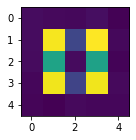

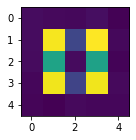

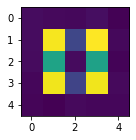

In [15]:
# show last 3 generated images
for i in range(-3, 0):
    plt.figure(figsize=(2,2))
    plt.imshow(res[i].reshape(5, 5).detach()/100)

In [16]:
# losses for the test dataset
for x, y in test_loader:
    pred = cnn(y)
    criterion = nn.MSELoss()
    loss = criterion(pred.flatten(), x.flatten())
    print(loss)

tensor(0.1166, grad_fn=<MseLossBackward0>)
tensor(0.1933, grad_fn=<MseLossBackward0>)
tensor(0.2421, grad_fn=<MseLossBackward0>)
tensor(0.1023, grad_fn=<MseLossBackward0>)
tensor(0.0586, grad_fn=<MseLossBackward0>)
tensor(0.0756, grad_fn=<MseLossBackward0>)
tensor(0.0253, grad_fn=<MseLossBackward0>)
tensor(0.5103, grad_fn=<MseLossBackward0>)
tensor(0.3655, grad_fn=<MseLossBackward0>)
tensor(0.0583, grad_fn=<MseLossBackward0>)
tensor(0.5549, grad_fn=<MseLossBackward0>)
tensor(0.1216, grad_fn=<MseLossBackward0>)
tensor(0.2200, grad_fn=<MseLossBackward0>)
tensor(0.1740, grad_fn=<MseLossBackward0>)
tensor(0.0798, grad_fn=<MseLossBackward0>)
tensor(0.0298, grad_fn=<MseLossBackward0>)
tensor(0.0616, grad_fn=<MseLossBackward0>)
tensor(0.2574, grad_fn=<MseLossBackward0>)
tensor(0.2585, grad_fn=<MseLossBackward0>)
tensor(0.5380, grad_fn=<MseLossBackward0>)
tensor(0.0107, grad_fn=<MseLossBackward0>)
tensor(0.0458, grad_fn=<MseLossBackward0>)
tensor(0.0474, grad_fn=<MseLossBackward0>)
tensor(0.01

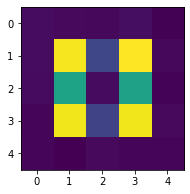

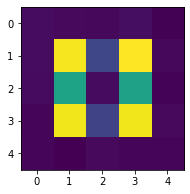

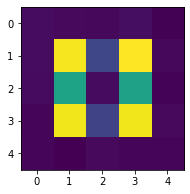

In [17]:
# show first 3 generated images, given first 3 parameters in test set
i=0 
for x, y in test_loader:
    plt.figure(figsize=(3,3))
    plt.subplot()
    plt.imshow(cnn(y).reshape(5, 5).detach()/100)
    i += 1
    if i==3:
        break